In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import pandas as pd
import numpy as np
import math
import re
from re import findall

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import seaborn as sns
from pprint import pprint

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm

import io
import os
import json
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage

In [3]:
df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
print('baseline profit & loss per day:', baseline_pnl)
df_trainval

baseline profit & loss per day: 0.0366


,dist_low_30,in_sess_time,dist_low_60,dist_low_28,eng_ema_cross_up,minute_time,rsi,hour_time,z_vwap_dev,dist_high_30,...,bb_w_z_60,minus_di_30,volume_z_30,macd_diff_z_90,plus_di_60,close_raw,signal,pred_signal,ask,bid
2009-01-02 12:30:00,0.000000,0.0,0.000000,0.000000,0.0,0.147157,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000143,0.201541,3.070103,3.069182
2009-01-02 12:31:00,0.000000,0.0,0.000000,0.000000,0.0,0.148829,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000153,0.201937,3.070103,3.069182
2009-01-02 12:32:00,0.000000,0.0,0.000000,0.000000,0.0,0.150502,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000163,0.202283,3.070103,3.069182
2009-01-02 12:33:00,0.000000,0.0,0.000000,0.000000,0.0,0.152174,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000173,0.202436,3.070103,3.069182
2009-01-02 12:34:00,0.000000,0.0,0.000000,0.000000,0.0,0.153846,1.000000,0.1,0.500425,0.000000,...,0.500000,0.000000,0.297955,0.500000,0.000000,3.069643,0.000182,0.202492,3.070103,3.069182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 20:56:00,0.183189,1.0,0.131679,0.190111,1.0,0.993311,0.583460,0.9,0.317730,0.044131,...,0.539532,0.172834,0.374268,0.530514,0.216956,131.730000,0.036463,0.114993,131.749760,131.710240
2022-12-23 20:57:00,0.210647,1.0,0.151416,0.218606,1.0,0.994983,0.616177,0.9,0.468530,0.016540,...,0.531617,0.171265,0.444313,0.527930,0.213317,131.805000,0.033832,0.127890,131.824771,131.785229
2022-12-23 20:58:00,0.219793,1.0,0.157990,0.228097,1.0,0.996655,0.626702,0.9,0.484463,0.007350,...,0.520810,0.167707,0.415307,0.525205,0.214583,131.830000,0.028223,0.127704,131.849775,131.810226
2022-12-23 20:59:00,0.230763,1.0,0.165876,0.239482,1.0,0.998328,0.639478,0.9,0.453982,0.000000,...,0.510832,0.161685,0.665962,0.523102,0.216984,131.860000,0.024628,0.132516,131.879779,131.840221


In [4]:
# Pre-compute per-day slices once
groups = df_trainval.groupby(df_trainval.index.normalize())
prun_perc = 70
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    
    sign_smoothwin = trial.suggest_categorical("sign_smoothwin", [1])
    sellmin_idx    = trial.suggest_categorical("sellmin_idx", [None])
    sess_start     = time.fromisoformat(trial.suggest_categorical("sess_start", [params.sess_start_pred.isoformat()]))
    buy_thresh     = trial.suggest_float("buy_thresh", 0.05, 0.5)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0.5, 5)

    print('-----------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Simulate trading using parameters ==> sign_smoothwin:',sign_smoothwin,'sellmin_idx:',sellmin_idx,'sess_start:',sess_start,'buy_thresh:',
          round(buy_thresh,4),'trailstop_pct:',round(trailstop_pct,4))
    
    daily_pnls: List[float] = []
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):

        # Causal smoothing of the raw pred_signal
        if sign_smoothwin > 1:
            df_day["pred_signal"] = (
                df_day["pred_signal"]
                  .rolling(window=sign_smoothwin, min_periods=1)
                  .mean()
            )

        # Generate actions on the smoothed column
        df_actions = trades.generate_trade_actions(
            df                = df_day,
            col_signal        = "pred_signal",
            col_action        = "pred_action",
            col_price         = "close_raw",
            buy_thresh        = buy_thresh,
            trailstop_pct     = trailstop_pct,
            sellmin_idx       = sellmin_idx,
            sess_start        = sess_start
            )

        # Simulate 1-day P&L
        sim = trades.simulate_trading(
            day               = day,
            df                = df_actions,
            col_action        = "pred_action",
            sellmin_idx       = sellmin_idx, 
            sess_start        = sess_start
        )
   
        _, _, stats = next(iter(sim.values()))
        
        strategy_val = float(_findall(stats["STRATEGY"])[-1]) 

        daily_pnls.append(strategy_val)

        # Explicitly delete large locals at the end of each trial (no per-iteration gc.collect)
        del df_actions, sim, stats
        df_day = df_actions = sim = stats = None

        # Rreport for pruning
        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(daily_pnls))
            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = float(__import__("numpy").percentile(vals, prun_perc))
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # Average daily P&L
    return float(np.mean(daily_pnls))


-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0838 trailstop_pct: 4.381


Trial 0: 100%|██████████| 3520/3520 [00:46<00:00, 76.33it/s] 


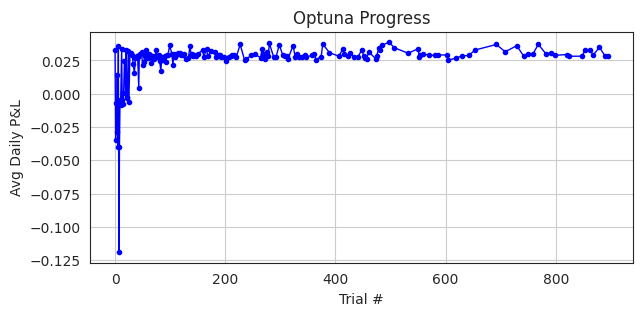

[Results] Trial 0 finished with value: 0.0332. Improvement over baseline: -9.34%.     Best is trial 0 with value: 0.0332.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2486 trailstop_pct: 1.3566


Trial 1: 100%|██████████| 3520/3520 [00:47<00:00, 73.88it/s]


[Results] Trial 1 finished with value: -0.0348. Improvement over baseline: -195.07%.     Best is trial 0 with value: 0.0332.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3056 trailstop_pct: 2.8648


Trial 2: 100%|██████████| 3520/3520 [00:49<00:00, 71.63it/s] 


[Results] Trial 2 finished with value: -0.0072. Improvement over baseline: -119.67%.     Best is trial 0 with value: 0.0332.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4258 trailstop_pct: 1.7079


Trial 3: 100%|██████████| 3520/3520 [00:42<00:00, 82.56it/s] 


[Results] Trial 3 finished with value: -0.0291. Improvement over baseline: -179.40%.     Best is trial 0 with value: 0.0332.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1948 trailstop_pct: 1.811


Trial 4: 100%|██████████| 3520/3520 [00:48<00:00, 73.16it/s]


[Results] Trial 4 finished with value: 0.0138. Improvement over baseline: -62.19%.     Best is trial 0 with value: 0.0332.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3833 trailstop_pct: 0.7197


Trial 5: 100%|██████████| 3520/3520 [00:40<00:00, 86.02it/s] 


[Results] Trial 5 finished with value: -0.0402. Improvement over baseline: -209.95%.     Best is trial 0 with value: 0.0332.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4155 trailstop_pct: 4.7185


Trial 6: 100%|██████████| 3520/3520 [00:51<00:00, 68.19it/s]


[Results] Trial 6 finished with value: 0.0360. Improvement over baseline: -1.77%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0867 trailstop_pct: 0.5671


Trial 7: 100%|██████████| 3520/3520 [00:46<00:00, 76.20it/s]


[Results] Trial 7 finished with value: -0.1190. Improvement over baseline: -425.27%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4499 trailstop_pct: 1.0804


Trial 8: 100%|██████████| 3520/3520 [00:41<00:00, 84.32it/s] 


[Results] Trial 8 finished with value: -0.0397. Improvement over baseline: -208.42%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.133 trailstop_pct: 1.2545


Trial 9: 100%|██████████| 3520/3520 [00:48<00:00, 72.29it/s]


[Results] Trial 9 finished with value: -0.0047. Improvement over baseline: -112.90%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3448 trailstop_pct: 4.9219


Trial 10: 100%|██████████| 3520/3520 [00:39<00:00, 89.87it/s] 


[Results] Trial 10 finished with value: -0.0086. Improvement over baseline: -123.44%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4803 trailstop_pct: 4.8364


Trial 11:  45%|████▌     | 1591/3520 [00:18<00:22, 84.97it/s]


[PRUNE] value=-0.076142 thr=-0.002465
[Results] Trial 11 finished with value: -0.0761. Improvement over baseline: -308.04%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2276 trailstop_pct: 3.8971


Trial 12: 100%|██████████| 3520/3520 [00:47<00:00, 73.83it/s]


[Results] Trial 12 finished with value: 0.0337. Improvement over baseline: -8.00%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2276 trailstop_pct: 3.7457


Trial 13: 100%|██████████| 3520/3520 [00:48<00:00, 71.96it/s]


[Results] Trial 13 finished with value: -0.0046. Improvement over baseline: -112.63%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1754 trailstop_pct: 3.6151


Trial 14: 100%|██████████| 3520/3520 [00:44<00:00, 78.55it/s]


[Results] Trial 14 finished with value: 0.0004. Improvement over baseline: -98.88%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2791 trailstop_pct: 3.8286


Trial 15: 100%|██████████| 3520/3520 [00:43<00:00, 80.62it/s]


[Results] Trial 15 finished with value: -0.0077. Improvement over baseline: -121.16%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3319 trailstop_pct: 2.6805


Trial 16:  38%|███▊      | 1344/3520 [00:16<00:26, 81.18it/s]


[PRUNE] value=-0.087233 thr=-0.020725
[Results] Trial 16 finished with value: -0.0872. Improvement over baseline: -338.34%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3985 trailstop_pct: 4.284


Trial 17: 100%|██████████| 3520/3520 [00:41<00:00, 84.70it/s] 


[Results] Trial 17 finished with value: 0.0246. Improvement over baseline: -32.79%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3593 trailstop_pct: 3.0684


Trial 18:  47%|████▋     | 1641/3520 [00:19<00:22, 82.34it/s]


[PRUNE] value=-0.070546 thr=-0.001363
[Results] Trial 18 finished with value: -0.0705. Improvement over baseline: -292.75%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4847 trailstop_pct: 4.2775


Trial 19: 100%|██████████| 3520/3520 [00:40<00:00, 86.79it/s] 


[Results] Trial 19 finished with value: 0.0004. Improvement over baseline: -98.97%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.152 trailstop_pct: 3.3441


Trial 20: 100%|██████████| 3520/3520 [00:46<00:00, 76.36it/s]


[Results] Trial 20 finished with value: 0.0329. Improvement over baseline: -10.21%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.069 trailstop_pct: 4.3666


Trial 21: 100%|██████████| 3520/3520 [00:36<00:00, 95.18it/s] 


[Results] Trial 21 finished with value: -0.0029. Improvement over baseline: -107.80%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1077 trailstop_pct: 4.66


Trial 22: 100%|██████████| 3520/3520 [00:42<00:00, 82.38it/s] 


[Results] Trial 22 finished with value: -0.0028. Improvement over baseline: -107.54%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2066 trailstop_pct: 4.1175


Trial 23:  28%|██▊       | 999/3520 [00:14<00:36, 69.72it/s]


[PRUNE] value=-0.114849 thr=-0.001974
[Results] Trial 23 finished with value: -0.1148. Improvement over baseline: -413.80%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.287 trailstop_pct: 2.4233


Trial 24: 100%|██████████| 3520/3520 [00:41<00:00, 84.88it/s] 


[Results] Trial 24 finished with value: 0.0318. Improvement over baseline: -13.14%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2502 trailstop_pct: 4.5588


Trial 25: 100%|██████████| 3520/3520 [00:42<00:00, 82.58it/s] 


[Results] Trial 25 finished with value: -0.0065. Improvement over baseline: -117.79%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1325 trailstop_pct: 3.9618


Trial 26:  28%|██▊       | 992/3520 [00:11<00:30, 82.72it/s] 


[PRUNE] value=-0.115357 thr=-0.001149
[Results] Trial 26 finished with value: -0.1154. Improvement over baseline: -415.18%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0513 trailstop_pct: 4.9918


Trial 27: 100%|██████████| 3520/3520 [00:39<00:00, 89.22it/s] 


[Results] Trial 27 finished with value: 0.0299. Improvement over baseline: -18.19%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4364 trailstop_pct: 3.4396


Trial 28:  25%|██▌       | 891/3520 [00:10<00:30, 86.72it/s] 


[PRUNE] value=-0.132624 thr=0.000627
[Results] Trial 28 finished with value: -0.1326. Improvement over baseline: -462.36%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2505 trailstop_pct: 4.519


Trial 29: 100%|██████████| 3520/3520 [00:44<00:00, 78.87it/s] 


[Results] Trial 29 finished with value: 0.0303. Improvement over baseline: -17.16%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3137 trailstop_pct: 3.9989


Trial 30:  25%|██▌       | 893/3520 [00:12<00:36, 72.54it/s]


[PRUNE] value=-0.127291 thr=0.002080
[Results] Trial 30 finished with value: -0.1273. Improvement over baseline: -447.79%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1621 trailstop_pct: 3.3921


Trial 31: 100%|██████████| 3520/3520 [00:47<00:00, 74.23it/s]


[Results] Trial 31 finished with value: 0.0289. Improvement over baseline: -20.91%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1417 trailstop_pct: 3.205


Trial 32:  25%|██▌       | 896/3520 [00:12<00:35, 74.57it/s]


[PRUNE] value=-0.126029 thr=0.001359
[Results] Trial 32 finished with value: -0.1260. Improvement over baseline: -444.34%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1026 trailstop_pct: 2.5568


Trial 33: 100%|██████████| 3520/3520 [00:45<00:00, 77.97it/s]


[Results] Trial 33 finished with value: 0.0220. Improvement over baseline: -39.81%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2198 trailstop_pct: 3.0038


Trial 34:  25%|██▌       | 897/3520 [00:12<00:36, 72.14it/s]


[PRUNE] value=-0.127343 thr=0.000810
[Results] Trial 34 finished with value: -0.1273. Improvement over baseline: -447.93%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1743 trailstop_pct: 1.9945


Trial 35: 100%|██████████| 3520/3520 [00:45<00:00, 76.63it/s]


[Results] Trial 35 finished with value: 0.0156. Improvement over baseline: -57.45%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1124 trailstop_pct: 3.5693


Trial 36:  28%|██▊       | 996/3520 [00:14<00:35, 70.20it/s]


[PRUNE] value=-0.114925 thr=-0.000739
[Results] Trial 36 finished with value: -0.1149. Improvement over baseline: -414.00%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.197 trailstop_pct: 4.0392


Trial 37: 100%|██████████| 3520/3520 [00:47<00:00, 73.93it/s]


[Results] Trial 37 finished with value: 0.0267. Improvement over baseline: -27.12%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0806 trailstop_pct: 3.286


Trial 38:  28%|██▊       | 998/3520 [00:14<00:36, 69.36it/s]


[PRUNE] value=-0.115179 thr=-0.000937
[Results] Trial 38 finished with value: -0.1152. Improvement over baseline: -414.70%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1456 trailstop_pct: 4.7024


Trial 39: 100%|██████████| 3520/3520 [00:45<00:00, 77.40it/s]


[Results] Trial 39 finished with value: 0.0282. Improvement over baseline: -22.93%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2416 trailstop_pct: 4.3276


Trial 40:  55%|█████▌    | 1946/3520 [00:27<00:22, 71.22it/s]


[PRUNE] value=-0.055515 thr=0.002115
[Results] Trial 40 finished with value: -0.0555. Improvement over baseline: -251.68%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2837 trailstop_pct: 2.3616


Trial 41: 100%|██████████| 3520/3520 [00:41<00:00, 84.08it/s] 


[Results] Trial 41 finished with value: 0.0274. Improvement over baseline: -25.00%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3864 trailstop_pct: 2.295


Trial 42:  25%|██▌       | 897/3520 [00:10<00:31, 82.15it/s] 


[PRUNE] value=-0.130556 thr=0.000097
[Results] Trial 42 finished with value: -0.1306. Improvement over baseline: -456.71%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4628 trailstop_pct: 1.7024


Trial 43: 100%|██████████| 3520/3520 [00:42<00:00, 83.24it/s] 


[Results] Trial 43 finished with value: 0.0043. Improvement over baseline: -88.13%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3069 trailstop_pct: 2.8562


Trial 44: 100%|██████████| 3520/3520 [00:49<00:00, 71.38it/s]


[Results] Trial 44 finished with value: 0.0290. Improvement over baseline: -20.84%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3564 trailstop_pct: 3.6875


Trial 45:  25%|██▌       | 896/3520 [00:12<00:36, 72.53it/s]


[PRUNE] value=-0.129862 thr=0.001377
[Results] Trial 45 finished with value: -0.1299. Improvement over baseline: -454.81%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2679 trailstop_pct: 3.8171


Trial 46: 100%|██████████| 3520/3520 [00:50<00:00, 69.93it/s]


[Results] Trial 46 finished with value: 0.0301. Improvement over baseline: -17.80%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4232 trailstop_pct: 4.792


Trial 47:  25%|██▌       | 897/3520 [00:12<00:35, 73.11it/s]


[PRUNE] value=-0.125802 thr=0.001030
[Results] Trial 47 finished with value: -0.1258. Improvement over baseline: -443.72%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1803 trailstop_pct: 4.4506


Trial 48: 100%|██████████| 3520/3520 [00:49<00:00, 71.36it/s]


[Results] Trial 48 finished with value: 0.0314. Improvement over baseline: -14.11%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3309 trailstop_pct: 4.2


Trial 49:  25%|██▌       | 894/3520 [00:11<00:33, 78.62it/s] 


[PRUNE] value=-0.127321 thr=0.001789
[Results] Trial 49 finished with value: -0.1273. Improvement over baseline: -447.87%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1229 trailstop_pct: 2.6052


Trial 50: 100%|██████████| 3520/3520 [00:49<00:00, 71.61it/s]


[Results] Trial 50 finished with value: 0.0212. Improvement over baseline: -41.95%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1756 trailstop_pct: 4.5108


Trial 51:  25%|██▌       | 895/3520 [00:12<00:37, 69.61it/s]


[PRUNE] value=-0.124970 thr=0.001493
[Results] Trial 51 finished with value: -0.1250. Improvement over baseline: -441.45%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2131 trailstop_pct: 4.4493


Trial 52: 100%|██████████| 3520/3520 [00:47<00:00, 74.19it/s]


[Results] Trial 52 finished with value: 0.0239. Improvement over baseline: -34.62%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.187 trailstop_pct: 3.8604


Trial 53:  26%|██▌       | 899/3520 [00:11<00:32, 80.39it/s] 


[PRUNE] value=-0.125313 thr=0.001146
[Results] Trial 53 finished with value: -0.1253. Improvement over baseline: -442.39%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0925 trailstop_pct: 4.7877


Trial 54: 100%|██████████| 3520/3520 [00:47<00:00, 73.49it/s]


[Results] Trial 54 finished with value: 0.0283. Improvement over baseline: -22.56%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1687 trailstop_pct: 4.1392


Trial 55:  26%|██▌       | 899/3520 [00:12<00:35, 74.71it/s]


[PRUNE] value=-0.125226 thr=0.000799
[Results] Trial 55 finished with value: -0.1252. Improvement over baseline: -442.15%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1572 trailstop_pct: 3.527


Trial 56: 100%|██████████| 3520/3520 [00:49<00:00, 71.16it/s] 


[Results] Trial 56 finished with value: 0.0328. Improvement over baseline: -10.51%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1526 trailstop_pct: 3.547


Trial 57:  26%|██▌       | 899/3520 [00:12<00:35, 74.38it/s]


[PRUNE] value=-0.124639 thr=0.000501
[Results] Trial 57 finished with value: -0.1246. Improvement over baseline: -440.54%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.053 trailstop_pct: 3.0586


Trial 58: 100%|██████████| 3520/3520 [00:42<00:00, 83.77it/s] 


[Results] Trial 58 finished with value: 0.0267. Improvement over baseline: -27.14%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2286 trailstop_pct: 2.0594


Trial 59:  26%|██▌       | 899/3520 [00:11<00:32, 80.90it/s] 


[PRUNE] value=-0.132618 thr=0.000299
[Results] Trial 59 finished with value: -0.1326. Improvement over baseline: -462.34%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0715 trailstop_pct: 3.234


Trial 60: 100%|██████████| 3520/3520 [00:43<00:00, 81.81it/s] 


[Results] Trial 60 finished with value: 0.0266. Improvement over baseline: -27.43%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1884 trailstop_pct: 3.9126


Trial 61:  26%|██▌       | 898/3520 [00:15<00:45, 57.01it/s]


[PRUNE] value=-0.125439 thr=0.000097
[Results] Trial 61 finished with value: -0.1254. Improvement over baseline: -442.73%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2656 trailstop_pct: 4.636


Trial 62: 100%|██████████| 3520/3520 [00:45<00:00, 77.54it/s]


[Results] Trial 62 finished with value: 0.0296. Improvement over baseline: -19.13%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.126 trailstop_pct: 4.337


Trial 63:  25%|██▌       | 894/3520 [00:12<00:36, 72.07it/s]


[PRUNE] value=-0.124321 thr=-0.000104
[Results] Trial 63 finished with value: -0.1243. Improvement over baseline: -439.68%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1573 trailstop_pct: 4.943


Trial 64: 100%|██████████| 3520/3520 [00:47<00:00, 73.67it/s] 


[Results] Trial 64 finished with value: 0.0290. Improvement over baseline: -20.82%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2393 trailstop_pct: 2.8515


Trial 65:  25%|██▌       | 890/3520 [00:13<00:38, 68.40it/s]


[PRUNE] value=-0.125101 thr=-0.000262
[Results] Trial 65 finished with value: -0.1251. Improvement over baseline: -441.81%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2917 trailstop_pct: 3.7301


Trial 66: 100%|██████████| 3520/3520 [00:47<00:00, 74.23it/s]


[Results] Trial 66 finished with value: 0.0229. Improvement over baseline: -37.36%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4044 trailstop_pct: 3.3847


Trial 67:  25%|██▌       | 892/3520 [00:09<00:29, 89.21it/s] 


[PRUNE] value=-0.130477 thr=-0.000419
[Results] Trial 67 finished with value: -0.1305. Improvement over baseline: -456.49%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1906 trailstop_pct: 4.1654


Trial 68: 100%|██████████| 3520/3520 [00:42<00:00, 83.73it/s]


[Results] Trial 68 finished with value: 0.0282. Improvement over baseline: -22.99%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2003 trailstop_pct: 4.4419


Trial 69:  25%|██▌       | 894/3520 [00:13<00:38, 67.91it/s]


[PRUNE] value=-0.124953 thr=-0.000037
[Results] Trial 69 finished with value: -0.1250. Improvement over baseline: -441.40%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1389 trailstop_pct: 0.7292


Trial 70:  25%|██▌       | 893/3520 [00:13<00:38, 67.83it/s]


[PRUNE] value=-0.038513 thr=-0.000037
[Results] Trial 70 finished with value: -0.0385. Improvement over baseline: -205.23%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2528 trailstop_pct: 4.6721


Trial 71: 100%|██████████| 3520/3520 [00:41<00:00, 84.08it/s] 


[Results] Trial 71 finished with value: 0.0263. Improvement over baseline: -28.11%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.217 trailstop_pct: 4.5636


Trial 72:  25%|██▌       | 897/3520 [00:11<00:32, 79.62it/s]


[PRUNE] value=-0.125721 thr=-0.000187
[Results] Trial 72 finished with value: -0.1257. Improvement over baseline: -443.50%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2305 trailstop_pct: 4.0405


Trial 73: 100%|██████████| 3520/3520 [00:38<00:00, 91.78it/s] 


[Results] Trial 73 finished with value: 0.0284. Improvement over baseline: -22.40%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4997 trailstop_pct: 2.4694


Trial 74:  25%|██▌       | 897/3520 [00:11<00:32, 80.27it/s]


[PRUNE] value=-0.138139 thr=-0.000311
[Results] Trial 74 finished with value: -0.1381. Improvement over baseline: -477.43%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1109 trailstop_pct: 4.8856


Trial 75: 100%|██████████| 3520/3520 [00:47<00:00, 74.04it/s]


[Results] Trial 75 finished with value: 0.0326. Improvement over baseline: -10.96%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0982 trailstop_pct: 4.8576


Trial 76:  25%|██▌       | 895/3520 [00:13<00:39, 66.01it/s] 


[PRUNE] value=-0.124402 thr=0.000030
[Results] Trial 76 finished with value: -0.1244. Improvement over baseline: -439.90%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1108 trailstop_pct: 4.2641


Trial 77: 100%|██████████| 3520/3520 [00:45<00:00, 77.62it/s]


[Results] Trial 77 finished with value: 0.0272. Improvement over baseline: -25.57%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1158 trailstop_pct: 3.554


Trial 78:  25%|██▌       | 892/3520 [00:13<00:40, 64.65it/s]


[PRUNE] value=-0.125028 thr=-0.000146
[Results] Trial 78 finished with value: -0.1250. Improvement over baseline: -441.61%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0785 trailstop_pct: 4.9947


Trial 79: 100%|██████████| 3520/3520 [00:44<00:00, 79.36it/s] 


[Results] Trial 79 finished with value: 0.0288. Improvement over baseline: -21.20%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1489 trailstop_pct: 4.7379


Trial 80:  25%|██▌       | 892/3520 [00:11<00:32, 79.94it/s] 


[PRUNE] value=-0.125017 thr=-0.000269
[Results] Trial 80 finished with value: -0.1250. Improvement over baseline: -441.58%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1701 trailstop_pct: 4.4464


Trial 81: 100%|██████████| 3520/3520 [00:47<00:00, 73.75it/s]


[Results] Trial 81 finished with value: 0.0249. Improvement over baseline: -31.85%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2915 trailstop_pct: 4.539


Trial 82:  26%|██▌       | 899/3520 [00:11<00:32, 80.73it/s]


[PRUNE] value=-0.124537 thr=-0.000393
[Results] Trial 82 finished with value: -0.1245. Improvement over baseline: -440.26%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1826 trailstop_pct: 2.2158


Trial 83: 100%|██████████| 3520/3520 [00:47<00:00, 74.16it/s]


[Results] Trial 83 finished with value: 0.0170. Improvement over baseline: -53.44%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2591 trailstop_pct: 4.0465


Trial 84:  26%|██▌       | 899/3520 [00:11<00:34, 75.47it/s]


[PRUNE] value=-0.125689 thr=-0.000517
[Results] Trial 84 finished with value: -0.1257. Improvement over baseline: -443.41%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1332 trailstop_pct: 4.8367


Trial 85: 100%|██████████| 3520/3520 [00:49<00:00, 71.28it/s]


[Results] Trial 85 finished with value: 0.0277. Improvement over baseline: -24.38%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2078 trailstop_pct: 4.2477


Trial 86:  25%|██▌       | 894/3520 [00:14<00:42, 62.20it/s]


[PRUNE] value=-0.125786 thr=-0.000550
[Results] Trial 86 finished with value: -0.1258. Improvement over baseline: -443.68%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3223 trailstop_pct: 4.6219


Trial 87: 100%|██████████| 3520/3520 [00:49<00:00, 71.68it/s]


[Results] Trial 87 finished with value: 0.0250. Improvement over baseline: -31.68%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0613 trailstop_pct: 4.3986


Trial 88:  25%|██▌       | 896/3520 [00:12<00:37, 69.99it/s] 


[PRUNE] value=-0.124150 thr=-0.000584
[Results] Trial 88 finished with value: -0.1241. Improvement over baseline: -439.21%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3661 trailstop_pct: 3.143


Trial 89:  64%|██████▍   | 2247/3520 [00:27<00:15, 81.79it/s] 


[PRUNE] value=0.000375 thr=0.008738
[Results] Trial 89 finished with value: 0.0004. Improvement over baseline: -98.98%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1602 trailstop_pct: 2.9631


Trial 90: 100%|██████████| 3520/3520 [00:47<00:00, 73.85it/s]


[Results] Trial 90 finished with value: 0.0285. Improvement over baseline: -22.16%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2381 trailstop_pct: 3.8501


Trial 91:  25%|██▌       | 895/3520 [00:12<00:37, 69.40it/s]


[PRUNE] value=-0.124122 thr=-0.000475
[Results] Trial 91 finished with value: -0.1241. Improvement over baseline: -439.13%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2743 trailstop_pct: 3.7234


Trial 92: 100%|██████████| 3520/3520 [00:45<00:00, 77.61it/s]


[Results] Trial 92 finished with value: 0.0241. Improvement over baseline: -34.26%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2692 trailstop_pct: 2.7535


Trial 93:  26%|██▌       | 898/3520 [00:12<00:37, 70.59it/s]


[PRUNE] value=-0.125278 thr=-0.000539
[Results] Trial 93 finished with value: -0.1253. Improvement over baseline: -442.29%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2943 trailstop_pct: 3.4588


Trial 94: 100%|██████████| 3520/3520 [00:38<00:00, 91.39it/s] 


[Results] Trial 94 finished with value: 0.0288. Improvement over baseline: -21.22%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0941 trailstop_pct: 3.9428


Trial 95:  25%|██▌       | 897/3520 [00:09<00:27, 94.62it/s] 


[PRUNE] value=-0.124502 thr=-0.000573
[Results] Trial 95 finished with value: -0.1245. Improvement over baseline: -440.17%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.123 trailstop_pct: 3.8184


Trial 96: 100%|██████████| 3520/3520 [00:45<00:00, 77.91it/s]


[Results] Trial 96 finished with value: 0.0290. Improvement over baseline: -20.74%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2467 trailstop_pct: 1.7106


Trial 97:  25%|██▌       | 890/3520 [00:12<00:36, 71.60it/s]


[PRUNE] value=-0.131061 thr=-0.000606
[Results] Trial 97 finished with value: -0.1311. Improvement over baseline: -458.09%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4511 trailstop_pct: 3.3395


Trial 98:  26%|██▌       | 898/3520 [00:10<00:30, 86.51it/s] 


[PRUNE] value=-0.010942 thr=-0.000606
[Results] Trial 98 finished with value: -0.0109. Improvement over baseline: -129.90%.     Best is trial 6 with value: 0.0360.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2576 trailstop_pct: 3.6339


Trial 99: 100%|██████████| 3520/3520 [00:47<00:00, 74.15it/s]


[Results] Trial 99 finished with value: 0.0364. Improvement over baseline: -0.61%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0853 trailstop_pct: 4.9044


Trial 100:  25%|██▌       | 895/3520 [00:11<00:33, 79.44it/s]


[PRUNE] value=-0.123883 thr=-0.000528
[Results] Trial 100 finished with value: -0.1239. Improvement over baseline: -438.48%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2549 trailstop_pct: 3.6074


Trial 101:  64%|██████▍   | 2249/3520 [00:30<00:17, 74.50it/s]


[PRUNE] value=0.003778 thr=0.008743
[Results] Trial 101 finished with value: 0.0038. Improvement over baseline: -89.68%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.284 trailstop_pct: 3.5132


Trial 102:  25%|██▌       | 895/3520 [00:11<00:34, 75.50it/s]


[PRUNE] value=-0.027720 thr=-0.000528
[Results] Trial 102 finished with value: -0.0277. Improvement over baseline: -175.74%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2261 trailstop_pct: 3.6519


Trial 103: 100%|██████████| 3520/3520 [00:44<00:00, 78.36it/s]


[Results] Trial 103 finished with value: 0.0301. Improvement over baseline: -17.89%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.263 trailstop_pct: 4.1543


Trial 104:  25%|██▌       | 896/3520 [00:11<00:34, 75.70it/s]


[PRUNE] value=-0.125918 thr=-0.000562
[Results] Trial 104 finished with value: -0.1259. Improvement over baseline: -444.04%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3072 trailstop_pct: 4.339


Trial 105: 100%|██████████| 3520/3520 [00:40<00:00, 87.03it/s] 


[Results] Trial 105 finished with value: 0.0218. Improvement over baseline: -40.55%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.202 trailstop_pct: 4.7549


Trial 106:  25%|██▌       | 893/3520 [00:13<00:40, 64.44it/s]


[PRUNE] value=-0.124711 thr=-0.000595
[Results] Trial 106 finished with value: -0.1247. Improvement over baseline: -440.74%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1778 trailstop_pct: 3.7987


Trial 107: 100%|██████████| 3520/3520 [00:48<00:00, 72.50it/s]


[Results] Trial 107 finished with value: 0.0299. Improvement over baseline: -18.20%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2792 trailstop_pct: 4.5811


Trial 108:  25%|██▌       | 891/3520 [00:12<00:36, 72.77it/s]


[PRUNE] value=-0.124670 thr=-0.000629
[Results] Trial 108 finished with value: -0.1247. Improvement over baseline: -440.63%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1374 trailstop_pct: 4.4981


Trial 109: 100%|██████████| 3520/3520 [00:47<00:00, 73.96it/s] 


[Results] Trial 109 finished with value: 0.0275. Improvement over baseline: -24.78%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2346 trailstop_pct: 4.0709


Trial 110:  25%|██▌       | 893/3520 [00:13<00:40, 64.25it/s]


[PRUNE] value=-0.126078 thr=-0.000638
[Results] Trial 110 finished with value: -0.1261. Improvement over baseline: -444.47%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2219 trailstop_pct: 3.6458


Trial 111: 100%|██████████| 3520/3520 [00:45<00:00, 77.86it/s]


[Results] Trial 111 finished with value: 0.0289. Improvement over baseline: -20.95%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2433 trailstop_pct: 3.9477


Trial 112:  25%|██▌       | 893/3520 [00:12<00:36, 71.55it/s]


[PRUNE] value=-0.124686 thr=-0.000646
[Results] Trial 112 finished with value: -0.1247. Improvement over baseline: -440.67%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.222 trailstop_pct: 3.333


Trial 113:  64%|██████▎   | 2243/3520 [00:30<00:17, 73.45it/s]


[PRUNE] value=0.004741 thr=0.008738
[Results] Trial 113 finished with value: 0.0047. Improvement over baseline: -87.05%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2117 trailstop_pct: 3.6786


Trial 114:  25%|██▌       | 894/3520 [00:13<00:39, 66.04it/s]


[PRUNE] value=-0.026416 thr=-0.000646
[Results] Trial 114 finished with value: -0.0264. Improvement over baseline: -172.17%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1032 trailstop_pct: 3.4889


Trial 115: 100%|██████████| 3520/3520 [00:48<00:00, 72.39it/s] 


[Results] Trial 115 finished with value: 0.0303. Improvement over baseline: -17.11%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.076 trailstop_pct: 3.2481


Trial 116:  25%|██▌       | 897/3520 [00:12<00:35, 74.75it/s]


[PRUNE] value=-0.125238 thr=-0.000655
[Results] Trial 116 finished with value: -0.1252. Improvement over baseline: -442.18%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1029 trailstop_pct: 3.4783


Trial 117: 100%|██████████| 3520/3520 [00:53<00:00, 65.59it/s]


[Results] Trial 117 finished with value: 0.0303. Improvement over baseline: -17.33%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1067 trailstop_pct: 3.1224


Trial 118:  25%|██▌       | 896/3520 [00:12<00:37, 69.69it/s]


[PRUNE] value=-0.125246 thr=-0.000700
[Results] Trial 118 finished with value: -0.1252. Improvement over baseline: -442.20%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1193 trailstop_pct: 4.6847


Trial 119: 100%|██████████| 3520/3520 [00:50<00:00, 70.06it/s] 


[Results] Trial 119 finished with value: 0.0290. Improvement over baseline: -20.86%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0636 trailstop_pct: 3.449


Trial 120:  26%|██▌       | 898/3520 [00:13<00:38, 68.01it/s]


[PRUNE] value=-0.124958 thr=-0.000764
[Results] Trial 120 finished with value: -0.1250. Improvement over baseline: -441.41%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1009 trailstop_pct: 2.4224


Trial 121:  40%|███▉      | 1391/3520 [00:19<00:29, 71.85it/s]


[PRUNE] value=-0.001439 thr=0.001816
[Results] Trial 121 finished with value: -0.0014. Improvement over baseline: -103.93%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0905 trailstop_pct: 3.4499


Trial 122:  26%|██▌       | 898/3520 [00:12<00:36, 71.81it/s]


[PRUNE] value=-0.005767 thr=-0.000764
[Results] Trial 122 finished with value: -0.0058. Improvement over baseline: -115.76%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1451 trailstop_pct: 3.7698


Trial 123: 100%|██████████| 3520/3520 [00:46<00:00, 76.22it/s] 


[Results] Trial 123 finished with value: 0.0293. Improvement over baseline: -20.03%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1668 trailstop_pct: 3.5645


Trial 124:  26%|██▌       | 899/3520 [00:13<00:40, 65.36it/s]


[PRUNE] value=-0.124938 thr=-0.000828
[Results] Trial 124 finished with value: -0.1249. Improvement over baseline: -441.36%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4098 trailstop_pct: 2.6963


Trial 125:  25%|██▌       | 896/3520 [00:10<00:32, 81.60it/s]


[PRUNE] value=-0.004382 thr=-0.000828
[Results] Trial 125 finished with value: -0.0044. Improvement over baseline: -111.97%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1315 trailstop_pct: 2.9571


Trial 126: 100%|██████████| 3520/3520 [00:41<00:00, 84.91it/s] 


[Results] Trial 126 finished with value: 0.0297. Improvement over baseline: -18.84%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.108 trailstop_pct: 4.8849


Trial 127:  25%|██▌       | 893/3520 [00:09<00:27, 94.93it/s] 


[PRUNE] value=-0.124482 thr=-0.000679
[Results] Trial 127 finished with value: -0.1245. Improvement over baseline: -440.12%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3394 trailstop_pct: 3.2093


Trial 128:  25%|██▌       | 895/3520 [00:10<00:30, 86.39it/s] 


[PRUNE] value=-0.009580 thr=-0.000679
[Results] Trial 128 finished with value: -0.0096. Improvement over baseline: -126.17%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1545 trailstop_pct: 4.2438


Trial 129: 100%|██████████| 3520/3520 [00:50<00:00, 69.84it/s]


[Results] Trial 129 finished with value: 0.0260. Improvement over baseline: -29.06%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1289 trailstop_pct: 2.2176


Trial 130:  25%|██▌       | 896/3520 [00:11<00:34, 76.65it/s]


[PRUNE] value=-0.127172 thr=-0.000743
[Results] Trial 130 finished with value: -0.1272. Improvement over baseline: -447.47%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2554 trailstop_pct: 3.6116


Trial 131:  44%|████▍     | 1548/3520 [00:20<00:25, 75.97it/s]


[PRUNE] value=0.001533 thr=0.006072
[Results] Trial 131 finished with value: 0.0015. Improvement over baseline: -95.81%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2273 trailstop_pct: 3.8801


Trial 132:  25%|██▌       | 894/3520 [00:12<00:37, 69.40it/s]


[PRUNE] value=-0.014028 thr=-0.000743
[Results] Trial 132 finished with value: -0.0140. Improvement over baseline: -138.33%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1915 trailstop_pct: 3.7193


Trial 133: 100%|██████████| 3520/3520 [00:48<00:00, 73.26it/s]


[Results] Trial 133 finished with value: 0.0267. Improvement over baseline: -27.01%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0899 trailstop_pct: 3.4717


Trial 134:  25%|██▌       | 895/3520 [00:11<00:32, 81.01it/s]


[PRUNE] value=-0.124909 thr=-0.000807
[Results] Trial 134 finished with value: -0.1249. Improvement over baseline: -441.28%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3741 trailstop_pct: 3.3541


Trial 135:  25%|██▌       | 892/3520 [00:11<00:33, 78.05it/s]


[PRUNE] value=-0.009920 thr=-0.000807
[Results] Trial 135 finished with value: -0.0099. Improvement over baseline: -127.10%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1143 trailstop_pct: 3.6742


Trial 136: 100%|██████████| 3520/3520 [00:44<00:00, 79.29it/s] 


[Results] Trial 136 finished with value: 0.0360. Improvement over baseline: -1.67%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1153 trailstop_pct: 4.0021


Trial 137:  25%|██▌       | 895/3520 [00:12<00:38, 68.89it/s]


[PRUNE] value=-0.124318 thr=-0.000658
[Results] Trial 137 finished with value: -0.1243. Improvement over baseline: -439.67%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0832 trailstop_pct: 4.4649


Trial 138: 100%|██████████| 3520/3520 [00:45<00:00, 76.99it/s]


[Results] Trial 138 finished with value: 0.0292. Improvement over baseline: -20.15%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2747 trailstop_pct: 4.7781


Trial 139:  26%|██▌       | 898/3520 [00:11<00:34, 74.95it/s]


[PRUNE] value=-0.124951 thr=-0.000722
[Results] Trial 139 finished with value: -0.1250. Improvement over baseline: -441.40%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.103 trailstop_pct: 4.6111


Trial 140: 100%|██████████| 3520/3520 [00:44<00:00, 79.06it/s]


[Results] Trial 140 finished with value: 0.0302. Improvement over baseline: -17.54%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1221 trailstop_pct: 4.6219


Trial 141:  25%|██▌       | 893/3520 [00:11<00:33, 78.83it/s]


[PRUNE] value=-0.124047 thr=-0.000786
[Results] Trial 141 finished with value: -0.1240. Improvement over baseline: -438.93%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0684 trailstop_pct: 4.4148


Trial 142: 100%|██████████| 3520/3520 [00:43<00:00, 81.78it/s]


[Results] Trial 142 finished with value: 0.0281. Improvement over baseline: -23.18%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1066 trailstop_pct: 4.6903


Trial 143:  25%|██▌       | 894/3520 [00:11<00:33, 77.98it/s]


[PRUNE] value=-0.124304 thr=-0.000850
[Results] Trial 143 finished with value: -0.1243. Improvement over baseline: -439.63%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0967 trailstop_pct: 3.5234


Trial 144: 100%|██████████| 3520/3520 [00:44<00:00, 79.39it/s]


[Results] Trial 144 finished with value: 0.0291. Improvement over baseline: -20.53%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1461 trailstop_pct: 4.983


Trial 145:  25%|██▌       | 897/3520 [00:11<00:34, 75.15it/s]


[PRUNE] value=-0.125331 thr=-0.000871
[Results] Trial 145 finished with value: -0.1253. Improvement over baseline: -442.43%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1142 trailstop_pct: 4.5562


Trial 146: 100%|██████████| 3520/3520 [00:46<00:00, 76.31it/s]


[Results] Trial 146 finished with value: 0.0281. Improvement over baseline: -23.34%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2999 trailstop_pct: 4.8337


Trial 147:  25%|██▌       | 895/3520 [00:11<00:32, 79.99it/s]


[PRUNE] value=-0.125294 thr=-0.000872
[Results] Trial 147 finished with value: -0.1253. Improvement over baseline: -442.33%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2668 trailstop_pct: 3.7752


Trial 148:  79%|███████▉  | 2797/3520 [00:40<00:10, 69.90it/s]


[PRUNE] value=0.016524 thr=0.019774
[Results] Trial 148 finished with value: 0.0165. Improvement over baseline: -54.85%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.098 trailstop_pct: 3.8834


Trial 149:  26%|██▌       | 898/3520 [00:13<00:38, 68.63it/s]


[PRUNE] value=-0.066409 thr=-0.000872
[Results] Trial 149 finished with value: -0.0664. Improvement over baseline: -281.45%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1394 trailstop_pct: 1.9991


Trial 150:  25%|██▌       | 893/3520 [00:13<00:38, 68.22it/s]


[PRUNE] value=-0.009306 thr=-0.000872
[Results] Trial 150 finished with value: -0.0093. Improvement over baseline: -125.43%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2417 trailstop_pct: 3.6567


Trial 151: 100%|██████████| 3520/3520 [00:46<00:00, 75.19it/s]


[Results] Trial 151 finished with value: 0.0301. Improvement over baseline: -17.85%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0822 trailstop_pct: 3.6323


Trial 152:  25%|██▌       | 897/3520 [00:11<00:32, 81.53it/s]


[PRUNE] value=-0.124837 thr=-0.000872
[Results] Trial 152 finished with value: -0.1248. Improvement over baseline: -441.08%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2467 trailstop_pct: 3.4014


Trial 153:  26%|██▌       | 898/3520 [00:11<00:34, 76.44it/s]


[PRUNE] value=-0.003734 thr=-0.000872
[Results] Trial 153 finished with value: -0.0037. Improvement over baseline: -110.20%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2587 trailstop_pct: 3.5398


Trial 154:  40%|███▉      | 1396/3520 [00:17<00:27, 77.86it/s]


[PRUNE] value=-0.000154 thr=0.001786
[Results] Trial 154 finished with value: -0.0002. Improvement over baseline: -100.42%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1612 trailstop_pct: 1.3979


Trial 155:  25%|██▌       | 897/3520 [00:10<00:31, 82.44it/s]


[PRUNE] value=-0.016818 thr=-0.000872
[Results] Trial 155 finished with value: -0.0168. Improvement over baseline: -145.95%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2826 trailstop_pct: 4.1241


Trial 156:  26%|██▌       | 899/3520 [00:12<00:36, 71.59it/s]


[PRUNE] value=-0.003071 thr=-0.000872
[Results] Trial 156 finished with value: -0.0031. Improvement over baseline: -108.39%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2357 trailstop_pct: 3.2753


Trial 157:  26%|██▌       | 898/3520 [00:12<00:37, 69.17it/s]


[PRUNE] value=-0.003200 thr=-0.000872
[Results] Trial 157 finished with value: -0.0032. Improvement over baseline: -108.74%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4736 trailstop_pct: 4.3168


Trial 158:  26%|██▌       | 899/3520 [00:11<00:33, 77.17it/s] 


[PRUNE] value=-0.008298 thr=-0.000872
[Results] Trial 158 finished with value: -0.0083. Improvement over baseline: -122.67%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0527 trailstop_pct: 3.7019


Trial 159: 100%|██████████| 3520/3520 [00:43<00:00, 80.07it/s]


[Results] Trial 159 finished with value: 0.0330. Improvement over baseline: -9.84%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0596 trailstop_pct: 3.7654


Trial 160:  26%|██▌       | 898/3520 [00:10<00:31, 82.37it/s]


[PRUNE] value=-0.124701 thr=-0.000871
[Results] Trial 160 finished with value: -0.1247. Improvement over baseline: -440.71%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0533 trailstop_pct: 3.6873


Trial 161: 100%|██████████| 3520/3520 [00:41<00:00, 84.58it/s]


[Results] Trial 161 finished with value: 0.0278. Improvement over baseline: -24.16%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0763 trailstop_pct: 2.5626


Trial 162:  25%|██▌       | 893/3520 [00:10<00:32, 81.33it/s]


[PRUNE] value=-0.125864 thr=-0.000872
[Results] Trial 162 finished with value: -0.1259. Improvement over baseline: -443.89%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1031 trailstop_pct: 3.6106


Trial 163:  40%|███▉      | 1395/3520 [00:17<00:26, 79.76it/s]


[PRUNE] value=0.000245 thr=0.001793
[Results] Trial 163 finished with value: 0.0002. Improvement over baseline: -99.33%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1258 trailstop_pct: 3.3948


Trial 164:  25%|██▌       | 896/3520 [00:11<00:32, 81.29it/s]


[PRUNE] value=-0.006449 thr=-0.000872
[Results] Trial 164 finished with value: -0.0064. Improvement over baseline: -117.62%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4363 trailstop_pct: 3.8494


Trial 165:  25%|██▌       | 897/3520 [00:10<00:32, 81.64it/s]


[PRUNE] value=-0.006192 thr=-0.000872
[Results] Trial 165 finished with value: -0.0062. Improvement over baseline: -116.92%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0883 trailstop_pct: 3.4924


Trial 166: 100%|██████████| 3520/3520 [00:45<00:00, 77.64it/s]


[Results] Trial 166 finished with value: 0.0335. Improvement over baseline: -8.46%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.087 trailstop_pct: 3.5125


Trial 167:  25%|██▌       | 894/3520 [00:11<00:34, 75.36it/s]


[PRUNE] value=-0.125100 thr=-0.000807
[Results] Trial 167 finished with value: -0.1251. Improvement over baseline: -441.80%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0695 trailstop_pct: 4.6895


Trial 168: 100%|██████████| 3520/3520 [00:44<00:00, 78.30it/s]


[Results] Trial 168 finished with value: 0.0283. Improvement over baseline: -22.65%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0941 trailstop_pct: 4.5446


Trial 169:  25%|██▌       | 894/3520 [00:11<00:32, 80.33it/s]


[PRUNE] value=-0.124641 thr=-0.000871
[Results] Trial 169 finished with value: -0.1246. Improvement over baseline: -440.55%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.109 trailstop_pct: 3.2906


Trial 170:  40%|███▉      | 1396/3520 [00:17<00:27, 77.67it/s]


[PRUNE] value=-0.000074 thr=0.001800
[Results] Trial 170 finished with value: -0.0001. Improvement over baseline: -100.20%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0775 trailstop_pct: 3.5878


Trial 171:  25%|██▌       | 892/3520 [00:11<00:33, 78.11it/s]


[PRUNE] value=-0.005574 thr=-0.000871
[Results] Trial 171 finished with value: -0.0056. Improvement over baseline: -115.23%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2481 trailstop_pct: 3.7573


Trial 172:  64%|██████▍   | 2249/3520 [00:28<00:16, 79.19it/s]


[PRUNE] value=0.005432 thr=0.008744
[Results] Trial 172 finished with value: 0.0054. Improvement over baseline: -85.16%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2676 trailstop_pct: 3.929


Trial 173:  25%|██▌       | 894/3520 [00:11<00:34, 75.76it/s]


[PRUNE] value=-0.026370 thr=-0.000871
[Results] Trial 173 finished with value: -0.0264. Improvement over baseline: -172.05%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1738 trailstop_pct: 3.1371


Trial 174:  25%|██▌       | 892/3520 [00:11<00:33, 79.18it/s]


[PRUNE] value=-0.003682 thr=-0.000871
[Results] Trial 174 finished with value: -0.0037. Improvement over baseline: -110.06%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1164 trailstop_pct: 3.4873


Trial 175: 100%|██████████| 3520/3520 [00:45<00:00, 77.35it/s]


[Results] Trial 175 finished with value: 0.0322. Improvement over baseline: -11.90%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1185 trailstop_pct: 3.4855


Trial 176:  25%|██▌       | 893/3520 [00:10<00:32, 81.95it/s]


[PRUNE] value=-0.125179 thr=-0.000871
[Results] Trial 176 finished with value: -0.1252. Improvement over baseline: -442.02%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1341 trailstop_pct: 3.4225


Trial 177:  40%|███▉      | 1399/3520 [00:18<00:27, 77.15it/s]


[PRUNE] value=0.000366 thr=0.001795
[Results] Trial 177 finished with value: 0.0004. Improvement over baseline: -99.00%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0985 trailstop_pct: 4.8092


Trial 178:  25%|██▌       | 897/3520 [00:12<00:35, 73.99it/s]


[PRUNE] value=-0.005421 thr=-0.000871
[Results] Trial 178 finished with value: -0.0054. Improvement over baseline: -114.81%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1128 trailstop_pct: 3.3537


Trial 179:  40%|███▉      | 1394/3520 [00:18<00:27, 76.72it/s]


[PRUNE] value=-0.000041 thr=0.001795
[Results] Trial 179 finished with value: -0.0000. Improvement over baseline: -100.11%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3926 trailstop_pct: 4.3605


Trial 180:  25%|██▌       | 896/3520 [00:10<00:31, 84.38it/s] 


[PRUNE] value=-0.006689 thr=-0.000871
[Results] Trial 180 finished with value: -0.0067. Improvement over baseline: -118.28%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.089 trailstop_pct: 3.6873


Trial 181: 100%|██████████| 3520/3520 [00:45<00:00, 76.67it/s]


[Results] Trial 181 finished with value: 0.0315. Improvement over baseline: -14.02%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0893 trailstop_pct: 3.5578


Trial 182:  25%|██▌       | 894/3520 [00:11<00:34, 76.30it/s]


[PRUNE] value=-0.125140 thr=-0.000786
[Results] Trial 182 finished with value: -0.1251. Improvement over baseline: -441.91%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0706 trailstop_pct: 3.6889


Trial 183: 100%|██████████| 3520/3520 [00:50<00:00, 69.80it/s] 


[Results] Trial 183 finished with value: 0.0275. Improvement over baseline: -24.82%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1021 trailstop_pct: 3.4691


Trial 184:  25%|██▌       | 893/3520 [00:10<00:29, 87.91it/s] 


[PRUNE] value=-0.125158 thr=-0.000850
[Results] Trial 184 finished with value: -0.1252. Improvement over baseline: -441.96%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0505 trailstop_pct: 3.7604


Trial 185: 100%|██████████| 3520/3520 [00:43<00:00, 80.15it/s]


[Results] Trial 185 finished with value: 0.0280. Improvement over baseline: -23.49%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1248 trailstop_pct: 4.6249


Trial 186:  25%|██▌       | 896/3520 [00:13<00:39, 66.23it/s]


[PRUNE] value=-0.124073 thr=-0.000871
[Results] Trial 186 finished with value: -0.1241. Improvement over baseline: -439.00%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.089 trailstop_pct: 3.589


Trial 187:  40%|███▉      | 1392/3520 [00:20<00:31, 67.00it/s]


[PRUNE] value=0.000347 thr=0.001797
[Results] Trial 187 finished with value: 0.0003. Improvement over baseline: -99.05%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.109 trailstop_pct: 3.8548


Trial 188:  25%|██▌       | 896/3520 [00:14<00:41, 62.77it/s]


[PRUNE] value=-0.004666 thr=-0.000871
[Results] Trial 188 finished with value: -0.0047. Improvement over baseline: -112.75%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1018 trailstop_pct: 4.4948


Trial 189: 100%|██████████| 3520/3520 [00:47<00:00, 74.76it/s] 


[Results] Trial 189 finished with value: 0.0291. Improvement over baseline: -20.49%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1529 trailstop_pct: 3.6346


Trial 190:  25%|██▌       | 897/3520 [00:13<00:38, 67.60it/s]


[PRUNE] value=-0.124844 thr=-0.000872
[Results] Trial 190 finished with value: -0.1248. Improvement over baseline: -441.11%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2397 trailstop_pct: 3.7108


Trial 191: 100%|██████████| 3520/3520 [00:41<00:00, 84.51it/s] 


[Results] Trial 191 finished with value: 0.0294. Improvement over baseline: -19.66%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.262 trailstop_pct: 3.9931


Trial 192:  25%|██▌       | 891/3520 [00:08<00:26, 99.87it/s] 


[PRUNE] value=-0.125636 thr=-0.000872
[Results] Trial 192 finished with value: -0.1256. Improvement over baseline: -443.27%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0809 trailstop_pct: 3.6631


Trial 193: 100%|██████████| 3520/3520 [00:33<00:00, 104.99it/s]


[Results] Trial 193 finished with value: 0.0274. Improvement over baseline: -25.11%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1835 trailstop_pct: 3.4855


Trial 194:  25%|██▌       | 892/3520 [00:09<00:26, 98.49it/s] 


[PRUNE] value=-0.125371 thr=-0.000877
[Results] Trial 194 finished with value: -0.1254. Improvement over baseline: -442.54%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2515 trailstop_pct: 3.817


Trial 195:  44%|████▎     | 1539/3520 [00:17<00:22, 88.23it/s] 


[PRUNE] value=0.003887 thr=0.006232
[Results] Trial 195 finished with value: 0.0039. Improvement over baseline: -89.38%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1197 trailstop_pct: 3.5471


Trial 196:  25%|██▌       | 891/3520 [00:09<00:28, 91.45it/s] 


[PRUNE] value=-0.014674 thr=-0.000877
[Results] Trial 196 finished with value: -0.0147. Improvement over baseline: -140.09%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0955 trailstop_pct: 4.7355


Trial 197: 100%|██████████| 3520/3520 [00:44<00:00, 79.84it/s]


[Results] Trial 197 finished with value: 0.0277. Improvement over baseline: -24.36%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.112 trailstop_pct: 3.3905


Trial 198:  25%|██▌       | 893/3520 [00:12<00:35, 74.07it/s]


[PRUNE] value=-0.125287 thr=-0.000890
[Results] Trial 198 finished with value: -0.1253. Improvement over baseline: -442.31%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2054 trailstop_pct: 3.6325


Trial 199:  25%|██▌       | 896/3520 [00:12<00:35, 74.16it/s]


[PRUNE] value=-0.003671 thr=-0.000890
[Results] Trial 199 finished with value: -0.0037. Improvement over baseline: -110.03%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3484 trailstop_pct: 3.7242


Trial 200:  25%|██▌       | 893/3520 [00:11<00:33, 78.45it/s]


[PRUNE] value=-0.006972 thr=-0.000890
[Results] Trial 200 finished with value: -0.0070. Improvement over baseline: -119.05%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2301 trailstop_pct: 4.9042


Trial 201: 100%|██████████| 3520/3520 [00:47<00:00, 74.88it/s] 


[Results] Trial 201 finished with value: 0.0245. Improvement over baseline: -33.03%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2173 trailstop_pct: 3.6122


Trial 202:  26%|██▌       | 898/3520 [00:13<00:39, 65.68it/s]


[PRUNE] value=-0.125890 thr=-0.000903
[Results] Trial 202 finished with value: -0.1259. Improvement over baseline: -443.96%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2276 trailstop_pct: 3.4971


Trial 203:  25%|██▌       | 896/3520 [00:13<00:40, 65.25it/s]


[PRUNE] value=-0.002627 thr=-0.000903
[Results] Trial 203 finished with value: -0.0026. Improvement over baseline: -107.18%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1975 trailstop_pct: 3.6869


Trial 204:  25%|██▌       | 897/3520 [00:13<00:40, 64.69it/s]


[PRUNE] value=-0.002743 thr=-0.000903
[Results] Trial 204 finished with value: -0.0027. Improvement over baseline: -107.50%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2416 trailstop_pct: 3.2255


Trial 205:  26%|██▌       | 898/3520 [00:13<00:38, 68.91it/s]


[PRUNE] value=-0.002223 thr=-0.000903
[Results] Trial 205 finished with value: -0.0022. Improvement over baseline: -106.07%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0602 trailstop_pct: 3.8112


Trial 206: 100%|██████████| 3520/3520 [00:52<00:00, 66.83it/s]


[Results] Trial 206 finished with value: 0.0277. Improvement over baseline: -24.41%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2724 trailstop_pct: 3.5747


Trial 207:  26%|██▌       | 898/3520 [00:14<00:43, 60.61it/s]


[PRUNE] value=-0.125682 thr=-0.000916
[Results] Trial 207 finished with value: -0.1257. Improvement over baseline: -443.39%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2569 trailstop_pct: 3.3047


Trial 208:  25%|██▌       | 895/3520 [00:13<00:39, 66.14it/s]


[PRUNE] value=-0.002408 thr=-0.000916
[Results] Trial 208 finished with value: -0.0024. Improvement over baseline: -106.58%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1305 trailstop_pct: 3.4473


Trial 209:  41%|████      | 1444/3520 [00:18<00:26, 79.03it/s] 


[PRUNE] value=0.000618 thr=0.001801
[Results] Trial 209 finished with value: 0.0006. Improvement over baseline: -98.31%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0844 trailstop_pct: 0.5089


Trial 210:  25%|██▌       | 894/3520 [00:12<00:35, 73.22it/s]


[PRUNE] value=-0.058147 thr=-0.000916
[Results] Trial 210 finished with value: -0.0581. Improvement over baseline: -258.87%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0683 trailstop_pct: 4.977


Trial 211: 100%|██████████| 3520/3520 [00:41<00:00, 84.24it/s] 


[Results] Trial 211 finished with value: 0.0286. Improvement over baseline: -21.86%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0506 trailstop_pct: 4.7957


Trial 212:  25%|██▌       | 897/3520 [00:11<00:33, 77.28it/s]


[PRUNE] value=-0.124009 thr=-0.000928
[Results] Trial 212 finished with value: -0.1240. Improvement over baseline: -438.82%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0587 trailstop_pct: 4.6042


Trial 213: 100%|██████████| 3520/3520 [00:42<00:00, 82.15it/s]


[Results] Trial 213 finished with value: 0.0295. Improvement over baseline: -19.53%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1049 trailstop_pct: 2.3077


Trial 214:  25%|██▌       | 897/3520 [00:11<00:32, 81.11it/s]


[PRUNE] value=-0.127830 thr=-0.000934
[Results] Trial 214 finished with value: -0.1278. Improvement over baseline: -449.26%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1412 trailstop_pct: 4.9407


Trial 215: 100%|██████████| 3520/3520 [00:44<00:00, 79.91it/s]


[Results] Trial 215 finished with value: 0.0288. Improvement over baseline: -21.42%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0912 trailstop_pct: 4.8852


Trial 216:  25%|██▌       | 896/3520 [00:11<00:33, 78.61it/s]


[PRUNE] value=-0.124022 thr=-0.000943
[Results] Trial 216 finished with value: -0.1240. Improvement over baseline: -438.86%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0732 trailstop_pct: 4.4367


Trial 217: 100%|██████████| 3520/3520 [00:43<00:00, 81.68it/s] 


[Results] Trial 217 finished with value: 0.0287. Improvement over baseline: -21.54%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0796 trailstop_pct: 3.924


Trial 218:  26%|██▌       | 899/3520 [00:10<00:31, 84.47it/s]


[PRUNE] value=-0.124662 thr=-0.000948
[Results] Trial 218 finished with value: -0.1247. Improvement over baseline: -440.61%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3178 trailstop_pct: 4.9982


Trial 219:  25%|██▌       | 894/3520 [00:11<00:33, 77.85it/s] 


[PRUNE] value=-0.004118 thr=-0.000948
[Results] Trial 219 finished with value: -0.0041. Improvement over baseline: -111.25%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0986 trailstop_pct: 4.7362


Trial 220: 100%|██████████| 3520/3520 [00:36<00:00, 97.43it/s] 


[Results] Trial 220 finished with value: 0.0275. Improvement over baseline: -24.73%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1669 trailstop_pct: 3.8262


Trial 221:  25%|██▌       | 897/3520 [00:09<00:28, 92.06it/s] 


[PRUNE] value=-0.125231 thr=-0.000951
[Results] Trial 221 finished with value: -0.1252. Improvement over baseline: -442.16%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1582 trailstop_pct: 3.7356


Trial 222:  27%|██▋       | 948/3520 [00:12<00:34, 75.29it/s]


[PRUNE] value=-0.000383 thr=0.001112
[Results] Trial 222 finished with value: -0.0004. Improvement over baseline: -101.05%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2502 trailstop_pct: 3.6652


Trial 223:  25%|██▌       | 897/3520 [00:12<00:35, 72.98it/s]


[PRUNE] value=-0.004502 thr=-0.000951
[Results] Trial 223 finished with value: -0.0045. Improvement over baseline: -112.30%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2127 trailstop_pct: 3.7633


Trial 224:  59%|█████▉    | 2093/3520 [00:29<00:20, 71.16it/s]


[PRUNE] value=0.004901 thr=0.006809
[Results] Trial 224 finished with value: 0.0049. Improvement over baseline: -86.61%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1819 trailstop_pct: 3.5951


Trial 225:  26%|██▌       | 899/3520 [00:15<00:44, 59.18it/s]


[PRUNE] value=-0.019813 thr=-0.000951
[Results] Trial 225 finished with value: -0.0198. Improvement over baseline: -154.13%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4975 trailstop_pct: 2.7742


Trial 226:  26%|██▌       | 898/3520 [00:11<00:33, 77.63it/s]


[PRUNE] value=-0.014042 thr=-0.000951
[Results] Trial 226 finished with value: -0.0140. Improvement over baseline: -138.37%.     Best is trial 99 with value: 0.0364.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1727 trailstop_pct: 3.5251


Trial 227: 100%|██████████| 3520/3520 [00:35<00:00, 98.50it/s] 


[Results] Trial 227 finished with value: 0.0371. Improvement over baseline: 1.40%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1658 trailstop_pct: 3.4392


Trial 228:  25%|██▌       | 893/3520 [00:10<00:29, 87.95it/s] 


[PRUNE] value=-0.125260 thr=-0.000940
[Results] Trial 228 finished with value: -0.1253. Improvement over baseline: -442.24%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2352 trailstop_pct: 3.5446


Trial 229:  25%|██▌       | 894/3520 [00:11<00:32, 81.12it/s] 


[PRUNE] value=-0.003050 thr=-0.000940
[Results] Trial 229 finished with value: -0.0031. Improvement over baseline: -108.33%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1511 trailstop_pct: 3.5247


Trial 230:  41%|████      | 1442/3520 [00:19<00:28, 74.09it/s]


[PRUNE] value=0.000557 thr=0.001780
[Results] Trial 230 finished with value: 0.0006. Improvement over baseline: -98.48%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1729 trailstop_pct: 3.6522


Trial 231:  25%|██▌       | 891/3520 [00:12<00:37, 69.55it/s]


[PRUNE] value=-0.006733 thr=-0.000940
[Results] Trial 231 finished with value: -0.0067. Improvement over baseline: -118.40%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1852 trailstop_pct: 3.3845


Trial 232:  25%|██▌       | 896/3520 [00:10<00:30, 85.39it/s] 


[PRUNE] value=-0.003644 thr=-0.000940
[Results] Trial 232 finished with value: -0.0036. Improvement over baseline: -109.96%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1774 trailstop_pct: 3.8072


Trial 233:  42%|████▏     | 1495/3520 [00:17<00:23, 84.55it/s] 


[PRUNE] value=0.001632 thr=0.002884
[Results] Trial 233 finished with value: 0.0016. Improvement over baseline: -95.54%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1174 trailstop_pct: 3.6792


Trial 234:  26%|██▌       | 899/3520 [00:10<00:31, 82.41it/s] 


[PRUNE] value=-0.007488 thr=-0.000940
[Results] Trial 234 finished with value: -0.0075. Improvement over baseline: -120.46%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1064 trailstop_pct: 3.9085


Trial 235: 100%|██████████| 3520/3520 [00:41<00:00, 84.60it/s] 


[Results] Trial 235 finished with value: 0.0253. Improvement over baseline: -30.90%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2224 trailstop_pct: 4.2156


Trial 236:  25%|██▌       | 897/3520 [00:09<00:28, 92.78it/s] 


[PRUNE] value=-0.125554 thr=-0.000947
[Results] Trial 236 finished with value: -0.1256. Improvement over baseline: -443.04%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2613 trailstop_pct: 3.5731


Trial 237:  25%|██▌       | 894/3520 [00:09<00:26, 97.93it/s] 


[PRUNE] value=-0.002500 thr=-0.000947
[Results] Trial 237 finished with value: -0.0025. Improvement over baseline: -106.83%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1947 trailstop_pct: 4.5651


Trial 238: 100%|██████████| 3520/3520 [00:35<00:00, 98.29it/s] 


[Results] Trial 238 finished with value: 0.0259. Improvement over baseline: -29.32%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2463 trailstop_pct: 3.7453


Trial 239:  25%|██▌       | 892/3520 [00:11<00:32, 80.08it/s]


[PRUNE] value=-0.125789 thr=-0.000950
[Results] Trial 239 finished with value: -0.1258. Improvement over baseline: -443.69%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1608 trailstop_pct: 3.4839


Trial 240:  42%|████▎     | 1496/3520 [00:19<00:26, 75.41it/s]


[PRUNE] value=0.001525 thr=0.002863
[Results] Trial 240 finished with value: 0.0015. Improvement over baseline: -95.83%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1366 trailstop_pct: 3.6365


Trial 241:  25%|██▌       | 897/3520 [00:10<00:31, 83.16it/s]


[PRUNE] value=-0.007906 thr=-0.000950
[Results] Trial 241 finished with value: -0.0079. Improvement over baseline: -121.60%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1307 trailstop_pct: 2.9027


Trial 242:  25%|██▌       | 892/3520 [00:12<00:36, 72.59it/s]


[PRUNE] value=-0.003019 thr=-0.000950
[Results] Trial 242 finished with value: -0.0030. Improvement over baseline: -108.25%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1119 trailstop_pct: 3.0198


Trial 243:  25%|██▌       | 897/3520 [00:11<00:34, 76.30it/s]


[PRUNE] value=-0.002339 thr=-0.000950
[Results] Trial 243 finished with value: -0.0023. Improvement over baseline: -106.39%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1191 trailstop_pct: 2.4278


Trial 244:  25%|██▌       | 891/3520 [00:11<00:33, 78.44it/s]


[PRUNE] value=-0.004703 thr=-0.000950
[Results] Trial 244 finished with value: -0.0047. Improvement over baseline: -112.85%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1441 trailstop_pct: 3.3135


Trial 245:  40%|███▉      | 1395/3520 [00:15<00:23, 89.43it/s] 


[PRUNE] value=-0.000195 thr=0.001677
[Results] Trial 245 finished with value: -0.0002. Improvement over baseline: -100.53%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1255 trailstop_pct: 2.6374


Trial 246:  25%|██▌       | 894/3520 [00:08<00:23, 111.02it/s]


[PRUNE] value=-0.008871 thr=-0.000950
[Results] Trial 246 finished with value: -0.0089. Improvement over baseline: -124.24%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0956 trailstop_pct: 4.6764


Trial 247: 100%|██████████| 3520/3520 [00:36<00:00, 96.76it/s] 


[Results] Trial 247 finished with value: 0.0290. Improvement over baseline: -20.74%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2883 trailstop_pct: 3.4293


Trial 248:  25%|██▌       | 897/3520 [00:12<00:35, 73.95it/s]


[PRUNE] value=-0.128697 thr=-0.000953
[Results] Trial 248 finished with value: -0.1287. Improvement over baseline: -451.63%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1728 trailstop_pct: 4.8504


Trial 249:  25%|██▌       | 897/3520 [00:12<00:35, 74.30it/s]


[PRUNE] value=-0.002167 thr=-0.000953
[Results] Trial 249 finished with value: -0.0022. Improvement over baseline: -105.92%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1558 trailstop_pct: 4.5064


Trial 250:  60%|█████▉    | 2095/3520 [00:28<00:19, 73.39it/s]


[PRUNE] value=0.004325 thr=0.006798
[Results] Trial 250 finished with value: 0.0043. Improvement over baseline: -88.18%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1044 trailstop_pct: 3.1722


Trial 251:  25%|██▌       | 894/3520 [00:11<00:33, 77.32it/s]


[PRUNE] value=-0.020359 thr=-0.000953
[Results] Trial 251 finished with value: -0.0204. Improvement over baseline: -155.63%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0891 trailstop_pct: 3.5472


Trial 252:  40%|███▉      | 1391/3520 [00:17<00:26, 79.40it/s] 


[PRUNE] value=0.000266 thr=0.001633
[Results] Trial 252 finished with value: 0.0003. Improvement over baseline: -99.27%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0614 trailstop_pct: 1.8569


Trial 253:  26%|██▌       | 899/3520 [00:12<00:35, 73.79it/s]


[PRUNE] value=-0.008371 thr=-0.000953
[Results] Trial 253 finished with value: -0.0084. Improvement over baseline: -122.87%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1135 trailstop_pct: 3.6874


Trial 254: 100%|██████████| 3520/3520 [00:47<00:00, 74.86it/s]


[Results] Trial 254 finished with value: 0.0296. Improvement over baseline: -19.06%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2666 trailstop_pct: 4.3678


Trial 255:  26%|██▌       | 899/3520 [00:11<00:33, 77.83it/s]


[PRUNE] value=-0.124607 thr=-0.000946
[Results] Trial 255 finished with value: -0.1246. Improvement over baseline: -440.46%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1481 trailstop_pct: 4.0635


Trial 256:  41%|████      | 1446/3520 [00:19<00:27, 74.77it/s]


[PRUNE] value=0.000452 thr=0.001717
[Results] Trial 256 finished with value: 0.0005. Improvement over baseline: -98.76%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1237 trailstop_pct: 3.832


Trial 257:  25%|██▌       | 892/3520 [00:10<00:30, 85.53it/s]


[PRUNE] value=-0.005860 thr=-0.000946
[Results] Trial 257 finished with value: -0.0059. Improvement over baseline: -116.01%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.103 trailstop_pct: 3.3669


Trial 258:  40%|███▉      | 1395/3520 [00:17<00:27, 77.71it/s]


[PRUNE] value=0.000174 thr=0.001588
[Results] Trial 258 finished with value: 0.0002. Improvement over baseline: -99.52%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2759 trailstop_pct: 3.4947


Trial 259:  25%|██▌       | 893/3520 [00:13<00:40, 64.82it/s]


[PRUNE] value=-0.007580 thr=-0.000946
[Results] Trial 259 finished with value: -0.0076. Improvement over baseline: -120.71%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2555 trailstop_pct: 3.6571


Trial 260:  27%|██▋       | 946/3520 [00:12<00:35, 73.24it/s]


[PRUNE] value=-0.000542 thr=0.001081
[Results] Trial 260 finished with value: -0.0005. Improvement over baseline: -101.48%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2379 trailstop_pct: 3.7594


Trial 261:  25%|██▌       | 892/3520 [00:09<00:29, 90.61it/s] 


[PRUNE] value=-0.003679 thr=-0.000946
[Results] Trial 261 finished with value: -0.0037. Improvement over baseline: -110.05%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1648 trailstop_pct: 3.5555


Trial 262:  42%|████▏     | 1492/3520 [00:16<00:22, 90.66it/s] 


[PRUNE] value=0.001361 thr=0.002843
[Results] Trial 262 finished with value: 0.0014. Improvement over baseline: -96.28%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1335 trailstop_pct: 4.7762


Trial 263:  25%|██▌       | 897/3520 [00:08<00:24, 108.40it/s]


[PRUNE] value=-0.008170 thr=-0.000946
[Results] Trial 263 finished with value: -0.0082. Improvement over baseline: -122.32%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0856 trailstop_pct: 3.9333


Trial 264: 100%|██████████| 3520/3520 [00:33<00:00, 106.40it/s]


[Results] Trial 264 finished with value: 0.0272. Improvement over baseline: -25.80%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1803 trailstop_pct: 3.4088


Trial 265:  25%|██▌       | 895/3520 [00:10<00:29, 87.51it/s] 


[PRUNE] value=-0.126806 thr=-0.000949
[Results] Trial 265 finished with value: -0.1268. Improvement over baseline: -446.46%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3782 trailstop_pct: 1.0237


Trial 266:  25%|██▌       | 894/3520 [00:11<00:32, 80.14it/s]


[PRUNE] value=-0.012908 thr=-0.000949
[Results] Trial 266 finished with value: -0.0129. Improvement over baseline: -135.27%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0976 trailstop_pct: 4.6789


Trial 267: 100%|██████████| 3520/3520 [00:52<00:00, 67.33it/s]


[Results] Trial 267 finished with value: 0.0338. Improvement over baseline: -7.59%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0754 trailstop_pct: 4.6763


Trial 268:  25%|██▌       | 893/3520 [00:13<00:40, 64.70it/s]


[PRUNE] value=-0.124258 thr=-0.000934
[Results] Trial 268 finished with value: -0.1243. Improvement over baseline: -439.50%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0938 trailstop_pct: 4.5432


Trial 269: 100%|██████████| 3520/3520 [00:43<00:00, 81.12it/s]


[Results] Trial 269 finished with value: 0.0298. Improvement over baseline: -18.68%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0673 trailstop_pct: 4.6329


Trial 270:  25%|██▌       | 895/3520 [00:10<00:30, 84.68it/s]


[PRUNE] value=-0.123948 thr=-0.000943
[Results] Trial 270 finished with value: -0.1239. Improvement over baseline: -438.66%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0833 trailstop_pct: 4.8701


Trial 271: 100%|██████████| 3520/3520 [00:42<00:00, 82.13it/s]


[Results] Trial 271 finished with value: 0.0290. Improvement over baseline: -20.75%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0992 trailstop_pct: 4.3999


Trial 272:  25%|██▌       | 895/3520 [00:10<00:31, 82.49it/s]


[PRUNE] value=-0.123981 thr=-0.000922
[Results] Trial 272 finished with value: -0.1240. Improvement over baseline: -438.75%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1875 trailstop_pct: 4.7459


Trial 273: 100%|██████████| 3520/3520 [00:44<00:00, 79.21it/s]


[Results] Trial 273 finished with value: 0.0262. Improvement over baseline: -28.32%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2258 trailstop_pct: 3.6264


Trial 274:  25%|██▌       | 897/3520 [00:12<00:36, 71.06it/s]


[PRUNE] value=-0.125626 thr=-0.000931
[Results] Trial 274 finished with value: -0.1256. Improvement over baseline: -443.24%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4103 trailstop_pct: 3.7168


Trial 275:  25%|██▌       | 897/3520 [00:11<00:34, 76.22it/s]


[PRUNE] value=-0.002690 thr=-0.000931
[Results] Trial 275 finished with value: -0.0027. Improvement over baseline: -107.35%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1098 trailstop_pct: 3.8151


Trial 276: 100%|██████████| 3520/3520 [00:44<00:00, 78.37it/s]


[Results] Trial 276 finished with value: 0.0316. Improvement over baseline: -13.58%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1133 trailstop_pct: 4.5176


Trial 277:  25%|██▌       | 896/3520 [00:11<00:33, 77.94it/s]


[PRUNE] value=-0.124090 thr=-0.000908
[Results] Trial 277 finished with value: -0.1241. Improvement over baseline: -439.04%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1015 trailstop_pct: 4.8198


Trial 278: 100%|██████████| 3520/3520 [00:45<00:00, 77.87it/s]


[Results] Trial 278 finished with value: 0.0285. Improvement over baseline: -22.11%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4562 trailstop_pct: 3.9954


Trial 279:  26%|██▌       | 898/3520 [00:11<00:32, 79.95it/s]


[PRUNE] value=-0.132241 thr=-0.000919
[Results] Trial 279 finished with value: -0.1322. Improvement over baseline: -461.31%.     Best is trial 227 with value: 0.0371.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1078 trailstop_pct: 3.4948


Trial 280: 100%|██████████| 3520/3520 [00:50<00:00, 69.47it/s]


[Results] Trial 280 finished with value: 0.0379. Improvement over baseline: 3.42%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1093 trailstop_pct: 2.1174


Trial 281:  25%|██▌       | 892/3520 [00:13<00:38, 68.23it/s]


[PRUNE] value=-0.128901 thr=-0.000893
[Results] Trial 281 finished with value: -0.1289. Improvement over baseline: -452.19%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0957 trailstop_pct: 3.5067


Trial 282:  41%|████      | 1443/3520 [00:20<00:28, 71.69it/s]


[PRUNE] value=0.000903 thr=0.001833
[Results] Trial 282 finished with value: 0.0009. Improvement over baseline: -97.53%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1194 trailstop_pct: 3.6


Trial 283:  26%|██▌       | 899/3520 [00:13<00:40, 64.90it/s]


[PRUNE] value=-0.006741 thr=-0.000893
[Results] Trial 283 finished with value: -0.0067. Improvement over baseline: -118.42%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1078 trailstop_pct: 3.3179


Trial 284:  25%|██▌       | 896/3520 [00:13<00:38, 68.79it/s]


[PRUNE] value=-0.002073 thr=-0.000893
[Results] Trial 284 finished with value: -0.0021. Improvement over baseline: -105.66%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0867 trailstop_pct: 3.4982


Trial 285:  40%|███▉      | 1398/3520 [00:14<00:21, 97.02it/s] 


[PRUNE] value=0.000579 thr=0.001765
[Results] Trial 285 finished with value: 0.0006. Improvement over baseline: -98.42%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.096 trailstop_pct: 3.806


Trial 286:  26%|██▌       | 898/3520 [00:09<00:27, 93.99it/s] 


[PRUNE] value=-0.005209 thr=-0.000893
[Results] Trial 286 finished with value: -0.0052. Improvement over baseline: -114.23%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2448 trailstop_pct: 2.5138


Trial 287:  26%|██▌       | 898/3520 [00:08<00:25, 102.34it/s]


[PRUNE] value=-0.002128 thr=-0.000893
[Results] Trial 287 finished with value: -0.0021. Improvement over baseline: -105.81%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1157 trailstop_pct: 4.304


Trial 288: 100%|██████████| 3520/3520 [00:39<00:00, 88.22it/s] 


[Results] Trial 288 finished with value: 0.0274. Improvement over baseline: -25.21%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1072 trailstop_pct: 3.408


Trial 289:  25%|██▌       | 896/3520 [00:12<00:35, 74.05it/s]


[PRUNE] value=-0.125696 thr=-0.000889
[Results] Trial 289 finished with value: -0.1257. Improvement over baseline: -443.43%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0913 trailstop_pct: 3.5903


Trial 290:  40%|███▉      | 1391/3520 [00:18<00:27, 76.28it/s]


[PRUNE] value=0.000269 thr=0.001751
[Results] Trial 290 finished with value: 0.0003. Improvement over baseline: -99.27%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2532 trailstop_pct: 3.864


Trial 291:  26%|██▌       | 899/3520 [00:12<00:36, 71.47it/s]


[PRUNE] value=-0.005883 thr=-0.000889
[Results] Trial 291 finished with value: -0.0059. Improvement over baseline: -116.07%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.103 trailstop_pct: 3.7128


Trial 292: 100%|██████████| 3520/3520 [00:46<00:00, 76.22it/s]


[Results] Trial 292 finished with value: 0.0274. Improvement over baseline: -25.18%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.125 trailstop_pct: 4.6323


Trial 293:  25%|██▌       | 894/3520 [00:12<00:36, 71.72it/s]


[PRUNE] value=-0.124239 thr=-0.000894
[Results] Trial 293 finished with value: -0.1242. Improvement over baseline: -439.45%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2139 trailstop_pct: 3.4663


Trial 294:  25%|██▌       | 895/3520 [00:12<00:36, 72.85it/s]


[PRUNE] value=-0.003870 thr=-0.000894
[Results] Trial 294 finished with value: -0.0039. Improvement over baseline: -110.57%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2348 trailstop_pct: 4.4396


Trial 295:  82%|████████▏ | 2896/3520 [00:37<00:08, 76.92it/s]


[PRUNE] value=0.022857 thr=0.024550
[Results] Trial 295 finished with value: 0.0229. Improvement over baseline: -37.55%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0802 trailstop_pct: 3.5809


Trial 296:  25%|██▌       | 893/3520 [00:12<00:37, 70.68it/s]


[PRUNE] value=-0.084757 thr=-0.000894
[Results] Trial 296 finished with value: -0.0848. Improvement over baseline: -331.58%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4403 trailstop_pct: 3.7257


Trial 297:  25%|██▌       | 896/3520 [00:11<00:32, 80.69it/s]


[PRUNE] value=-0.007736 thr=-0.000894
[Results] Trial 297 finished with value: -0.0077. Improvement over baseline: -121.14%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2658 trailstop_pct: 3.6502


Trial 298: 100%|██████████| 3520/3520 [00:44<00:00, 78.75it/s]


[Results] Trial 298 finished with value: 0.0368. Improvement over baseline: 0.44%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2801 trailstop_pct: 3.3401


Trial 299:  25%|██▌       | 894/3520 [00:12<00:37, 70.79it/s]


[PRUNE] value=-0.127563 thr=-0.000883
[Results] Trial 299 finished with value: -0.1276. Improvement over baseline: -448.53%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2713 trailstop_pct: 3.5284


Trial 300:  26%|██▌       | 899/3520 [00:12<00:35, 74.32it/s]


[PRUNE] value=-0.003066 thr=-0.000883
[Results] Trial 300 finished with value: -0.0031. Improvement over baseline: -108.38%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2633 trailstop_pct: 3.6635


Trial 301:  25%|██▌       | 893/3520 [00:12<00:35, 73.72it/s]


[PRUNE] value=-0.002552 thr=-0.000883
[Results] Trial 301 finished with value: -0.0026. Improvement over baseline: -106.97%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2556 trailstop_pct: 3.4459


Trial 302:  25%|██▌       | 895/3520 [00:11<00:35, 74.78it/s]


[PRUNE] value=-0.002328 thr=-0.000883
[Results] Trial 302 finished with value: -0.0023. Improvement over baseline: -106.36%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3017 trailstop_pct: 3.8675


Trial 303:  25%|██▌       | 895/3520 [00:11<00:34, 76.70it/s]


[PRUNE] value=-0.003196 thr=-0.000883
[Results] Trial 303 finished with value: -0.0032. Improvement over baseline: -108.73%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0973 trailstop_pct: 4.6001


Trial 304: 100%|██████████| 3520/3520 [00:43<00:00, 80.42it/s]


[Results] Trial 304 finished with value: 0.0294. Improvement over baseline: -19.62%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1137 trailstop_pct: 3.782


Trial 305:  25%|██▌       | 895/3520 [00:12<00:36, 71.11it/s]


[PRUNE] value=-0.123853 thr=-0.000888
[Results] Trial 305 finished with value: -0.1239. Improvement over baseline: -438.40%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3279 trailstop_pct: 3.6141


Trial 306:  25%|██▌       | 897/3520 [00:12<00:37, 69.97it/s]


[PRUNE] value=-0.004452 thr=-0.000888
[Results] Trial 306 finished with value: -0.0045. Improvement over baseline: -112.16%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0909 trailstop_pct: 3.2849


Trial 307:  25%|██▌       | 892/3520 [00:11<00:35, 75.07it/s]


[PRUNE] value=-0.002390 thr=-0.000888
[Results] Trial 307 finished with value: -0.0024. Improvement over baseline: -106.53%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2665 trailstop_pct: 3.4985


Trial 308:  25%|██▌       | 894/3520 [00:13<00:38, 68.41it/s]


[PRUNE] value=-0.002272 thr=-0.000888
[Results] Trial 308 finished with value: -0.0023. Improvement over baseline: -106.21%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.282 trailstop_pct: 4.7047


Trial 309: 100%|██████████| 3520/3520 [00:47<00:00, 73.34it/s]


[Results] Trial 309 finished with value: 0.0284. Improvement over baseline: -22.53%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1092 trailstop_pct: 3.6562


Trial 310:  26%|██▌       | 899/3520 [00:11<00:34, 75.70it/s]


[PRUNE] value=-0.124681 thr=-0.000893
[Results] Trial 310 finished with value: -0.1247. Improvement over baseline: -440.66%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2476 trailstop_pct: 4.1646


Trial 311:  25%|██▌       | 895/3520 [00:11<00:34, 75.55it/s]


[PRUNE] value=-0.002222 thr=-0.000893
[Results] Trial 311 finished with value: -0.0022. Improvement over baseline: -106.07%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1229 trailstop_pct: 4.451


Trial 312: 100%|██████████| 3520/3520 [00:45<00:00, 77.07it/s]


[Results] Trial 312 finished with value: 0.0282. Improvement over baseline: -22.91%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0787 trailstop_pct: 3.3882


Trial 313:  25%|██▌       | 893/3520 [00:12<00:36, 72.48it/s]


[PRUNE] value=-0.124948 thr=-0.000895
[Results] Trial 313 finished with value: -0.1249. Improvement over baseline: -441.39%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0984 trailstop_pct: 3.9261


Trial 314: 100%|██████████| 3520/3520 [00:45<00:00, 76.70it/s]


[Results] Trial 314 finished with value: 0.0263. Improvement over baseline: -28.07%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1376 trailstop_pct: 3.7452


Trial 315:  26%|██▌       | 899/3520 [00:11<00:33, 77.39it/s]


[PRUNE] value=-0.124632 thr=-0.000896
[Results] Trial 315 finished with value: -0.1246. Improvement over baseline: -440.53%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1048 trailstop_pct: 3.5712


Trial 316:  25%|██▌       | 895/3520 [00:11<00:34, 76.36it/s]


[PRUNE] value=-0.002136 thr=-0.000896
[Results] Trial 316 finished with value: -0.0021. Improvement over baseline: -105.83%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3571 trailstop_pct: 4.5453


Trial 317:  25%|██▌       | 896/3520 [00:12<00:36, 72.81it/s]


[PRUNE] value=-0.003170 thr=-0.000896
[Results] Trial 317 finished with value: -0.0032. Improvement over baseline: -108.66%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.087 trailstop_pct: 3.4432


Trial 318:  40%|███▉      | 1393/3520 [00:16<00:25, 83.13it/s]


[PRUNE] value=0.000216 thr=0.001760
[Results] Trial 318 finished with value: 0.0002. Improvement over baseline: -99.41%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1146 trailstop_pct: 3.2082


Trial 319:  25%|██▌       | 896/3520 [00:11<00:34, 76.64it/s]


[PRUNE] value=-0.006073 thr=-0.000896
[Results] Trial 319 finished with value: -0.0061. Improvement over baseline: -116.59%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2762 trailstop_pct: 4.0118


Trial 320:  25%|██▌       | 893/3520 [00:13<00:38, 67.82it/s]


[PRUNE] value=-0.002671 thr=-0.000896
[Results] Trial 320 finished with value: -0.0027. Improvement over baseline: -107.30%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2927 trailstop_pct: 3.5506


Trial 321:  25%|██▌       | 894/3520 [00:13<00:38, 68.75it/s]


[PRUNE] value=-0.005220 thr=-0.000896
[Results] Trial 321 finished with value: -0.0052. Improvement over baseline: -114.26%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4714 trailstop_pct: 3.6715


Trial 322:  25%|██▌       | 891/3520 [00:11<00:34, 76.46it/s] 


[PRUNE] value=-0.012848 thr=-0.000896
[Results] Trial 322 finished with value: -0.0128. Improvement over baseline: -135.10%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1281 trailstop_pct: 3.8387


Trial 323: 100%|██████████| 3520/3520 [00:43<00:00, 80.33it/s] 


[Results] Trial 323 finished with value: 0.0362. Improvement over baseline: -1.06%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1284 trailstop_pct: 3.8564


Trial 324:  26%|██▌       | 899/3520 [00:10<00:30, 86.96it/s] 


[PRUNE] value=-0.124294 thr=-0.000891
[Results] Trial 324 finished with value: -0.1243. Improvement over baseline: -439.60%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1502 trailstop_pct: 3.7862


Trial 325:  43%|████▎     | 1497/3520 [00:17<00:23, 85.11it/s]


[PRUNE] value=0.001851 thr=0.003011
[Results] Trial 325 finished with value: 0.0019. Improvement over baseline: -94.94%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1218 trailstop_pct: 4.0652


Trial 326:  25%|██▌       | 893/3520 [00:10<00:31, 82.83it/s]


[PRUNE] value=-0.007922 thr=-0.000891
[Results] Trial 326 finished with value: -0.0079. Improvement over baseline: -121.65%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1413 trailstop_pct: 4.7161


Trial 327: 100%|██████████| 3520/3520 [00:37<00:00, 92.75it/s] 


[Results] Trial 327 finished with value: 0.0275. Improvement over baseline: -24.92%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1135 trailstop_pct: 4.2726


Trial 328:  25%|██▌       | 896/3520 [00:08<00:25, 103.17it/s]


[PRUNE] value=-0.124119 thr=-0.000895
[Results] Trial 328 finished with value: -0.1241. Improvement over baseline: -439.12%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1302 trailstop_pct: 3.9428


Trial 329:  40%|███▉      | 1398/3520 [00:14<00:22, 96.14it/s] 


[PRUNE] value=0.000191 thr=0.001778
[Results] Trial 329 finished with value: 0.0002. Improvement over baseline: -99.48%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4217 trailstop_pct: 4.6256


Trial 330:  25%|██▌       | 887/3520 [00:08<00:25, 101.45it/s]


[PRUNE] value=-0.004928 thr=-0.000895
[Results] Trial 330 finished with value: -0.0049. Improvement over baseline: -113.46%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1042 trailstop_pct: 3.8224


Trial 331: 100%|██████████| 3520/3520 [00:32<00:00, 107.79it/s]


[Results] Trial 331 finished with value: 0.0301. Improvement over baseline: -17.64%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1039 trailstop_pct: 3.7482


Trial 332:  25%|██▌       | 890/3520 [00:09<00:26, 98.23it/s] 


[PRUNE] value=-0.124149 thr=-0.000884
[Results] Trial 332 finished with value: -0.1241. Improvement over baseline: -439.20%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0946 trailstop_pct: 2.2104


Trial 333:  25%|██▌       | 893/3520 [00:09<00:28, 91.55it/s] 


[PRUNE] value=-0.004063 thr=-0.000884
[Results] Trial 333 finished with value: -0.0041. Improvement over baseline: -111.10%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1151 trailstop_pct: 4.7964


Trial 334: 100%|██████████| 3520/3520 [00:37<00:00, 92.72it/s] 


[Results] Trial 334 finished with value: 0.0279. Improvement over baseline: -23.82%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1045 trailstop_pct: 4.4943


Trial 335:  25%|██▌       | 897/3520 [00:09<00:28, 92.67it/s] 


[PRUNE] value=-0.124052 thr=-0.000889
[Results] Trial 335 finished with value: -0.1241. Improvement over baseline: -438.94%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1584 trailstop_pct: 3.3468


Trial 336:  26%|██▌       | 899/3520 [00:08<00:26, 100.75it/s]


[PRUNE] value=-0.002832 thr=-0.000889
[Results] Trial 336 finished with value: -0.0028. Improvement over baseline: -107.74%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1212 trailstop_pct: 3.5077


Trial 337:  25%|██▌       | 895/3520 [00:09<00:28, 91.96it/s] 


[PRUNE] value=-0.002002 thr=-0.000889
[Results] Trial 337 finished with value: -0.0020. Improvement over baseline: -105.47%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.074 trailstop_pct: 3.8366


Trial 338:  40%|███▉      | 1395/3520 [00:15<00:23, 92.17it/s] 


[PRUNE] value=0.000595 thr=0.001788
[Results] Trial 338 finished with value: 0.0006. Improvement over baseline: -98.37%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1 trailstop_pct: 3.6279


Trial 339:  26%|██▌       | 898/3520 [00:08<00:25, 101.52it/s]


[PRUNE] value=-0.005806 thr=-0.000889
[Results] Trial 339 finished with value: -0.0058. Improvement over baseline: -115.86%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1098 trailstop_pct: 4.361


Trial 340: 100%|██████████| 3520/3520 [00:39<00:00, 89.91it/s] 


[Results] Trial 340 finished with value: 0.0273. Improvement over baseline: -25.29%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0885 trailstop_pct: 3.7218


Trial 341:  26%|██▌       | 899/3520 [00:11<00:34, 76.73it/s]


[PRUNE] value=-0.124884 thr=-0.000878
[Results] Trial 341 finished with value: -0.1249. Improvement over baseline: -441.21%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1319 trailstop_pct: 3.4111


Trial 342:  25%|██▌       | 894/3520 [00:11<00:34, 76.60it/s]


[PRUNE] value=-0.002570 thr=-0.000878
[Results] Trial 342 finished with value: -0.0026. Improvement over baseline: -107.02%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1669 trailstop_pct: 3.5566


Trial 343:  27%|██▋       | 944/3520 [00:12<00:34, 74.43it/s]


[PRUNE] value=-0.000334 thr=0.001158
[Results] Trial 343 finished with value: -0.0003. Improvement over baseline: -100.91%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1181 trailstop_pct: 3.9489


Trial 344:  26%|██▌       | 898/3520 [00:10<00:31, 82.00it/s]


[PRUNE] value=-0.003504 thr=-0.000878
[Results] Trial 344 finished with value: -0.0035. Improvement over baseline: -109.57%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0946 trailstop_pct: 4.5968


Trial 345: 100%|██████████| 3520/3520 [00:43<00:00, 81.63it/s]


[Results] Trial 345 finished with value: 0.0289. Improvement over baseline: -20.95%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0822 trailstop_pct: 3.4705


Trial 346:  25%|██▌       | 897/3520 [00:11<00:33, 78.84it/s]


[PRUNE] value=-0.124617 thr=-0.000883
[Results] Trial 346 finished with value: -0.1246. Improvement over baseline: -440.48%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1028 trailstop_pct: 3.6523


Trial 347: 100%|██████████| 3520/3520 [00:45<00:00, 77.36it/s]


[Results] Trial 347 finished with value: 0.0276. Improvement over baseline: -24.63%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1431 trailstop_pct: 4.1024


Trial 348:  25%|██▌       | 897/3520 [00:11<00:35, 74.80it/s]


[PRUNE] value=-0.124053 thr=-0.000888
[Results] Trial 348 finished with value: -0.1241. Improvement over baseline: -438.94%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1253 trailstop_pct: 3.8466


Trial 349:  40%|███▉      | 1394/3520 [00:18<00:28, 75.13it/s]


[PRUNE] value=0.000321 thr=0.001790
[Results] Trial 349 finished with value: 0.0003. Improvement over baseline: -99.12%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.109 trailstop_pct: 4.7208


Trial 350:  25%|██▌       | 893/3520 [00:15<00:44, 59.13it/s]


[PRUNE] value=-0.005122 thr=-0.000888
[Results] Trial 350 finished with value: -0.0051. Improvement over baseline: -114.00%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0921 trailstop_pct: 3.2439


Trial 351:  40%|███▉      | 1399/3520 [00:16<00:24, 86.32it/s] 


[PRUNE] value=0.000337 thr=0.001790
[Results] Trial 351 finished with value: 0.0003. Improvement over baseline: -99.08%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.068 trailstop_pct: 3.0904


Trial 352:  25%|██▌       | 895/3520 [00:10<00:31, 82.12it/s]


[PRUNE] value=-0.005639 thr=-0.000888
[Results] Trial 352 finished with value: -0.0056. Improvement over baseline: -115.41%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3106 trailstop_pct: 4.8562


Trial 353:  25%|██▌       | 893/3520 [00:10<00:31, 82.30it/s]


[PRUNE] value=-0.002986 thr=-0.000888
[Results] Trial 353 finished with value: -0.0030. Improvement over baseline: -108.16%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3656 trailstop_pct: 3.5768


Trial 354:  25%|██▌       | 894/3520 [00:10<00:32, 81.45it/s] 


[PRUNE] value=-0.006617 thr=-0.000888
[Results] Trial 354 finished with value: -0.0066. Improvement over baseline: -118.08%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1155 trailstop_pct: 3.7398


Trial 355:  40%|███▉      | 1393/3520 [00:17<00:26, 79.34it/s]


[PRUNE] value=0.000576 thr=0.001790
[Results] Trial 355 finished with value: 0.0006. Improvement over baseline: -98.43%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1011 trailstop_pct: 2.7667


Trial 356:  25%|██▌       | 896/3520 [00:11<00:35, 74.87it/s]


[PRUNE] value=-0.007401 thr=-0.000888
[Results] Trial 356 finished with value: -0.0074. Improvement over baseline: -120.22%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0816 trailstop_pct: 4.5069


Trial 357: 100%|██████████| 3520/3520 [00:44<00:00, 79.45it/s]


[Results] Trial 357 finished with value: 0.0289. Improvement over baseline: -21.17%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1523 trailstop_pct: 3.3899


Trial 358:  25%|██▌       | 894/3520 [00:11<00:34, 76.91it/s]


[PRUNE] value=-0.126283 thr=-0.000893
[Results] Trial 358 finished with value: -0.1263. Improvement over baseline: -445.04%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1982 trailstop_pct: 3.4888


Trial 359:  26%|██▌       | 898/3520 [00:12<00:35, 74.39it/s]


[PRUNE] value=-0.003571 thr=-0.000893
[Results] Trial 359 finished with value: -0.0036. Improvement over baseline: -109.76%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1723 trailstop_pct: 3.6484


Trial 360:  25%|██▌       | 896/3520 [00:11<00:35, 74.73it/s]


[PRUNE] value=-0.002250 thr=-0.000893
[Results] Trial 360 finished with value: -0.0023. Improvement over baseline: -106.15%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1114 trailstop_pct: 4.6607


Trial 361: 100%|██████████| 3520/3520 [00:45<00:00, 77.07it/s]


[Results] Trial 361 finished with value: 0.0295. Improvement over baseline: -19.31%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0879 trailstop_pct: 4.2137


Trial 362:  26%|██▌       | 898/3520 [00:11<00:33, 77.31it/s]


[PRUNE] value=-0.124261 thr=-0.000895
[Results] Trial 362 finished with value: -0.1243. Improvement over baseline: -439.51%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1206 trailstop_pct: 3.7799


Trial 363:  40%|███▉      | 1397/3520 [00:19<00:30, 70.26it/s]


[PRUNE] value=0.000336 thr=0.001774
[Results] Trial 363 finished with value: 0.0003. Improvement over baseline: -99.08%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1301 trailstop_pct: 4.4125


Trial 364:  25%|██▌       | 895/3520 [00:10<00:32, 81.87it/s]


[PRUNE] value=-0.005062 thr=-0.000895
[Results] Trial 364 finished with value: -0.0051. Improvement over baseline: -113.83%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1024 trailstop_pct: 3.9103


Trial 365: 100%|██████████| 3520/3520 [00:41<00:00, 85.84it/s] 


[Results] Trial 365 finished with value: 0.0256. Improvement over baseline: -30.02%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3474 trailstop_pct: 4.9228


Trial 366:  25%|██▌       | 894/3520 [00:11<00:35, 74.69it/s]


[PRUNE] value=-0.127043 thr=-0.000886
[Results] Trial 366 finished with value: -0.1270. Improvement over baseline: -447.11%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0931 trailstop_pct: 3.5232


Trial 367:  26%|██▌       | 899/3520 [00:11<00:32, 80.82it/s]


[PRUNE] value=-0.001920 thr=-0.000886
[Results] Trial 367 finished with value: -0.0019. Improvement over baseline: -105.25%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.137 trailstop_pct: 3.5923


Trial 368:  40%|███▉      | 1397/3520 [00:17<00:25, 81.78it/s]


[PRUNE] value=0.000237 thr=0.001760
[Results] Trial 368 finished with value: 0.0002. Improvement over baseline: -99.35%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0759 trailstop_pct: 3.3173


Trial 369:  25%|██▌       | 893/3520 [00:11<00:33, 79.36it/s]


[PRUNE] value=-0.005509 thr=-0.000886
[Results] Trial 369 finished with value: -0.0055. Improvement over baseline: -115.05%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1601 trailstop_pct: 3.6816


Trial 370:  43%|████▎     | 1497/3520 [00:19<00:26, 77.31it/s] 


[PRUNE] value=0.001967 thr=0.003020
[Results] Trial 370 finished with value: 0.0020. Improvement over baseline: -94.63%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1081 trailstop_pct: 3.4346


Trial 371:  25%|██▌       | 893/3520 [00:07<00:23, 112.59it/s]


[PRUNE] value=-0.008562 thr=-0.000886
[Results] Trial 371 finished with value: -0.0086. Improvement over baseline: -123.39%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.12 trailstop_pct: 3.8122


Trial 372:  40%|███▉      | 1395/3520 [00:14<00:22, 94.10it/s] 


[PRUNE] value=0.000324 thr=0.001760
[Results] Trial 372 finished with value: 0.0003. Improvement over baseline: -99.12%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0957 trailstop_pct: 4.7821


Trial 373:  25%|██▌       | 895/3520 [00:10<00:31, 82.30it/s]


[PRUNE] value=-0.005404 thr=-0.000886
[Results] Trial 373 finished with value: -0.0054. Improvement over baseline: -114.77%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0615 trailstop_pct: 4.0081


Trial 374: 100%|██████████| 3520/3520 [00:45<00:00, 76.63it/s]


[Results] Trial 374 finished with value: 0.0280. Improvement over baseline: -23.59%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1087 trailstop_pct: 0.7342


Trial 375:  25%|██▌       | 893/3520 [00:08<00:24, 105.70it/s]


[PRUNE] value=-0.161900 thr=-0.000891
[Results] Trial 375 finished with value: -0.1619. Improvement over baseline: -542.35%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3899 trailstop_pct: 4.5871


Trial 376:  25%|██▌       | 891/3520 [00:08<00:25, 104.70it/s]


[PRUNE] value=-0.002577 thr=-0.000891
[Results] Trial 376 finished with value: -0.0026. Improvement over baseline: -107.04%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1868 trailstop_pct: 3.5661


Trial 377: 100%|██████████| 3520/3520 [00:41<00:00, 84.51it/s] 


[Results] Trial 377 finished with value: 0.0374. Improvement over baseline: 2.09%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1914 trailstop_pct: 3.5735


Trial 378:  25%|██▌       | 896/3520 [00:12<00:36, 71.75it/s]


[PRUNE] value=-0.125638 thr=-0.000879
[Results] Trial 378 finished with value: -0.1256. Improvement over baseline: -443.27%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.203 trailstop_pct: 3.4664


Trial 379:  25%|██▌       | 890/3520 [00:10<00:31, 82.38it/s] 


[PRUNE] value=-0.004087 thr=-0.000879
[Results] Trial 379 finished with value: -0.0041. Improvement over baseline: -111.17%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.172 trailstop_pct: 3.3881


Trial 380:  25%|██▌       | 893/3520 [00:12<00:36, 71.62it/s]


[PRUNE] value=-0.004098 thr=-0.000879
[Results] Trial 380 finished with value: -0.0041. Improvement over baseline: -111.20%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1954 trailstop_pct: 3.5727


Trial 381:  25%|██▌       | 896/3520 [00:13<00:38, 67.83it/s]


[PRUNE] value=-0.002827 thr=-0.000879
[Results] Trial 381 finished with value: -0.0028. Improvement over baseline: -107.72%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1801 trailstop_pct: 3.2816


Trial 382:  25%|██▌       | 895/3520 [00:12<00:35, 72.98it/s]


[PRUNE] value=-0.003986 thr=-0.000879
[Results] Trial 382 finished with value: -0.0040. Improvement over baseline: -110.89%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1886 trailstop_pct: 2.3876


Trial 383:  25%|██▌       | 897/3520 [00:12<00:35, 74.31it/s]


[PRUNE] value=-0.007614 thr=-0.000879
[Results] Trial 383 finished with value: -0.0076. Improvement over baseline: -120.80%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1385 trailstop_pct: 3.6471


Trial 384:  27%|██▋       | 947/3520 [00:13<00:36, 69.74it/s]


[PRUNE] value=0.000152 thr=0.001153
[Results] Trial 384 finished with value: 0.0002. Improvement over baseline: -99.59%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1778 trailstop_pct: 3.6946


Trial 385:  25%|██▌       | 893/3520 [00:12<00:37, 69.30it/s]


[PRUNE] value=-0.003324 thr=-0.000879
[Results] Trial 385 finished with value: -0.0033. Improvement over baseline: -109.08%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.149 trailstop_pct: 3.512


Trial 386:  27%|██▋       | 944/3520 [00:13<00:35, 72.02it/s]


[PRUNE] value=-0.000064 thr=0.001153
[Results] Trial 386 finished with value: -0.0001. Improvement over baseline: -100.18%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2638 trailstop_pct: 4.7054


Trial 387:  25%|██▌       | 894/3520 [00:13<00:39, 66.79it/s]


[PRUNE] value=-0.003369 thr=-0.000879
[Results] Trial 387 finished with value: -0.0034. Improvement over baseline: -109.20%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4914 trailstop_pct: 1.5378


Trial 388:  25%|██▌       | 889/3520 [00:09<00:27, 95.33it/s] 


[PRUNE] value=-0.015983 thr=-0.000879
[Results] Trial 388 finished with value: -0.0160. Improvement over baseline: -143.67%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1657 trailstop_pct: 4.4407


Trial 389: 100%|██████████| 3520/3520 [00:47<00:00, 73.45it/s]


[Results] Trial 389 finished with value: 0.0309. Improvement over baseline: -15.66%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1575 trailstop_pct: 4.2591


Trial 390:  26%|██▌       | 899/3520 [00:13<00:40, 65.52it/s]


[PRUNE] value=-0.125166 thr=-0.000877
[Results] Trial 390 finished with value: -0.1252. Improvement over baseline: -441.98%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1622 trailstop_pct: 3.462


Trial 391:  25%|██▌       | 895/3520 [00:10<00:32, 81.94it/s] 


[PRUNE] value=-0.002121 thr=-0.000877
[Results] Trial 391 finished with value: -0.0021. Improvement over baseline: -105.80%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1758 trailstop_pct: 4.3339


Trial 392:  60%|█████▉    | 2098/3520 [00:27<00:18, 75.73it/s] 


[PRUNE] value=0.004784 thr=0.007093
[Results] Trial 392 finished with value: 0.0048. Improvement over baseline: -86.93%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.168 trailstop_pct: 2.6315


Trial 393:  25%|██▌       | 893/3520 [00:13<00:38, 67.88it/s]


[PRUNE] value=-0.023266 thr=-0.000877
[Results] Trial 393 finished with value: -0.0233. Improvement over baseline: -163.57%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1881 trailstop_pct: 4.4466


Trial 394:  44%|████▍     | 1549/3520 [00:23<00:29, 66.76it/s]


[PRUNE] value=0.004399 thr=0.006306
[Results] Trial 394 finished with value: 0.0044. Improvement over baseline: -87.98%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1655 trailstop_pct: 3.5846


Trial 395:  25%|██▌       | 891/3520 [00:08<00:26, 99.43it/s] 


[PRUNE] value=-0.014359 thr=-0.000877
[Results] Trial 395 finished with value: -0.0144. Improvement over baseline: -139.23%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1486 trailstop_pct: 4.363


Trial 396:  44%|████▍     | 1546/3520 [00:14<00:18, 105.98it/s]


[PRUNE] value=0.004418 thr=0.006306
[Results] Trial 396 finished with value: 0.0044. Improvement over baseline: -87.93%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1703 trailstop_pct: 4.5017


Trial 397:  25%|██▌       | 896/3520 [00:08<00:23, 111.86it/s]


[PRUNE] value=-0.014742 thr=-0.000877
[Results] Trial 397 finished with value: -0.0147. Improvement over baseline: -140.28%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1855 trailstop_pct: 3.714


Trial 398:  25%|██▌       | 896/3520 [00:08<00:26, 100.16it/s]


[PRUNE] value=-0.002118 thr=-0.000877
[Results] Trial 398 finished with value: -0.0021. Improvement over baseline: -105.79%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2044 trailstop_pct: 3.3363


Trial 399:  25%|██▌       | 888/3520 [00:08<00:24, 108.53it/s]


[PRUNE] value=-0.004381 thr=-0.000877
[Results] Trial 399 finished with value: -0.0044. Improvement over baseline: -111.97%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1563 trailstop_pct: 3.5287


Trial 400:  27%|██▋       | 947/3520 [00:09<00:26, 95.43it/s] 


[PRUNE] value=-0.000027 thr=0.001156
[Results] Trial 400 finished with value: -0.0000. Improvement over baseline: -100.07%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0529 trailstop_pct: 3.4062


Trial 401:  25%|██▌       | 894/3520 [00:07<00:22, 115.66it/s]


[PRUNE] value=-0.003821 thr=-0.000877
[Results] Trial 401 finished with value: -0.0038. Improvement over baseline: -110.44%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1808 trailstop_pct: 1.8774


Trial 402:  25%|██▌       | 895/3520 [00:08<00:25, 103.38it/s]


[PRUNE] value=-0.010634 thr=-0.000877
[Results] Trial 402 finished with value: -0.0106. Improvement over baseline: -129.06%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1291 trailstop_pct: 2.8662


Trial 403:  26%|██▌       | 898/3520 [00:08<00:24, 107.49it/s]


[PRUNE] value=-0.003123 thr=-0.000877
[Results] Trial 403 finished with value: -0.0031. Improvement over baseline: -108.53%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1443 trailstop_pct: 3.669


Trial 404:  42%|████▎     | 1496/3520 [00:16<00:21, 92.27it/s] 


[PRUNE] value=0.001728 thr=0.003038
[Results] Trial 404 finished with value: 0.0017. Improvement over baseline: -95.28%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2541 trailstop_pct: 3.1841


Trial 405:  26%|██▌       | 899/3520 [00:14<00:40, 63.98it/s]


[PRUNE] value=-0.009618 thr=-0.000877
[Results] Trial 405 finished with value: -0.0096. Improvement over baseline: -126.28%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0743 trailstop_pct: 4.1482


Trial 406: 100%|██████████| 3520/3520 [00:50<00:00, 69.58it/s]


[Results] Trial 406 finished with value: 0.0283. Improvement over baseline: -22.75%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1655 trailstop_pct: 3.5792


Trial 407:  25%|██▌       | 894/3520 [00:13<00:41, 63.97it/s]


[PRUNE] value=-0.124990 thr=-0.000877
[Results] Trial 407 finished with value: -0.1250. Improvement over baseline: -441.50%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.083 trailstop_pct: 3.7269


Trial 408:  27%|██▋       | 949/3520 [00:11<00:30, 85.35it/s]


[PRUNE] value=0.000171 thr=0.001155
[Results] Trial 408 finished with value: 0.0002. Improvement over baseline: -99.53%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1231 trailstop_pct: 3.4854


Trial 409:  25%|██▌       | 892/3520 [00:10<00:31, 82.24it/s] 


[PRUNE] value=-0.003842 thr=-0.000877
[Results] Trial 409 finished with value: -0.0038. Improvement over baseline: -110.50%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2746 trailstop_pct: 4.4257


Trial 410:  44%|████▍     | 1543/3520 [00:18<00:23, 84.51it/s]


[PRUNE] value=0.004501 thr=0.006305
[Results] Trial 410 finished with value: 0.0045. Improvement over baseline: -87.70%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.115 trailstop_pct: 3.6117


Trial 411:  25%|██▌       | 897/3520 [00:09<00:27, 93.77it/s] 


[PRUNE] value=-0.014572 thr=-0.000877
[Results] Trial 411 finished with value: -0.0146. Improvement over baseline: -139.81%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0884 trailstop_pct: 3.3492


Trial 412:  25%|██▌       | 892/3520 [00:11<00:32, 80.01it/s] 


[PRUNE] value=-0.001968 thr=-0.000877
[Results] Trial 412 finished with value: -0.0020. Improvement over baseline: -105.38%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4005 trailstop_pct: 3.8108


Trial 413:  25%|██▌       | 894/3520 [00:08<00:25, 102.27it/s]


[PRUNE] value=-0.004799 thr=-0.000877
[Results] Trial 413 finished with value: -0.0048. Improvement over baseline: -113.11%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1352 trailstop_pct: 4.9023


Trial 414: 100%|██████████| 3520/3520 [00:45<00:00, 76.79it/s]


[Results] Trial 414 finished with value: 0.0339. Improvement over baseline: -7.31%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1421 trailstop_pct: 4.9792


Trial 415:  26%|██▌       | 899/3520 [00:11<00:33, 78.23it/s]


[PRUNE] value=-0.125257 thr=-0.000877
[Results] Trial 415 finished with value: -0.1253. Improvement over baseline: -442.23%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1304 trailstop_pct: 4.8972


Trial 416: 100%|██████████| 3520/3520 [00:47<00:00, 74.50it/s]


[Results] Trial 416 finished with value: 0.0295. Improvement over baseline: -19.41%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1368 trailstop_pct: 4.8842


Trial 417:  25%|██▌       | 895/3520 [00:11<00:33, 79.13it/s]


[PRUNE] value=-0.124846 thr=-0.000877
[Results] Trial 417 finished with value: -0.1248. Improvement over baseline: -441.11%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.147 trailstop_pct: 4.8136


Trial 418:  26%|██▌       | 899/3520 [00:11<00:34, 75.31it/s]


[PRUNE] value=-0.002166 thr=-0.000877
[Results] Trial 418 finished with value: -0.0022. Improvement over baseline: -105.92%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3386 trailstop_pct: 4.8073


Trial 419:  25%|██▌       | 894/3520 [00:11<00:34, 75.74it/s]


[PRUNE] value=-0.003213 thr=-0.000877
[Results] Trial 419 finished with value: -0.0032. Improvement over baseline: -108.78%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1529 trailstop_pct: 4.9626


Trial 420:  25%|██▌       | 896/3520 [00:11<00:32, 79.77it/s]


[PRUNE] value=-0.002053 thr=-0.000877
[Results] Trial 420 finished with value: -0.0021. Improvement over baseline: -105.61%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1589 trailstop_pct: 4.7198


Trial 421:  89%|████████▉ | 3147/3520 [00:40<00:04, 78.29it/s]


[PRUNE] value=0.035229 thr=0.037215
[Results] Trial 421 finished with value: 0.0352. Improvement over baseline: -3.75%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1377 trailstop_pct: 4.5059


Trial 422:  25%|██▌       | 893/3520 [00:10<00:32, 81.23it/s]


[PRUNE] value=-0.137384 thr=-0.000877
[Results] Trial 422 finished with value: -0.1374. Improvement over baseline: -475.37%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1233 trailstop_pct: 4.9975


Trial 423: 100%|██████████| 3520/3520 [00:49<00:00, 71.62it/s]


[Results] Trial 423 finished with value: 0.0282. Improvement over baseline: -22.90%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1292 trailstop_pct: 3.9167


Trial 424:  25%|██▌       | 897/3520 [00:12<00:37, 69.66it/s]


[PRUNE] value=-0.124319 thr=-0.000877
[Results] Trial 424 finished with value: -0.1243. Improvement over baseline: -439.67%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2187 trailstop_pct: 4.5869


Trial 425:  26%|██▌       | 899/3520 [00:14<00:40, 64.11it/s]


[PRUNE] value=-0.002477 thr=-0.000877
[Results] Trial 425 finished with value: -0.0025. Improvement over baseline: -106.77%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1782 trailstop_pct: 4.8569


Trial 426: 100%|██████████| 3520/3520 [00:49<00:00, 71.25it/s]


[Results] Trial 426 finished with value: 0.0303. Improvement over baseline: -17.14%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1762 trailstop_pct: 4.8833


Trial 427:  26%|██▌       | 898/3520 [00:12<00:37, 69.78it/s]


[PRUNE] value=-0.124179 thr=-0.000878
[Results] Trial 427 finished with value: -0.1242. Improvement over baseline: -439.29%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1792 trailstop_pct: 4.7921


Trial 428:  91%|█████████ | 3195/3520 [00:47<00:04, 66.76it/s]


[PRUNE] value=0.035600 thr=0.037531
[Results] Trial 428 finished with value: 0.0356. Improvement over baseline: -2.73%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1947 trailstop_pct: 4.8958


Trial 429:  25%|██▌       | 893/3520 [00:13<00:38, 67.87it/s]


[PRUNE] value=-0.140408 thr=-0.000878
[Results] Trial 429 finished with value: -0.1404. Improvement over baseline: -483.63%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1674 trailstop_pct: 4.8179


Trial 430:  26%|██▌       | 899/3520 [00:13<00:40, 65.45it/s]


[PRUNE] value=-0.001981 thr=-0.000878
[Results] Trial 430 finished with value: -0.0020. Improvement over baseline: -105.41%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1558 trailstop_pct: 4.9107


Trial 431:  41%|████      | 1446/3520 [00:21<00:30, 68.50it/s]


[PRUNE] value=0.001017 thr=0.001889
[Results] Trial 431 finished with value: 0.0010. Improvement over baseline: -97.22%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1613 trailstop_pct: 4.9946


Trial 432:  26%|██▌       | 898/3520 [00:10<00:30, 86.90it/s] 


[PRUNE] value=-0.006216 thr=-0.000878
[Results] Trial 432 finished with value: -0.0062. Improvement over baseline: -116.98%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2075 trailstop_pct: 2.2422


Trial 433:  25%|██▌       | 897/3520 [00:09<00:27, 95.10it/s] 


[PRUNE] value=-0.007358 thr=-0.000878
[Results] Trial 433 finished with value: -0.0074. Improvement over baseline: -120.10%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1708 trailstop_pct: 4.7454


Trial 434: 100%|██████████| 3520/3520 [00:36<00:00, 95.48it/s] 


[Results] Trial 434 finished with value: 0.0278. Improvement over baseline: -23.91%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.183 trailstop_pct: 3.7528


Trial 435:  25%|██▌       | 895/3520 [00:10<00:31, 83.72it/s] 


[PRUNE] value=-0.124580 thr=-0.000881
[Results] Trial 435 finished with value: -0.1246. Improvement over baseline: -440.38%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1465 trailstop_pct: 3.6323


Trial 436:  27%|██▋       | 949/3520 [00:13<00:35, 72.15it/s]


[PRUNE] value=-0.000056 thr=0.001152
[Results] Trial 436 finished with value: -0.0001. Improvement over baseline: -100.15%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1879 trailstop_pct: 3.8976


Trial 437:  26%|██▌       | 899/3520 [00:12<00:36, 71.46it/s]


[PRUNE] value=-0.004367 thr=-0.000881
[Results] Trial 437 finished with value: -0.0044. Improvement over baseline: -111.93%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2858 trailstop_pct: 4.0462


Trial 438:  26%|██▌       | 899/3520 [00:13<00:40, 65.44it/s]


[PRUNE] value=-0.003673 thr=-0.000881
[Results] Trial 438 finished with value: -0.0037. Improvement over baseline: -110.04%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0677 trailstop_pct: 3.7105


Trial 439:  27%|██▋       | 948/3520 [00:13<00:36, 70.23it/s]


[PRUNE] value=0.000191 thr=0.001152
[Results] Trial 439 finished with value: 0.0002. Improvement over baseline: -99.48%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1181 trailstop_pct: 2.5281


Trial 440:  25%|██▌       | 889/3520 [00:12<00:37, 69.87it/s] 


[PRUNE] value=-0.005718 thr=-0.000881
[Results] Trial 440 finished with value: -0.0057. Improvement over baseline: -115.62%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1343 trailstop_pct: 4.8324


Trial 441: 100%|██████████| 3520/3520 [00:41<00:00, 84.92it/s] 


[Results] Trial 441 finished with value: 0.0279. Improvement over baseline: -23.76%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1715 trailstop_pct: 3.5219


Trial 442:  26%|██▌       | 899/3520 [00:11<00:33, 79.26it/s]


[PRUNE] value=-0.125850 thr=-0.000886
[Results] Trial 442 finished with value: -0.1258. Improvement over baseline: -443.85%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1517 trailstop_pct: 3.7639


Trial 443:  43%|████▎     | 1498/3520 [00:20<00:28, 71.53it/s]


[PRUNE] value=0.001813 thr=0.003046
[Results] Trial 443 finished with value: 0.0018. Improvement over baseline: -95.05%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1121 trailstop_pct: 4.7085


Trial 444:  26%|██▌       | 898/3520 [00:11<00:34, 75.09it/s]


[PRUNE] value=-0.007659 thr=-0.000886
[Results] Trial 444 finished with value: -0.0077. Improvement over baseline: -120.93%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0975 trailstop_pct: 2.0876


Trial 445:  25%|██▌       | 893/3520 [00:12<00:37, 70.04it/s]


[PRUNE] value=-0.004847 thr=-0.000886
[Results] Trial 445 finished with value: -0.0048. Improvement over baseline: -113.24%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1641 trailstop_pct: 3.6299


Trial 446:  27%|██▋       | 945/3520 [00:14<00:38, 67.39it/s]


[PRUNE] value=0.000099 thr=0.001151
[Results] Trial 446 finished with value: 0.0001. Improvement over baseline: -99.73%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4446 trailstop_pct: 3.425


Trial 447:  25%|██▌       | 893/3520 [00:11<00:35, 74.98it/s]


[PRUNE] value=-0.013326 thr=-0.000886
[Results] Trial 447 finished with value: -0.0133. Improvement over baseline: -136.41%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1223 trailstop_pct: 4.2941


Trial 448: 100%|██████████| 3520/3520 [00:43<00:00, 81.70it/s] 


[Results] Trial 448 finished with value: 0.0330. Improvement over baseline: -9.79%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.125 trailstop_pct: 4.2072


Trial 449:  25%|██▌       | 895/3520 [00:11<00:35, 74.80it/s]


[PRUNE] value=-0.124720 thr=-0.000878
[Results] Trial 449 finished with value: -0.1247. Improvement over baseline: -440.77%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1338 trailstop_pct: 4.2615


Trial 450:  25%|██▌       | 894/3520 [00:11<00:33, 78.43it/s]


[PRUNE] value=-0.001864 thr=-0.000878
[Results] Trial 450 finished with value: -0.0019. Improvement over baseline: -105.09%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1203 trailstop_pct: 4.4231


Trial 451: 100%|██████████| 3520/3520 [00:49<00:00, 70.47it/s]


[Results] Trial 451 finished with value: 0.0285. Improvement over baseline: -22.10%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1417 trailstop_pct: 4.3012


Trial 452:  25%|██▌       | 897/3520 [00:12<00:37, 70.53it/s]


[PRUNE] value=-0.124740 thr=-0.000877
[Results] Trial 452 finished with value: -0.1247. Improvement over baseline: -440.82%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1133 trailstop_pct: 4.1346


Trial 453: 100%|██████████| 3520/3520 [00:47<00:00, 73.36it/s]


[Results] Trial 453 finished with value: 0.0272. Improvement over baseline: -25.60%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1237 trailstop_pct: 4.3336


Trial 454:  25%|██▌       | 897/3520 [00:10<00:30, 87.07it/s] 


[PRUNE] value=-0.124121 thr=-0.000877
[Results] Trial 454 finished with value: -0.1241. Improvement over baseline: -439.13%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3017 trailstop_pct: 3.8653


Trial 455:  25%|██▌       | 894/3520 [00:10<00:30, 86.51it/s] 


[PRUNE] value=-0.003172 thr=-0.000877
[Results] Trial 455 finished with value: -0.0032. Improvement over baseline: -108.67%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1101 trailstop_pct: 3.5397


Trial 456:  25%|██▌       | 893/3520 [00:11<00:34, 75.79it/s]


[PRUNE] value=-0.002232 thr=-0.000877
[Results] Trial 456 finished with value: -0.0022. Improvement over baseline: -106.10%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1003 trailstop_pct: 4.0163


Trial 457: 100%|██████████| 3520/3520 [00:48<00:00, 72.44it/s]


[Results] Trial 457 finished with value: 0.0264. Improvement over baseline: -27.98%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1309 trailstop_pct: 3.7085


Trial 458:  25%|██▌       | 896/3520 [00:11<00:34, 75.37it/s]


[PRUNE] value=-0.124721 thr=-0.000875
[Results] Trial 458 finished with value: -0.1247. Improvement over baseline: -440.77%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4288 trailstop_pct: 3.4679


Trial 459:  26%|██▌       | 898/3520 [00:12<00:36, 72.70it/s] 


[PRUNE] value=-0.008344 thr=-0.000875
[Results] Trial 459 finished with value: -0.0083. Improvement over baseline: -122.80%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0899 trailstop_pct: 3.6677


Trial 460: 100%|██████████| 3520/3520 [00:47<00:00, 73.78it/s]


[Results] Trial 460 finished with value: 0.0316. Improvement over baseline: -13.62%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0799 trailstop_pct: 3.8199


Trial 461:  25%|██▌       | 893/3520 [00:11<00:34, 75.47it/s]


[PRUNE] value=-0.124489 thr=-0.000872
[Results] Trial 461 finished with value: -0.1245. Improvement over baseline: -440.13%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0871 trailstop_pct: 3.6266


Trial 462:  25%|██▌       | 894/3520 [00:12<00:35, 73.78it/s]


[PRUNE] value=-0.002088 thr=-0.000872
[Results] Trial 462 finished with value: -0.0021. Improvement over baseline: -105.70%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.07 trailstop_pct: 3.747


Trial 463:  25%|██▌       | 891/3520 [00:12<00:36, 71.88it/s]


[PRUNE] value=-0.001880 thr=-0.000872
[Results] Trial 463 finished with value: -0.0019. Improvement over baseline: -105.14%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0613 trailstop_pct: 2.3248


Trial 464:  25%|██▌       | 897/3520 [00:12<00:36, 71.97it/s] 


[PRUNE] value=-0.003618 thr=-0.000872
[Results] Trial 464 finished with value: -0.0036. Improvement over baseline: -109.88%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0917 trailstop_pct: 3.9504


Trial 465:  40%|███▉      | 1399/3520 [00:18<00:27, 76.40it/s]


[PRUNE] value=0.000771 thr=0.001800
[Results] Trial 465 finished with value: 0.0008. Improvement over baseline: -97.89%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1407 trailstop_pct: 3.6896


Trial 466:  26%|██▌       | 899/3520 [00:10<00:31, 84.53it/s]


[PRUNE] value=-0.005482 thr=-0.000872
[Results] Trial 466 finished with value: -0.0055. Improvement over baseline: -114.98%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0738 trailstop_pct: 3.8352


Trial 467:  40%|███▉      | 1398/3520 [00:17<00:26, 80.69it/s] 


[PRUNE] value=0.000561 thr=0.001800
[Results] Trial 467 finished with value: 0.0006. Improvement over baseline: -98.47%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0984 trailstop_pct: 3.6072


Trial 468:  25%|██▌       | 895/3520 [00:11<00:34, 75.04it/s]


[PRUNE] value=-0.006070 thr=-0.000872
[Results] Trial 468 finished with value: -0.0061. Improvement over baseline: -116.58%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1487 trailstop_pct: 4.3559


Trial 469:  44%|████▍     | 1547/3520 [00:19<00:25, 78.44it/s]


[PRUNE] value=0.004348 thr=0.006361
[Results] Trial 469 finished with value: 0.0043. Improvement over baseline: -88.12%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0835 trailstop_pct: 3.7872


Trial 470:  26%|██▌       | 899/3520 [00:11<00:32, 80.21it/s]


[PRUNE] value=-0.013916 thr=-0.000872
[Results] Trial 470 finished with value: -0.0139. Improvement over baseline: -138.02%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1158 trailstop_pct: 3.5629


Trial 471:  27%|██▋       | 947/3520 [00:15<00:40, 63.06it/s]


[PRUNE] value=0.000135 thr=0.001165
[Results] Trial 471 finished with value: 0.0001. Improvement over baseline: -99.63%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.128 trailstop_pct: 3.6685


Trial 472:  25%|██▌       | 896/3520 [00:13<00:39, 65.62it/s]


[PRUNE] value=-0.003486 thr=-0.000872
[Results] Trial 472 finished with value: -0.0035. Improvement over baseline: -109.52%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1074 trailstop_pct: 4.1229


Trial 473: 100%|██████████| 3520/3520 [00:50<00:00, 70.03it/s]


[Results] Trial 473 finished with value: 0.0263. Improvement over baseline: -28.21%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0921 trailstop_pct: 4.5934


Trial 474:  25%|██▌       | 891/3520 [00:13<00:40, 64.49it/s]


[PRUNE] value=-0.124478 thr=-0.000874
[Results] Trial 474 finished with value: -0.1245. Improvement over baseline: -440.10%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0561 trailstop_pct: 4.2373


Trial 475: 100%|██████████| 3520/3520 [00:43<00:00, 80.11it/s]


[Results] Trial 475 finished with value: 0.0286. Improvement over baseline: -21.75%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1335 trailstop_pct: 4.4671


Trial 476:  26%|██▌       | 899/3520 [00:12<00:35, 73.59it/s]


[PRUNE] value=-0.124797 thr=-0.000875
[Results] Trial 476 finished with value: -0.1248. Improvement over baseline: -440.97%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1174 trailstop_pct: 3.557


Trial 477:  26%|██▌       | 899/3520 [00:12<00:37, 70.10it/s]


[PRUNE] value=-0.001801 thr=-0.000875
[Results] Trial 477 finished with value: -0.0018. Improvement over baseline: -104.92%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4138 trailstop_pct: 3.8653


Trial 478:  25%|██▌       | 891/3520 [00:10<00:30, 85.47it/s] 


[PRUNE] value=-0.002533 thr=-0.000875
[Results] Trial 478 finished with value: -0.0025. Improvement over baseline: -106.92%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1558 trailstop_pct: 3.6941


Trial 479: 100%|██████████| 3520/3520 [00:46<00:00, 76.52it/s]


[Results] Trial 479 finished with value: 0.0347. Improvement over baseline: -5.08%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1415 trailstop_pct: 3.7399


Trial 480:  26%|██▌       | 898/3520 [00:11<00:34, 75.87it/s]


[PRUNE] value=-0.124924 thr=-0.000872
[Results] Trial 480 finished with value: -0.1249. Improvement over baseline: -441.32%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1536 trailstop_pct: 3.661


Trial 481: 100%|██████████| 3520/3520 [00:47<00:00, 74.79it/s] 


[Results] Trial 481 finished with value: 0.0328. Improvement over baseline: -10.27%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1516 trailstop_pct: 3.6515


Trial 482:  25%|██▌       | 896/3520 [00:11<00:34, 76.59it/s]


[PRUNE] value=-0.124560 thr=-0.000873
[Results] Trial 482 finished with value: -0.1246. Improvement over baseline: -440.33%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4788 trailstop_pct: 3.801


Trial 483:  25%|██▌       | 895/3520 [00:10<00:31, 84.37it/s] 


[PRUNE] value=-0.012290 thr=-0.000873
[Results] Trial 483 finished with value: -0.0123. Improvement over baseline: -133.58%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.152 trailstop_pct: 3.6309


Trial 484: 100%|██████████| 3520/3520 [00:46<00:00, 75.98it/s]


[Results] Trial 484 finished with value: 0.0363. Improvement over baseline: -0.75%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1538 trailstop_pct: 3.6158


Trial 485:  25%|██▌       | 895/3520 [00:12<00:37, 70.46it/s]


[PRUNE] value=-0.124617 thr=-0.000872
[Results] Trial 485 finished with value: -0.1246. Improvement over baseline: -440.48%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1447 trailstop_pct: 3.5229


Trial 486:  27%|██▋       | 948/3520 [00:12<00:35, 73.26it/s]


[PRUNE] value=-0.000023 thr=0.001192
[Results] Trial 486 finished with value: -0.0000. Improvement over baseline: -100.06%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1588 trailstop_pct: 3.7184


Trial 487:  25%|██▌       | 895/3520 [00:12<00:36, 72.13it/s]


[PRUNE] value=-0.003719 thr=-0.000872
[Results] Trial 487 finished with value: -0.0037. Improvement over baseline: -110.16%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1461 trailstop_pct: 3.9258


Trial 488:  40%|███▉      | 1397/3520 [00:19<00:29, 72.22it/s]


[PRUNE] value=0.000216 thr=0.001816
[Results] Trial 488 finished with value: 0.0002. Improvement over baseline: -99.41%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1399 trailstop_pct: 3.4521


Trial 489:  25%|██▌       | 897/3520 [00:14<00:41, 63.74it/s]


[PRUNE] value=-0.005633 thr=-0.000872
[Results] Trial 489 finished with value: -0.0056. Improvement over baseline: -115.39%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1557 trailstop_pct: 3.6293


Trial 490:  27%|██▋       | 948/3520 [00:13<00:35, 72.51it/s]


[PRUNE] value=0.000148 thr=0.001192
[Results] Trial 490 finished with value: 0.0001. Improvement over baseline: -99.59%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1347 trailstop_pct: 3.7682


Trial 491:  25%|██▌       | 896/3520 [00:11<00:34, 76.36it/s]


[PRUNE] value=-0.003711 thr=-0.000872
[Results] Trial 491 finished with value: -0.0037. Improvement over baseline: -110.14%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1526 trailstop_pct: 3.3797


Trial 492:  25%|██▌       | 895/3520 [00:11<00:32, 80.71it/s]


[PRUNE] value=-0.003160 thr=-0.000872
[Results] Trial 492 finished with value: -0.0032. Improvement over baseline: -108.63%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1229 trailstop_pct: 2.963


Trial 493:  25%|██▌       | 893/3520 [00:12<00:35, 73.70it/s]


[PRUNE] value=-0.002309 thr=-0.000872
[Results] Trial 493 finished with value: -0.0023. Improvement over baseline: -106.31%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1348 trailstop_pct: 3.5765


Trial 494:  27%|██▋       | 945/3520 [00:13<00:35, 71.75it/s]


[PRUNE] value=0.000091 thr=0.001192
[Results] Trial 494 finished with value: 0.0001. Improvement over baseline: -99.75%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1595 trailstop_pct: 3.2747


Trial 495:  25%|██▌       | 897/3520 [00:11<00:33, 77.79it/s]


[PRUNE] value=-0.005460 thr=-0.000872
[Results] Trial 495 finished with value: -0.0055. Improvement over baseline: -114.92%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4667 trailstop_pct: 3.6931


Trial 496:  25%|██▌       | 891/3520 [00:10<00:31, 82.72it/s] 


[PRUNE] value=-0.014046 thr=-0.000872
[Results] Trial 496 finished with value: -0.0140. Improvement over baseline: -138.38%.     Best is trial 280 with value: 0.0379.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1492 trailstop_pct: 3.4845


Trial 497: 100%|██████████| 3520/3520 [00:42<00:00, 83.27it/s] 


[Results] Trial 497 finished with value: 0.0387. Improvement over baseline: 5.77%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1466 trailstop_pct: 3.5024


Trial 498:  26%|██▌       | 898/3520 [00:10<00:30, 85.84it/s] 


[PRUNE] value=-0.125037 thr=-0.000854
[Results] Trial 498 finished with value: -0.1250. Improvement over baseline: -441.63%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3224 trailstop_pct: 3.4115


Trial 499:  26%|██▌       | 898/3520 [00:10<00:30, 85.99it/s] 


[PRUNE] value=-0.006959 thr=-0.000854
[Results] Trial 499 finished with value: -0.0070. Improvement over baseline: -119.01%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1445 trailstop_pct: 3.3247


Trial 500:  25%|██▌       | 897/3520 [00:12<00:37, 70.40it/s]


[PRUNE] value=-0.002084 thr=-0.000854
[Results] Trial 500 finished with value: -0.0021. Improvement over baseline: -105.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1614 trailstop_pct: 2.6924


Trial 501:  25%|██▌       | 892/3520 [00:12<00:36, 71.61it/s]


[PRUNE] value=-0.003029 thr=-0.000854
[Results] Trial 501 finished with value: -0.0030. Improvement over baseline: -108.28%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1512 trailstop_pct: 3.4659


Trial 502:  27%|██▋       | 949/3520 [00:13<00:37, 68.46it/s]


[PRUNE] value=0.000073 thr=0.001222
[Results] Trial 502 finished with value: 0.0001. Improvement over baseline: -99.80%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1427 trailstop_pct: 3.5301


Trial 503:  25%|██▌       | 897/3520 [00:14<00:41, 63.17it/s]


[PRUNE] value=-0.003807 thr=-0.000854
[Results] Trial 503 finished with value: -0.0038. Improvement over baseline: -110.40%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1291 trailstop_pct: 3.1167


Trial 504:  25%|██▌       | 896/3520 [00:11<00:33, 78.07it/s] 


[PRUNE] value=-0.002216 thr=-0.000854
[Results] Trial 504 finished with value: -0.0022. Improvement over baseline: -106.05%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1563 trailstop_pct: 3.5788


Trial 505:  27%|██▋       | 940/3520 [00:09<00:27, 94.99it/s] 


[PRUNE] value=0.000049 thr=0.001222
[Results] Trial 505 finished with value: 0.0000. Improvement over baseline: -99.86%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3747 trailstop_pct: 3.9805


Trial 506:  25%|██▌       | 895/3520 [00:09<00:28, 92.98it/s] 


[PRUNE] value=-0.007914 thr=-0.000854
[Results] Trial 506 finished with value: -0.0079. Improvement over baseline: -121.62%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1269 trailstop_pct: 3.8886


Trial 507: 100%|██████████| 3520/3520 [00:37<00:00, 94.41it/s] 


[Results] Trial 507 finished with value: 0.0346. Improvement over baseline: -5.59%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1381 trailstop_pct: 3.404


Trial 508:  25%|██▌       | 888/3520 [00:09<00:28, 92.77it/s] 


[PRUNE] value=-0.125040 thr=-0.000794
[Results] Trial 508 finished with value: -0.1250. Improvement over baseline: -441.64%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1364 trailstop_pct: 4.0693


Trial 509:  40%|███▉      | 1395/3520 [00:14<00:22, 95.25it/s]


[PRUNE] value=0.000339 thr=0.002045
[Results] Trial 509 finished with value: 0.0003. Improvement over baseline: -99.07%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1482 trailstop_pct: 3.4938


Trial 510:  25%|██▌       | 896/3520 [00:10<00:30, 87.38it/s] 


[PRUNE] value=-0.005793 thr=-0.000794
[Results] Trial 510 finished with value: -0.0058. Improvement over baseline: -115.83%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1286 trailstop_pct: 3.8909


Trial 511:  40%|███▉      | 1393/3520 [00:17<00:27, 77.87it/s]


[PRUNE] value=0.000596 thr=0.002045
[Results] Trial 511 finished with value: 0.0006. Improvement over baseline: -98.37%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1259 trailstop_pct: 3.2122


Trial 512:  25%|██▌       | 893/3520 [00:11<00:34, 76.01it/s]


[PRUNE] value=-0.005654 thr=-0.000794
[Results] Trial 512 finished with value: -0.0057. Improvement over baseline: -115.45%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1685 trailstop_pct: 3.5945


Trial 513:  25%|██▌       | 894/3520 [00:12<00:37, 69.11it/s]


[PRUNE] value=-0.002059 thr=-0.000794
[Results] Trial 513 finished with value: -0.0021. Improvement over baseline: -105.63%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1587 trailstop_pct: 2.4608


Trial 514:  25%|██▌       | 896/3520 [00:11<00:34, 75.38it/s]


[PRUNE] value=-0.004987 thr=-0.000794
[Results] Trial 514 finished with value: -0.0050. Improvement over baseline: -113.62%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2884 trailstop_pct: 3.3422


Trial 515:  25%|██▌       | 893/3520 [00:13<00:38, 68.45it/s]


[PRUNE] value=-0.005847 thr=-0.000794
[Results] Trial 515 finished with value: -0.0058. Improvement over baseline: -115.97%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1392 trailstop_pct: 3.7314


Trial 516:  27%|██▋       | 947/3520 [00:12<00:32, 78.23it/s]


[PRUNE] value=0.000067 thr=0.001232
[Results] Trial 516 finished with value: 0.0001. Improvement over baseline: -99.82%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.23 trailstop_pct: 3.9679


Trial 517:  26%|██▌       | 898/3520 [00:11<00:34, 75.78it/s]


[PRUNE] value=-0.003554 thr=-0.000794
[Results] Trial 517 finished with value: -0.0036. Improvement over baseline: -109.71%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2707 trailstop_pct: 3.4347


Trial 518:  25%|██▌       | 892/3520 [00:12<00:36, 71.50it/s]


[PRUNE] value=-0.003791 thr=-0.000794
[Results] Trial 518 finished with value: -0.0038. Improvement over baseline: -110.36%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.132 trailstop_pct: 3.6374


Trial 519:  27%|██▋       | 947/3520 [00:12<00:33, 75.69it/s]


[PRUNE] value=0.000193 thr=0.001232
[Results] Trial 519 finished with value: 0.0002. Improvement over baseline: -99.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1193 trailstop_pct: 3.8362


Trial 520:  25%|██▌       | 892/3520 [00:11<00:34, 75.41it/s]


[PRUNE] value=-0.003448 thr=-0.000794
[Results] Trial 520 finished with value: -0.0034. Improvement over baseline: -109.42%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1447 trailstop_pct: 3.522


Trial 521:  27%|██▋       | 944/3520 [00:11<00:30, 85.60it/s]


[PRUNE] value=-0.000002 thr=0.001232
[Results] Trial 521 finished with value: -0.0000. Improvement over baseline: -100.01%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1518 trailstop_pct: 3.6698


Trial 522:  25%|██▌       | 890/3520 [00:09<00:28, 93.49it/s] 


[PRUNE] value=-0.003344 thr=-0.000794
[Results] Trial 522 finished with value: -0.0033. Improvement over baseline: -109.14%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1621 trailstop_pct: 3.5603


Trial 523:  27%|██▋       | 943/3520 [00:10<00:28, 91.51it/s] 


[PRUNE] value=0.000239 thr=0.001232
[Results] Trial 523 finished with value: 0.0002. Improvement over baseline: -99.35%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1231 trailstop_pct: 3.7699


Trial 524:  25%|██▌       | 894/3520 [00:08<00:26, 100.86it/s]


[PRUNE] value=-0.003514 thr=-0.000794
[Results] Trial 524 finished with value: -0.0035. Improvement over baseline: -109.60%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2585 trailstop_pct: 3.4361


Trial 525:  26%|██▌       | 899/3520 [00:10<00:30, 86.22it/s]


[PRUNE] value=-0.002910 thr=-0.000794
[Results] Trial 525 finished with value: -0.0029. Improvement over baseline: -107.95%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1341 trailstop_pct: 3.8663


Trial 526:  40%|███▉      | 1393/3520 [00:15<00:23, 92.46it/s]


[PRUNE] value=0.000099 thr=0.002045
[Results] Trial 526 finished with value: 0.0001. Improvement over baseline: -99.73%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1493 trailstop_pct: 3.6124


Trial 527:  25%|██▌       | 897/3520 [00:10<00:29, 89.21it/s] 


[PRUNE] value=-0.005223 thr=-0.000794
[Results] Trial 527 finished with value: -0.0052. Improvement over baseline: -114.27%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1648 trailstop_pct: 3.5416


Trial 528:  27%|██▋       | 948/3520 [00:14<00:40, 63.57it/s]


[PRUNE] value=-0.000098 thr=0.001232
[Results] Trial 528 finished with value: -0.0001. Improvement over baseline: -100.27%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1263 trailstop_pct: 3.2653


Trial 529:  25%|██▌       | 895/3520 [00:13<00:39, 66.24it/s]


[PRUNE] value=-0.004361 thr=-0.000794
[Results] Trial 529 finished with value: -0.0044. Improvement over baseline: -111.92%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2439 trailstop_pct: 1.9681


Trial 530:  25%|██▌       | 890/3520 [00:09<00:29, 90.18it/s] 


[PRUNE] value=-0.010640 thr=-0.000794
[Results] Trial 530 finished with value: -0.0106. Improvement over baseline: -129.07%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2141 trailstop_pct: 3.7389


Trial 531:  26%|██▌       | 899/3520 [00:09<00:27, 94.23it/s] 


[PRUNE] value=-0.002458 thr=-0.000794
[Results] Trial 531 finished with value: -0.0025. Improvement over baseline: -106.72%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1152 trailstop_pct: 3.6712


Trial 532: 100%|██████████| 3520/3520 [00:43<00:00, 81.74it/s] 


[Results] Trial 532 finished with value: 0.0304. Improvement over baseline: -16.93%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.14 trailstop_pct: 4.047


Trial 533:  25%|██▌       | 893/3520 [00:13<00:39, 65.95it/s]


[PRUNE] value=-0.124357 thr=-0.000820
[Results] Trial 533 finished with value: -0.1244. Improvement over baseline: -439.77%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1712 trailstop_pct: 3.3417


Trial 534:  25%|██▌       | 893/3520 [00:14<00:42, 61.36it/s]


[PRUNE] value=-0.003441 thr=-0.000820
[Results] Trial 534 finished with value: -0.0034. Improvement over baseline: -109.40%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1543 trailstop_pct: 3.472


Trial 535:  27%|██▋       | 946/3520 [00:14<00:39, 64.91it/s]


[PRUNE] value=0.000232 thr=0.001228
[Results] Trial 535 finished with value: 0.0002. Improvement over baseline: -99.37%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.122 trailstop_pct: 3.7898


Trial 536:  26%|██▌       | 898/3520 [00:11<00:34, 76.35it/s]


[PRUNE] value=-0.003444 thr=-0.000820
[Results] Trial 536 finished with value: -0.0034. Improvement over baseline: -109.41%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.28 trailstop_pct: 1.1107


Trial 537:  25%|██▌       | 892/3520 [00:08<00:25, 101.34it/s]


[PRUNE] value=-0.008317 thr=-0.000820
[Results] Trial 537 finished with value: -0.0083. Improvement over baseline: -122.72%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1337 trailstop_pct: 4.7809


Trial 538:  25%|██▌       | 889/3520 [00:09<00:29, 90.24it/s] 


[PRUNE] value=-0.001780 thr=-0.000820
[Results] Trial 538 finished with value: -0.0018. Improvement over baseline: -104.86%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.295 trailstop_pct: 4.9149


Trial 539:  25%|██▌       | 890/3520 [00:09<00:28, 92.01it/s] 


[PRUNE] value=-0.002663 thr=-0.000820
[Results] Trial 539 finished with value: -0.0027. Improvement over baseline: -107.28%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.11 trailstop_pct: 3.5941


Trial 540:  26%|██▌       | 898/3520 [00:12<00:35, 73.89it/s] 


[PRUNE] value=-0.002270 thr=-0.000820
[Results] Trial 540 finished with value: -0.0023. Improvement over baseline: -106.20%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.145 trailstop_pct: 3.9119


Trial 541:  40%|███▉      | 1394/3520 [00:20<00:31, 67.77it/s]


[PRUNE] value=0.000269 thr=0.001974
[Results] Trial 541 finished with value: 0.0003. Improvement over baseline: -99.26%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1587 trailstop_pct: 3.4995


Trial 542:  26%|██▌       | 899/3520 [00:14<00:42, 61.00it/s]


[PRUNE] value=-0.005460 thr=-0.000820
[Results] Trial 542 finished with value: -0.0055. Improvement over baseline: -114.92%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1175 trailstop_pct: 3.6904


Trial 543:  40%|███▉      | 1394/3520 [00:19<00:29, 71.93it/s]


[PRUNE] value=0.000869 thr=0.001974
[Results] Trial 543 finished with value: 0.0009. Improvement over baseline: -97.62%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1297 trailstop_pct: 3.6148


Trial 544:  26%|██▌       | 899/3520 [00:11<00:33, 77.74it/s]


[PRUNE] value=-0.005776 thr=-0.000820
[Results] Trial 544 finished with value: -0.0058. Improvement over baseline: -115.78%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1721 trailstop_pct: 3.802


Trial 545:  25%|██▌       | 893/3520 [00:13<00:38, 67.54it/s]


[PRUNE] value=-0.002064 thr=-0.000820
[Results] Trial 545 finished with value: -0.0021. Improvement over baseline: -105.64%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1441 trailstop_pct: 3.9891


Trial 546:  40%|███▉      | 1392/3520 [00:17<00:26, 80.42it/s]


[PRUNE] value=0.000476 thr=0.001974
[Results] Trial 546 finished with value: 0.0005. Improvement over baseline: -98.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3154 trailstop_pct: 3.4669


Trial 547:  26%|██▌       | 899/3520 [00:11<00:33, 77.27it/s]


[PRUNE] value=-0.010972 thr=-0.000820
[Results] Trial 547 finished with value: -0.0110. Improvement over baseline: -129.98%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2664 trailstop_pct: 3.3874


Trial 548:  26%|██▌       | 898/3520 [00:12<00:35, 73.66it/s]


[PRUNE] value=-0.004002 thr=-0.000820
[Results] Trial 548 finished with value: -0.0040. Improvement over baseline: -110.94%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4526 trailstop_pct: 2.1524


Trial 549:  25%|██▌       | 895/3520 [00:09<00:28, 91.74it/s] 


[PRUNE] value=-0.011428 thr=-0.000820
[Results] Trial 549 finished with value: -0.0114. Improvement over baseline: -131.22%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1106 trailstop_pct: 4.7061


Trial 550: 100%|██████████| 3520/3520 [00:46<00:00, 76.23it/s] 


[Results] Trial 550 finished with value: 0.0339. Improvement over baseline: -7.41%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1038 trailstop_pct: 4.6879


Trial 551:  25%|██▌       | 894/3520 [00:13<00:38, 67.77it/s]


[PRUNE] value=-0.124268 thr=-0.000776
[Results] Trial 551 finished with value: -0.1243. Improvement over baseline: -439.53%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1069 trailstop_pct: 4.8042


Trial 552: 100%|██████████| 3520/3520 [00:49<00:00, 70.40it/s]


[Results] Trial 552 finished with value: 0.0279. Improvement over baseline: -23.74%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1157 trailstop_pct: 4.9725


Trial 553:  25%|██▌       | 893/3520 [00:12<00:38, 68.84it/s]


[PRUNE] value=-0.124848 thr=-0.000786
[Results] Trial 553 finished with value: -0.1248. Improvement over baseline: -441.11%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1244 trailstop_pct: 4.7799


Trial 554: 100%|██████████| 3520/3520 [00:50<00:00, 70.37it/s]


[Results] Trial 554 finished with value: 0.0293. Improvement over baseline: -19.82%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1102 trailstop_pct: 4.6935


Trial 555:  25%|██▌       | 896/3520 [00:14<00:42, 61.95it/s]


[PRUNE] value=-0.124244 thr=-0.000811
[Results] Trial 555 finished with value: -0.1242. Improvement over baseline: -439.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0996 trailstop_pct: 3.7184


Trial 556:  89%|████████▉ | 3148/3520 [00:44<00:05, 70.53it/s] 


[PRUNE] value=0.035609 thr=0.037336
[Results] Trial 556 finished with value: 0.0356. Improvement over baseline: -2.71%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1384 trailstop_pct: 4.6749


Trial 557:  26%|██▌       | 899/3520 [00:13<00:40, 65.02it/s]


[PRUNE] value=-0.137674 thr=-0.000811
[Results] Trial 557 finished with value: -0.1377. Improvement over baseline: -476.16%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1289 trailstop_pct: 4.6764


Trial 558: 100%|██████████| 3520/3520 [00:52<00:00, 66.56it/s]


[Results] Trial 558 finished with value: 0.0301. Improvement over baseline: -17.69%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1181 trailstop_pct: 4.6068


Trial 559:  25%|██▌       | 896/3520 [00:13<00:40, 64.30it/s]


[PRUNE] value=-0.124048 thr=-0.000837
[Results] Trial 559 finished with value: -0.1240. Improvement over baseline: -438.93%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1547 trailstop_pct: 3.5338


Trial 560:  27%|██▋       | 942/3520 [00:14<00:38, 66.55it/s]


[PRUNE] value=0.000094 thr=0.001225
[Results] Trial 560 finished with value: 0.0001. Improvement over baseline: -99.74%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.106 trailstop_pct: 4.8183


Trial 561:  25%|██▌       | 897/3520 [00:11<00:33, 78.01it/s]


[PRUNE] value=-0.003601 thr=-0.000837
[Results] Trial 561 finished with value: -0.0036. Improvement over baseline: -109.84%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0517 trailstop_pct: 3.6523


Trial 562:  78%|███████▊  | 2744/3520 [00:38<00:10, 71.16it/s]


[PRUNE] value=0.014073 thr=0.015383
[Results] Trial 562 finished with value: 0.0141. Improvement over baseline: -61.55%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1646 trailstop_pct: 4.8725


Trial 563:  25%|██▌       | 892/3520 [00:11<00:33, 79.27it/s]


[PRUNE] value=-0.050721 thr=-0.000837
[Results] Trial 563 finished with value: -0.0507. Improvement over baseline: -238.58%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1217 trailstop_pct: 3.862


Trial 564:  41%|████      | 1447/3520 [00:20<00:28, 72.00it/s]


[PRUNE] value=0.000872 thr=0.001961
[Results] Trial 564 finished with value: 0.0009. Improvement over baseline: -97.62%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1329 trailstop_pct: 3.3537


Trial 565:  25%|██▌       | 894/3520 [00:13<00:40, 64.80it/s]


[PRUNE] value=-0.006459 thr=-0.000837
[Results] Trial 565 finished with value: -0.0065. Improvement over baseline: -117.65%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1509 trailstop_pct: 3.5866


Trial 566:  27%|██▋       | 946/3520 [00:17<00:47, 54.08it/s]


[PRUNE] value=0.000224 thr=0.001225
[Results] Trial 566 finished with value: 0.0002. Improvement over baseline: -99.39%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1112 trailstop_pct: 4.1358


Trial 567:  25%|██▌       | 895/3520 [00:12<00:38, 69.02it/s]


[PRUNE] value=-0.003382 thr=-0.000837
[Results] Trial 567 finished with value: -0.0034. Improvement over baseline: -109.24%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1003 trailstop_pct: 3.7786


Trial 568:  78%|███████▊  | 2747/3520 [00:35<00:09, 77.86it/s]


[PRUNE] value=0.014046 thr=0.015383
[Results] Trial 568 finished with value: 0.0140. Improvement over baseline: -61.62%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1415 trailstop_pct: 3.4255


Trial 569:  25%|██▌       | 895/3520 [00:11<00:34, 75.19it/s] 


[PRUNE] value=-0.051527 thr=-0.000837
[Results] Trial 569 finished with value: -0.0515. Improvement over baseline: -240.78%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.125 trailstop_pct: 4.9092


Trial 570: 100%|██████████| 3520/3520 [00:47<00:00, 73.55it/s]


[Results] Trial 570 finished with value: 0.0290. Improvement over baseline: -20.87%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1593 trailstop_pct: 3.2477


Trial 571:  25%|██▌       | 895/3520 [00:11<00:34, 77.13it/s]


[PRUNE] value=-0.126028 thr=-0.000863
[Results] Trial 571 finished with value: -0.1260. Improvement over baseline: -444.34%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1117 trailstop_pct: 3.5274


Trial 572:  25%|██▌       | 896/3520 [00:10<00:32, 81.47it/s]


[PRUNE] value=-0.001791 thr=-0.000863
[Results] Trial 572 finished with value: -0.0018. Improvement over baseline: -104.89%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0637 trailstop_pct: 3.6886


Trial 573:  40%|███▉      | 1394/3520 [00:18<00:28, 74.25it/s]


[PRUNE] value=0.000726 thr=0.001856
[Results] Trial 573 finished with value: 0.0007. Improvement over baseline: -98.02%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.138 trailstop_pct: 3.6179


Trial 574:  25%|██▌       | 896/3520 [00:13<00:38, 68.53it/s]


[PRUNE] value=-0.005399 thr=-0.000863
[Results] Trial 574 finished with value: -0.0054. Improvement over baseline: -114.75%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1731 trailstop_pct: 4.7544


Trial 575:  25%|██▌       | 894/3520 [00:13<00:40, 65.33it/s]


[PRUNE] value=-0.001892 thr=-0.000863
[Results] Trial 575 finished with value: -0.0019. Improvement over baseline: -105.17%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1526 trailstop_pct: 3.8938


Trial 576:  40%|███▉      | 1399/3520 [00:19<00:29, 71.57it/s]


[PRUNE] value=0.000834 thr=0.001856
[Results] Trial 576 finished with value: 0.0008. Improvement over baseline: -97.72%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.096 trailstop_pct: 3.7422


Trial 577:  26%|██▌       | 898/3520 [00:13<00:40, 65.15it/s]


[PRUNE] value=-0.005458 thr=-0.000863
[Results] Trial 577 finished with value: -0.0055. Improvement over baseline: -114.91%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1169 trailstop_pct: 3.4446


Trial 578:  25%|██▌       | 895/3520 [00:13<00:39, 66.49it/s]


[PRUNE] value=-0.002149 thr=-0.000863
[Results] Trial 578 finished with value: -0.0021. Improvement over baseline: -105.87%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.131 trailstop_pct: 3.5426


Trial 579:  27%|██▋       | 948/3520 [00:14<00:39, 65.41it/s]


[PRUNE] value=0.000115 thr=0.001220
[Results] Trial 579 finished with value: 0.0001. Improvement over baseline: -99.69%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1471 trailstop_pct: 3.9668


Trial 580:  25%|██▌       | 893/3520 [00:13<00:39, 66.21it/s]


[PRUNE] value=-0.003464 thr=-0.000863
[Results] Trial 580 finished with value: -0.0035. Improvement over baseline: -109.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0772 trailstop_pct: 4.6276


Trial 581: 100%|██████████| 3520/3520 [00:46<00:00, 75.09it/s]


[Results] Trial 581 finished with value: 0.0289. Improvement over baseline: -21.12%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.165 trailstop_pct: 3.6619


Trial 582:  26%|██▌       | 898/3520 [00:13<00:38, 67.56it/s]


[PRUNE] value=-0.124593 thr=-0.000871
[Results] Trial 582 finished with value: -0.1246. Improvement over baseline: -440.42%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2213 trailstop_pct: 3.8086


Trial 583:  25%|██▌       | 892/3520 [00:13<00:40, 65.23it/s]


[PRUNE] value=-0.002014 thr=-0.000871
[Results] Trial 583 finished with value: -0.0020. Improvement over baseline: -105.50%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2332 trailstop_pct: 3.5276


Trial 584:  25%|██▌       | 894/3520 [00:10<00:30, 85.35it/s]


[PRUNE] value=-0.003154 thr=-0.000871
[Results] Trial 584 finished with value: -0.0032. Improvement over baseline: -108.62%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1025 trailstop_pct: 3.3451


Trial 585:  25%|██▌       | 892/3520 [00:09<00:28, 91.41it/s] 


[PRUNE] value=-0.001950 thr=-0.000871
[Results] Trial 585 finished with value: -0.0020. Improvement over baseline: -105.33%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.125 trailstop_pct: 4.7505


Trial 586: 100%|██████████| 3520/3520 [00:37<00:00, 93.65it/s] 


[Results] Trial 586 finished with value: 0.0292. Improvement over baseline: -20.14%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2528 trailstop_pct: 3.6094


Trial 587:  26%|██▌       | 899/3520 [00:09<00:26, 99.54it/s] 


[PRUNE] value=-0.125746 thr=-0.000872
[Results] Trial 587 finished with value: -0.1257. Improvement over baseline: -443.57%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1375 trailstop_pct: 4.8877


Trial 588:  42%|████▏     | 1491/3520 [00:16<00:22, 91.83it/s] 


[PRUNE] value=0.002222 thr=0.003077
[Results] Trial 588 finished with value: 0.0022. Improvement over baseline: -93.93%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.117 trailstop_pct: 3.7214


Trial 589:  25%|██▌       | 891/3520 [00:10<00:29, 88.21it/s] 


[PRUNE] value=-0.007673 thr=-0.000872
[Results] Trial 589 finished with value: -0.0077. Improvement over baseline: -120.97%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1522 trailstop_pct: 4.0509


Trial 590:  40%|███▉      | 1398/3520 [00:16<00:24, 84.97it/s]


[PRUNE] value=0.000737 thr=0.001816
[Results] Trial 590 finished with value: 0.0007. Improvement over baseline: -97.99%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1065 trailstop_pct: 4.9893


Trial 591:  25%|██▌       | 892/3520 [00:11<00:34, 75.78it/s]


[PRUNE] value=-0.005507 thr=-0.000872
[Results] Trial 591 finished with value: -0.0055. Improvement over baseline: -115.05%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0959 trailstop_pct: 3.4765


Trial 592:  25%|██▌       | 892/3520 [00:12<00:36, 71.37it/s]


[PRUNE] value=-0.001739 thr=-0.000872
[Results] Trial 592 finished with value: -0.0017. Improvement over baseline: -104.75%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1654 trailstop_pct: 3.4074


Trial 593:  25%|██▌       | 893/3520 [00:10<00:31, 82.30it/s] 


[PRUNE] value=-0.003302 thr=-0.000872
[Results] Trial 593 finished with value: -0.0033. Improvement over baseline: -109.02%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1423 trailstop_pct: 4.5354


Trial 594:  25%|██▌       | 895/3520 [00:11<00:34, 76.00it/s] 


[PRUNE] value=-0.001722 thr=-0.000872
[Results] Trial 594 finished with value: -0.0017. Improvement over baseline: -104.71%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0837 trailstop_pct: 3.881


Trial 595:  40%|███▉      | 1399/3520 [00:17<00:26, 79.75it/s]


[PRUNE] value=0.000858 thr=0.001816
[Results] Trial 595 finished with value: 0.0009. Improvement over baseline: -97.66%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1285 trailstop_pct: 3.5792


Trial 596:  25%|██▌       | 897/3520 [00:11<00:32, 79.73it/s]


[PRUNE] value=-0.005958 thr=-0.000872
[Results] Trial 596 finished with value: -0.0060. Improvement over baseline: -116.28%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1981 trailstop_pct: 3.7176


Trial 597:  25%|██▌       | 889/3520 [00:10<00:31, 82.60it/s] 


[PRUNE] value=-0.002962 thr=-0.000872
[Results] Trial 597 finished with value: -0.0030. Improvement over baseline: -108.09%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1157 trailstop_pct: 3.6611


Trial 598:  40%|███▉      | 1396/3520 [00:16<00:25, 83.92it/s]


[PRUNE] value=0.000879 thr=0.001816
[Results] Trial 598 finished with value: 0.0009. Improvement over baseline: -97.60%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1814 trailstop_pct: 3.8084


Trial 599:  25%|██▌       | 897/3520 [00:09<00:26, 99.13it/s] 


[PRUNE] value=-0.005477 thr=-0.000872
[Results] Trial 599 finished with value: -0.0055. Improvement over baseline: -114.96%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2743 trailstop_pct: 4.181


Trial 600:  25%|██▌       | 889/3520 [00:10<00:31, 83.71it/s]


[PRUNE] value=-0.001881 thr=-0.000872
[Results] Trial 600 finished with value: -0.0019. Improvement over baseline: -105.14%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1568 trailstop_pct: 3.288


Trial 601:  25%|██▌       | 895/3520 [00:10<00:29, 87.88it/s]


[PRUNE] value=-0.003774 thr=-0.000872
[Results] Trial 601 finished with value: -0.0038. Improvement over baseline: -110.31%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1049 trailstop_pct: 3.5258


Trial 602:  25%|██▌       | 897/3520 [00:10<00:29, 88.66it/s] 


[PRUNE] value=-0.002057 thr=-0.000872
[Results] Trial 602 finished with value: -0.0021. Improvement over baseline: -105.62%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1216 trailstop_pct: 4.8416


Trial 603: 100%|██████████| 3520/3520 [00:44<00:00, 79.20it/s]


[Results] Trial 603 finished with value: 0.0291. Improvement over baseline: -20.56%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1463 trailstop_pct: 3.6256


Trial 604:  25%|██▌       | 897/3520 [00:11<00:32, 81.04it/s]


[PRUNE] value=-0.124779 thr=-0.000872
[Results] Trial 604 finished with value: -0.1248. Improvement over baseline: -440.93%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2423 trailstop_pct: 4.6494


Trial 605: 100%|██████████| 3520/3520 [00:44<00:00, 78.89it/s]


[Results] Trial 605 finished with value: 0.0253. Improvement over baseline: -30.77%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1365 trailstop_pct: 3.4736


Trial 606:  25%|██▌       | 895/3520 [00:11<00:35, 74.77it/s]


[PRUNE] value=-0.124646 thr=-0.000871
[Results] Trial 606 finished with value: -0.1246. Improvement over baseline: -440.56%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1738 trailstop_pct: 3.3926


Trial 607:  25%|██▌       | 894/3520 [00:11<00:34, 75.76it/s]


[PRUNE] value=-0.004058 thr=-0.000871
[Results] Trial 607 finished with value: -0.0041. Improvement over baseline: -111.09%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.068 trailstop_pct: 3.1599


Trial 608:  25%|██▌       | 896/3520 [00:12<00:35, 73.17it/s]


[PRUNE] value=-0.002000 thr=-0.000871
[Results] Trial 608 finished with value: -0.0020. Improvement over baseline: -105.46%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2602 trailstop_pct: 3.7445


Trial 609:  25%|██▌       | 897/3520 [00:11<00:34, 76.99it/s]


[PRUNE] value=-0.002486 thr=-0.000871
[Results] Trial 609 finished with value: -0.0025. Improvement over baseline: -106.79%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0935 trailstop_pct: 3.9798


Trial 610:  40%|███▉      | 1399/3520 [00:13<00:20, 103.26it/s]


[PRUNE] value=0.000844 thr=0.001829
[Results] Trial 610 finished with value: 0.0008. Improvement over baseline: -97.69%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1619 trailstop_pct: 4.7389


Trial 611:  26%|██▌       | 898/3520 [00:11<00:33, 77.32it/s]


[PRUNE] value=-0.005354 thr=-0.000871
[Results] Trial 611 finished with value: -0.0054. Improvement over baseline: -114.63%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1108 trailstop_pct: 3.8234


Trial 612:  78%|███████▊  | 2749/3520 [00:39<00:11, 69.77it/s]


[PRUNE] value=0.013996 thr=0.015383
[Results] Trial 612 finished with value: 0.0140. Improvement over baseline: -61.76%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1303 trailstop_pct: 3.626


Trial 613:  25%|██▌       | 894/3520 [00:12<00:35, 73.02it/s]


[PRUNE] value=-0.051263 thr=-0.000871
[Results] Trial 613 finished with value: -0.0513. Improvement over baseline: -240.06%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1225 trailstop_pct: 3.5204


Trial 614:  25%|██▌       | 892/3520 [00:12<00:36, 72.24it/s]


[PRUNE] value=-0.001773 thr=-0.000871
[Results] Trial 614 finished with value: -0.0018. Improvement over baseline: -104.85%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1469 trailstop_pct: 4.5576


Trial 615:  25%|██▌       | 894/3520 [00:14<00:41, 63.01it/s]


[PRUNE] value=-0.002088 thr=-0.000871
[Results] Trial 615 finished with value: -0.0021. Improvement over baseline: -105.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1354 trailstop_pct: 3.7137


Trial 616:  27%|██▋       | 946/3520 [00:13<00:37, 68.03it/s]


[PRUNE] value=0.000093 thr=0.001214
[Results] Trial 616 finished with value: 0.0001. Improvement over baseline: -99.75%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0863 trailstop_pct: 3.5572


Trial 617:  25%|██▌       | 895/3520 [00:13<00:41, 63.95it/s]


[PRUNE] value=-0.004089 thr=-0.000871
[Results] Trial 617 finished with value: -0.0041. Improvement over baseline: -111.17%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0996 trailstop_pct: 3.8864


Trial 618: 100%|██████████| 3520/3520 [00:46<00:00, 76.34it/s] 


[Results] Trial 618 finished with value: 0.0267. Improvement over baseline: -27.00%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1554 trailstop_pct: 3.4272


Trial 619:  26%|██▌       | 898/3520 [00:11<00:34, 75.02it/s]


[PRUNE] value=-0.125166 thr=-0.000820
[Results] Trial 619 finished with value: -0.1252. Improvement over baseline: -441.98%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2064 trailstop_pct: 4.8979


Trial 620:  25%|██▌       | 895/3520 [00:12<00:35, 73.80it/s]


[PRUNE] value=-0.001849 thr=-0.000820
[Results] Trial 620 finished with value: -0.0018. Improvement over baseline: -105.05%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1168 trailstop_pct: 4.0873


Trial 621:  43%|████▎     | 1497/3520 [00:20<00:27, 73.00it/s]


[PRUNE] value=0.002090 thr=0.003082
[Results] Trial 621 finished with value: 0.0021. Improvement over baseline: -94.29%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1075 trailstop_pct: 3.6609


Trial 622:  25%|██▌       | 897/3520 [00:10<00:29, 88.23it/s] 


[PRUNE] value=-0.007966 thr=-0.000820
[Results] Trial 622 finished with value: -0.0080. Improvement over baseline: -121.76%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1424 trailstop_pct: 3.7814


Trial 623:  40%|███▉      | 1398/3520 [00:15<00:23, 89.67it/s] 


[PRUNE] value=0.000463 thr=0.001819
[Results] Trial 623 finished with value: 0.0005. Improvement over baseline: -98.74%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1699 trailstop_pct: 3.5994


Trial 624:  25%|██▌       | 897/3520 [00:10<00:29, 87.90it/s] 


[PRUNE] value=-0.005929 thr=-0.000820
[Results] Trial 624 finished with value: -0.0059. Improvement over baseline: -116.20%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0762 trailstop_pct: 3.3343


Trial 625:  40%|███▉      | 1394/3520 [00:16<00:25, 83.65it/s] 


[PRUNE] value=0.000868 thr=0.001819
[Results] Trial 625 finished with value: 0.0009. Improvement over baseline: -97.63%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1271 trailstop_pct: 4.8061


Trial 626:  25%|██▌       | 891/3520 [00:11<00:34, 75.52it/s] 


[PRUNE] value=-0.005410 thr=-0.000820
[Results] Trial 626 finished with value: -0.0054. Improvement over baseline: -114.78%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1849 trailstop_pct: 3.4766


Trial 627:  25%|██▌       | 897/3520 [00:10<00:31, 84.31it/s] 


[PRUNE] value=-0.002830 thr=-0.000820
[Results] Trial 627 finished with value: -0.0028. Improvement over baseline: -107.73%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1111 trailstop_pct: 3.0698


Trial 628:  25%|██▌       | 891/3520 [00:11<00:34, 77.14it/s] 


[PRUNE] value=-0.002519 thr=-0.000820
[Results] Trial 628 finished with value: -0.0025. Improvement over baseline: -106.88%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.151 trailstop_pct: 4.6858


Trial 629:  25%|██▌       | 894/3520 [00:11<00:33, 77.30it/s]


[PRUNE] value=-0.001892 thr=-0.000820
[Results] Trial 629 finished with value: -0.0019. Improvement over baseline: -105.17%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0509 trailstop_pct: 3.9241


Trial 630: 100%|██████████| 3520/3520 [00:43<00:00, 81.81it/s] 


[Results] Trial 630 finished with value: 0.0285. Improvement over baseline: -22.17%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0932 trailstop_pct: 3.6862


Trial 631:  25%|██▌       | 890/3520 [00:10<00:30, 87.00it/s] 


[PRUNE] value=-0.124826 thr=-0.000845
[Results] Trial 631 finished with value: -0.1248. Improvement over baseline: -441.05%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1365 trailstop_pct: 3.6064


Trial 632:  40%|███▉      | 1395/3520 [00:17<00:26, 79.11it/s]


[PRUNE] value=0.000374 thr=0.001810
[Results] Trial 632 finished with value: 0.0004. Improvement over baseline: -98.98%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1625 trailstop_pct: 3.7858


Trial 633:  25%|██▌       | 896/3520 [00:14<00:41, 62.70it/s]


[PRUNE] value=-0.005361 thr=-0.000845
[Results] Trial 633 finished with value: -0.0054. Improvement over baseline: -114.65%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1184 trailstop_pct: 3.5348


Trial 634:  25%|██▌       | 893/3520 [00:12<00:38, 69.11it/s]


[PRUNE] value=-0.002138 thr=-0.000845
[Results] Trial 634 finished with value: -0.0021. Improvement over baseline: -105.84%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1044 trailstop_pct: 3.4053


Trial 635:  25%|██▌       | 892/3520 [00:12<00:36, 72.52it/s]


[PRUNE] value=-0.002294 thr=-0.000845
[Results] Trial 635 finished with value: -0.0023. Improvement over baseline: -106.27%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1782 trailstop_pct: 3.2308


Trial 636:  25%|██▌       | 895/3520 [00:12<00:36, 70.99it/s] 


[PRUNE] value=-0.003123 thr=-0.000845
[Results] Trial 636 finished with value: -0.0031. Improvement over baseline: -108.53%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1247 trailstop_pct: 3.6867


Trial 637:  27%|██▋       | 945/3520 [00:09<00:25, 99.30it/s] 


[PRUNE] value=0.000288 thr=0.001223
[Results] Trial 637 finished with value: 0.0003. Improvement over baseline: -99.21%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2624 trailstop_pct: 1.6825


Trial 638:  25%|██▌       | 892/3520 [00:09<00:29, 90.39it/s] 


[PRUNE] value=-0.007117 thr=-0.000845
[Results] Trial 638 finished with value: -0.0071. Improvement over baseline: -119.44%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1491 trailstop_pct: 3.4835


Trial 639:  25%|██▌       | 889/3520 [00:08<00:24, 105.46it/s]


[PRUNE] value=-0.001727 thr=-0.000845
[Results] Trial 639 finished with value: -0.0017. Improvement over baseline: -104.72%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1327 trailstop_pct: 3.8685


Trial 640:  40%|███▉      | 1399/3520 [00:17<00:26, 80.14it/s]


[PRUNE] value=0.000272 thr=0.001810
[Results] Trial 640 finished with value: 0.0003. Improvement over baseline: -99.26%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2811 trailstop_pct: 4.7853


Trial 641:  25%|██▌       | 892/3520 [00:11<00:34, 76.90it/s]


[PRUNE] value=-0.006020 thr=-0.000845
[Results] Trial 641 finished with value: -0.0060. Improvement over baseline: -116.45%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0623 trailstop_pct: 4.5701


Trial 642: 100%|██████████| 3520/3520 [00:43<00:00, 80.77it/s]


[Results] Trial 642 finished with value: 0.0287. Improvement over baseline: -21.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0837 trailstop_pct: 4.9956


Trial 643:  25%|██▌       | 892/3520 [00:11<00:34, 76.11it/s]


[PRUNE] value=-0.124203 thr=-0.000871
[Results] Trial 643 finished with value: -0.1242. Improvement over baseline: -439.35%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1571 trailstop_pct: 3.596


Trial 644:  27%|██▋       | 948/3520 [00:12<00:33, 75.74it/s] 


[PRUNE] value=0.000066 thr=0.001219
[Results] Trial 644 finished with value: 0.0001. Improvement over baseline: -99.82%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2485 trailstop_pct: 3.7283


Trial 645:  25%|██▌       | 892/3520 [00:12<00:37, 69.55it/s]


[PRUNE] value=-0.004764 thr=-0.000871
[Results] Trial 645 finished with value: -0.0048. Improvement over baseline: -113.02%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0978 trailstop_pct: 0.6569


Trial 646:  26%|██▌       | 899/3520 [00:10<00:31, 83.98it/s]


[PRUNE] value=-0.043599 thr=-0.000871
[Results] Trial 646 finished with value: -0.0436. Improvement over baseline: -219.12%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1429 trailstop_pct: 4.0107


Trial 647:  40%|███▉      | 1399/3520 [00:17<00:26, 79.41it/s]


[PRUNE] value=0.000456 thr=0.001800
[Results] Trial 647 finished with value: 0.0005. Improvement over baseline: -98.75%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1126 trailstop_pct: 4.897


Trial 648:  25%|██▌       | 894/3520 [00:11<00:33, 78.26it/s] 


[PRUNE] value=-0.005323 thr=-0.000871
[Results] Trial 648 finished with value: -0.0053. Improvement over baseline: -114.54%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1647 trailstop_pct: 3.5518


Trial 649:  27%|██▋       | 947/3520 [00:15<00:41, 62.24it/s]


[PRUNE] value=0.000045 thr=0.001219
[Results] Trial 649 finished with value: 0.0000. Improvement over baseline: -99.88%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1274 trailstop_pct: 4.211


Trial 650:  26%|██▌       | 899/3520 [00:13<00:40, 64.24it/s]


[PRUNE] value=-0.003823 thr=-0.000871
[Results] Trial 650 finished with value: -0.0038. Improvement over baseline: -110.45%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2689 trailstop_pct: 3.8105


Trial 651:  25%|██▌       | 894/3520 [00:13<00:39, 65.81it/s]


[PRUNE] value=-0.003136 thr=-0.000871
[Results] Trial 651 finished with value: -0.0031. Improvement over baseline: -108.57%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4879 trailstop_pct: 3.3968


Trial 652:  25%|██▌       | 891/3520 [00:12<00:36, 71.48it/s]


[PRUNE] value=-0.015183 thr=-0.000871
[Results] Trial 652 finished with value: -0.0152. Improvement over baseline: -141.48%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1908 trailstop_pct: 3.3041


Trial 653: 100%|██████████| 3520/3520 [00:50<00:00, 70.25it/s]


[Results] Trial 653 finished with value: 0.0328. Improvement over baseline: -10.32%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1942 trailstop_pct: 3.25


Trial 654:  25%|██▌       | 897/3520 [00:11<00:33, 79.21it/s] 


[PRUNE] value=-0.127818 thr=-0.000811
[Results] Trial 654 finished with value: -0.1278. Improvement over baseline: -449.23%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1944 trailstop_pct: 4.6464


Trial 655:  89%|████████▉ | 3149/3520 [00:43<00:05, 73.04it/s]


[PRUNE] value=0.035921 thr=0.037337
[Results] Trial 655 finished with value: 0.0359. Improvement over baseline: -1.85%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2019 trailstop_pct: 3.1068


Trial 656:  25%|██▌       | 893/3520 [00:11<00:32, 81.17it/s]


[PRUNE] value=-0.139574 thr=-0.000811
[Results] Trial 656 finished with value: -0.1396. Improvement over baseline: -481.35%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.179 trailstop_pct: 3.2904


Trial 657:  26%|██▌       | 899/3520 [00:12<00:37, 69.44it/s]


[PRUNE] value=-0.003247 thr=-0.000811
[Results] Trial 657 finished with value: -0.0032. Improvement over baseline: -108.87%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1911 trailstop_pct: 3.3366


Trial 658:  25%|██▌       | 891/3520 [00:12<00:36, 72.99it/s]


[PRUNE] value=-0.003989 thr=-0.000811
[Results] Trial 658 finished with value: -0.0040. Improvement over baseline: -110.90%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1881 trailstop_pct: 3.4413


Trial 659:  25%|██▌       | 891/3520 [00:08<00:24, 105.75it/s]


[PRUNE] value=-0.003140 thr=-0.000811
[Results] Trial 659 finished with value: -0.0031. Improvement over baseline: -108.58%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1792 trailstop_pct: 4.7603


Trial 660:  87%|████████▋ | 3049/3520 [00:37<00:05, 80.75it/s]


[PRUNE] value=0.034566 thr=0.036173
[Results] Trial 660 finished with value: 0.0346. Improvement over baseline: -5.56%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2276 trailstop_pct: 3.1758


Trial 661:  25%|██▌       | 895/3520 [00:11<00:34, 77.18it/s]


[PRUNE] value=-0.131886 thr=-0.000811
[Results] Trial 661 finished with value: -0.1319. Improvement over baseline: -460.34%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1769 trailstop_pct: 3.6662


Trial 662:  43%|████▎     | 1497/3520 [00:18<00:25, 79.66it/s]


[PRUNE] value=0.001785 thr=0.003087
[Results] Trial 662 finished with value: 0.0018. Improvement over baseline: -95.12%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2117 trailstop_pct: 4.8467


Trial 663:  25%|██▌       | 894/3520 [00:11<00:34, 75.88it/s]


[PRUNE] value=-0.008567 thr=-0.000811
[Results] Trial 663 finished with value: -0.0086. Improvement over baseline: -123.41%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1691 trailstop_pct: 3.9356


Trial 664:  25%|██▌       | 891/3520 [00:11<00:35, 74.84it/s]


[PRUNE] value=-0.002263 thr=-0.000811
[Results] Trial 664 finished with value: -0.0023. Improvement over baseline: -106.18%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2017 trailstop_pct: 3.734


Trial 665:  25%|██▌       | 897/3520 [00:11<00:34, 75.14it/s]


[PRUNE] value=-0.003553 thr=-0.000811
[Results] Trial 665 finished with value: -0.0036. Improvement over baseline: -109.71%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2141 trailstop_pct: 3.3367


Trial 666:  25%|██▌       | 893/3520 [00:12<00:35, 73.81it/s]


[PRUNE] value=-0.003768 thr=-0.000811
[Results] Trial 666 finished with value: -0.0038. Improvement over baseline: -110.29%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.166 trailstop_pct: 3.5715


Trial 667:  25%|██▌       | 893/3520 [00:12<00:35, 73.35it/s]


[PRUNE] value=-0.001790 thr=-0.000811
[Results] Trial 667 finished with value: -0.0018. Improvement over baseline: -104.89%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1727 trailstop_pct: 3.8164


Trial 668:  25%|██▌       | 893/3520 [00:11<00:33, 79.31it/s]


[PRUNE] value=-0.002328 thr=-0.000811
[Results] Trial 668 finished with value: -0.0023. Improvement over baseline: -106.36%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1849 trailstop_pct: 3.4946


Trial 669:  26%|██▌       | 899/3520 [00:12<00:35, 73.88it/s]


[PRUNE] value=-0.002911 thr=-0.000811
[Results] Trial 669 finished with value: -0.0029. Improvement over baseline: -107.95%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1566 trailstop_pct: 4.5192


Trial 670:  25%|██▌       | 895/3520 [00:11<00:33, 77.39it/s]


[PRUNE] value=-0.001880 thr=-0.000811
[Results] Trial 670 finished with value: -0.0019. Improvement over baseline: -105.14%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1497 trailstop_pct: 3.6352


Trial 671:  27%|██▋       | 948/3520 [00:13<00:37, 69.38it/s]


[PRUNE] value=0.000159 thr=0.001229
[Results] Trial 671 finished with value: 0.0002. Improvement over baseline: -99.57%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0748 trailstop_pct: 4.6823


Trial 672:  26%|██▌       | 898/3520 [00:13<00:37, 69.04it/s]


[PRUNE] value=-0.003271 thr=-0.000811
[Results] Trial 672 finished with value: -0.0033. Improvement over baseline: -108.94%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1607 trailstop_pct: 4.1015


Trial 673:  42%|████▏     | 1491/3520 [00:21<00:28, 70.72it/s]


[PRUNE] value=0.002035 thr=0.003087
[Results] Trial 673 finished with value: 0.0020. Improvement over baseline: -94.44%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1422 trailstop_pct: 3.7518


Trial 674:  25%|██▌       | 893/3520 [00:13<00:38, 68.07it/s]


[PRUNE] value=-0.008048 thr=-0.000811
[Results] Trial 674 finished with value: -0.0080. Improvement over baseline: -121.99%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2395 trailstop_pct: 4.3546


Trial 675:  44%|████▍     | 1549/3520 [00:22<00:28, 69.49it/s]


[PRUNE] value=0.005112 thr=0.006446
[Results] Trial 675 finished with value: 0.0051. Improvement over baseline: -86.03%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.294 trailstop_pct: 4.9186


Trial 676:  25%|██▌       | 896/3520 [00:14<00:42, 62.05it/s]


[PRUNE] value=-0.015379 thr=-0.000811
[Results] Trial 676 finished with value: -0.0154. Improvement over baseline: -142.02%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1874 trailstop_pct: 3.402


Trial 677:  25%|██▌       | 897/3520 [00:13<00:40, 64.37it/s]


[PRUNE] value=-0.003930 thr=-0.000811
[Results] Trial 677 finished with value: -0.0039. Improvement over baseline: -110.74%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.173 trailstop_pct: 3.8825


Trial 678:  26%|██▌       | 899/3520 [00:14<00:42, 61.54it/s]


[PRUNE] value=-0.001803 thr=-0.000811
[Results] Trial 678 finished with value: -0.0018. Improvement over baseline: -104.93%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0916 trailstop_pct: 3.6372


Trial 679:  26%|██▌       | 899/3520 [00:13<00:39, 66.46it/s]


[PRUNE] value=-0.001719 thr=-0.000811
[Results] Trial 679 finished with value: -0.0017. Improvement over baseline: -104.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1512 trailstop_pct: 2.9832


Trial 680:  25%|██▌       | 895/3520 [00:12<00:37, 69.73it/s]


[PRUNE] value=-0.003427 thr=-0.000811
[Results] Trial 680 finished with value: -0.0034. Improvement over baseline: -109.36%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1592 trailstop_pct: 3.534


Trial 681:  25%|██▌       | 897/3520 [00:12<00:36, 71.93it/s]


[PRUNE] value=-0.001740 thr=-0.000811
[Results] Trial 681 finished with value: -0.0017. Improvement over baseline: -104.75%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1362 trailstop_pct: 4.7353


Trial 682:  85%|████████▌ | 2999/3520 [00:44<00:07, 67.28it/s]


[PRUNE] value=0.031257 thr=0.032643
[Results] Trial 682 finished with value: 0.0313. Improvement over baseline: -14.60%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.101 trailstop_pct: 3.2949


Trial 683:  25%|██▌       | 895/3520 [00:12<00:35, 72.98it/s]


[PRUNE] value=-0.115410 thr=-0.000811
[Results] Trial 683 finished with value: -0.1154. Improvement over baseline: -415.33%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2532 trailstop_pct: 3.9797


Trial 684:  25%|██▌       | 897/3520 [00:12<00:36, 71.01it/s]


[PRUNE] value=-0.002509 thr=-0.000811
[Results] Trial 684 finished with value: -0.0025. Improvement over baseline: -106.85%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2255 trailstop_pct: 3.4564


Trial 685:  25%|██▌       | 897/3520 [00:11<00:32, 80.11it/s]


[PRUNE] value=-0.002730 thr=-0.000811
[Results] Trial 685 finished with value: -0.0027. Improvement over baseline: -107.46%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1451 trailstop_pct: 3.6852


Trial 686:  27%|██▋       | 947/3520 [00:12<00:35, 73.48it/s]


[PRUNE] value=0.000197 thr=0.001229
[Results] Trial 686 finished with value: 0.0002. Improvement over baseline: -99.46%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0795 trailstop_pct: 3.5635


Trial 687:  26%|██▌       | 899/3520 [00:11<00:32, 79.53it/s]


[PRUNE] value=-0.003633 thr=-0.000811
[Results] Trial 687 finished with value: -0.0036. Improvement over baseline: -109.93%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0645 trailstop_pct: 3.7841


Trial 688:  40%|███▉      | 1392/3520 [00:18<00:28, 75.74it/s]


[PRUNE] value=0.000886 thr=0.001823
[Results] Trial 688 finished with value: 0.0009. Improvement over baseline: -97.58%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1295 trailstop_pct: 4.8325


Trial 689:  26%|██▌       | 899/3520 [00:13<00:38, 68.78it/s]


[PRUNE] value=-0.005359 thr=-0.000811
[Results] Trial 689 finished with value: -0.0054. Improvement over baseline: -114.64%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3352 trailstop_pct: 3.1986


Trial 690:  26%|██▌       | 898/3520 [00:11<00:32, 80.05it/s] 


[PRUNE] value=-0.010497 thr=-0.000811
[Results] Trial 690 finished with value: -0.0105. Improvement over baseline: -128.68%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3878 trailstop_pct: 4.6126


Trial 691:  25%|██▌       | 893/3520 [00:10<00:31, 82.91it/s]


[PRUNE] value=-0.002356 thr=-0.000811
[Results] Trial 691 finished with value: -0.0024. Improvement over baseline: -106.44%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1675 trailstop_pct: 3.6719


Trial 692: 100%|██████████| 3520/3520 [00:44<00:00, 78.49it/s] 


[Results] Trial 692 finished with value: 0.0370. Improvement over baseline: 1.15%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1765 trailstop_pct: 3.7172


Trial 693:  25%|██▌       | 897/3520 [00:11<00:33, 77.88it/s]


[PRUNE] value=-0.124437 thr=-0.000773
[Results] Trial 693 finished with value: -0.1244. Improvement over baseline: -439.99%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1822 trailstop_pct: 3.6465


Trial 694:  27%|██▋       | 941/3520 [00:12<00:34, 74.66it/s]


[PRUNE] value=0.000111 thr=0.001282
[Results] Trial 694 finished with value: 0.0001. Improvement over baseline: -99.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1687 trailstop_pct: 3.7962


Trial 695:  25%|██▌       | 894/3520 [00:11<00:34, 76.82it/s]


[PRUNE] value=-0.004189 thr=-0.000773
[Results] Trial 695 finished with value: -0.0042. Improvement over baseline: -111.45%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1656 trailstop_pct: 3.6


Trial 696:  25%|██▌       | 891/3520 [00:11<00:32, 80.77it/s] 


[PRUNE] value=-0.001688 thr=-0.000773
[Results] Trial 696 finished with value: -0.0017. Improvement over baseline: -104.61%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1567 trailstop_pct: 3.8981


Trial 697:  40%|███▉      | 1395/3520 [00:18<00:27, 76.04it/s]


[PRUNE] value=0.000755 thr=0.001927
[Results] Trial 697 finished with value: 0.0008. Improvement over baseline: -97.94%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1887 trailstop_pct: 3.7084


Trial 698:  25%|██▌       | 894/3520 [00:12<00:35, 73.48it/s]


[PRUNE] value=-0.005919 thr=-0.000773
[Results] Trial 698 finished with value: -0.0059. Improvement over baseline: -116.17%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1726 trailstop_pct: 3.4879


Trial 699:  25%|██▌       | 896/3520 [00:10<00:30, 85.88it/s] 


[PRUNE] value=-0.002242 thr=-0.000773
[Results] Trial 699 finished with value: -0.0022. Improvement over baseline: -106.13%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1989 trailstop_pct: 3.56


Trial 700:  26%|██▌       | 898/3520 [00:11<00:34, 75.62it/s]


[PRUNE] value=-0.003228 thr=-0.000773
[Results] Trial 700 finished with value: -0.0032. Improvement over baseline: -108.82%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.162 trailstop_pct: 3.3748


Trial 701:  26%|██▌       | 898/3520 [00:11<00:33, 77.22it/s]


[PRUNE] value=-0.003146 thr=-0.000773
[Results] Trial 701 finished with value: -0.0031. Improvement over baseline: -108.59%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1492 trailstop_pct: 3.6546


Trial 702:  27%|██▋       | 948/3520 [00:13<00:37, 68.88it/s]


[PRUNE] value=0.000294 thr=0.001282
[Results] Trial 702 finished with value: 0.0003. Improvement over baseline: -99.20%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1564 trailstop_pct: 3.7935


Trial 703:  26%|██▌       | 898/3520 [00:11<00:34, 76.61it/s] 


[PRUNE] value=-0.003617 thr=-0.000773
[Results] Trial 703 finished with value: -0.0036. Improvement over baseline: -109.88%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.308 trailstop_pct: 3.8544


Trial 704:  25%|██▌       | 893/3520 [00:10<00:31, 84.50it/s]


[PRUNE] value=-0.003682 thr=-0.000773
[Results] Trial 704 finished with value: -0.0037. Improvement over baseline: -110.06%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.172 trailstop_pct: 4.3017


Trial 705:  25%|██▌       | 892/3520 [00:10<00:30, 85.01it/s] 


[PRUNE] value=-0.002122 thr=-0.000773
[Results] Trial 705 finished with value: -0.0021. Improvement over baseline: -105.80%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1392 trailstop_pct: 3.4921


Trial 706:  27%|██▋       | 945/3520 [00:13<00:36, 69.77it/s]


[PRUNE] value=0.000180 thr=0.001282
[Results] Trial 706 finished with value: 0.0002. Improvement over baseline: -99.51%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4293 trailstop_pct: 3.5762


Trial 707:  25%|██▌       | 892/3520 [00:11<00:32, 80.87it/s]


[PRUNE] value=-0.008407 thr=-0.000773
[Results] Trial 707 finished with value: -0.0084. Improvement over baseline: -122.97%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1614 trailstop_pct: 3.7598


Trial 708: 100%|██████████| 3520/3520 [00:43<00:00, 80.73it/s]


[Results] Trial 708 finished with value: 0.0315. Improvement over baseline: -13.83%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1813 trailstop_pct: 3.4286


Trial 709:  26%|██▌       | 899/3520 [00:13<00:40, 64.64it/s]


[PRUNE] value=-0.125573 thr=-0.000748
[Results] Trial 709 finished with value: -0.1256. Improvement over baseline: -443.10%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2101 trailstop_pct: 3.6623


Trial 710:  26%|██▌       | 899/3520 [00:12<00:37, 70.28it/s]


[PRUNE] value=-0.002842 thr=-0.000748
[Results] Trial 710 finished with value: -0.0028. Improvement over baseline: -107.77%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1486 trailstop_pct: 4.0124


Trial 711:  40%|███▉      | 1394/3520 [00:18<00:27, 76.66it/s]


[PRUNE] value=0.000495 thr=0.002074
[Results] Trial 711 finished with value: 0.0005. Improvement over baseline: -98.65%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1699 trailstop_pct: 3.562


Trial 712:  25%|██▌       | 893/3520 [00:11<00:34, 76.08it/s]


[PRUNE] value=-0.005907 thr=-0.000748
[Results] Trial 712 finished with value: -0.0059. Improvement over baseline: -116.14%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2758 trailstop_pct: 3.8889


Trial 713:  26%|██▌       | 899/3520 [00:12<00:36, 72.70it/s]


[PRUNE] value=-0.002822 thr=-0.000748
[Results] Trial 713 finished with value: -0.0028. Improvement over baseline: -107.71%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1934 trailstop_pct: 3.7035


Trial 714:  25%|██▌       | 893/3520 [00:12<00:35, 73.18it/s]


[PRUNE] value=-0.001933 thr=-0.000748
[Results] Trial 714 finished with value: -0.0019. Improvement over baseline: -105.28%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1536 trailstop_pct: 3.4837


Trial 715:  25%|██▌       | 892/3520 [00:11<00:34, 76.59it/s]


[PRUNE] value=-0.001844 thr=-0.000748
[Results] Trial 715 finished with value: -0.0018. Improvement over baseline: -105.04%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1382 trailstop_pct: 0.8708


Trial 716:  25%|██▌       | 892/3520 [00:11<00:33, 79.42it/s]


[PRUNE] value=-0.030591 thr=-0.000748
[Results] Trial 716 finished with value: -0.0306. Improvement over baseline: -183.58%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1633 trailstop_pct: 3.6203


Trial 717:  27%|██▋       | 947/3520 [00:12<00:34, 74.08it/s]


[PRUNE] value=0.000112 thr=0.001354
[Results] Trial 717 finished with value: 0.0001. Improvement over baseline: -99.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2578 trailstop_pct: 4.4761


Trial 718:  25%|██▌       | 893/3520 [00:12<00:36, 72.93it/s]


[PRUNE] value=-0.003840 thr=-0.000748
[Results] Trial 718 finished with value: -0.0038. Improvement over baseline: -110.49%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1437 trailstop_pct: 4.1919


Trial 719:  44%|████▍     | 1549/3520 [00:22<00:29, 67.84it/s]


[PRUNE] value=0.004360 thr=0.006478
[Results] Trial 719 finished with value: 0.0044. Improvement over baseline: -88.09%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2385 trailstop_pct: 3.3277


Trial 720:  25%|██▌       | 896/3520 [00:13<00:38, 67.80it/s]


[PRUNE] value=-0.015202 thr=-0.000748
[Results] Trial 720 finished with value: -0.0152. Improvement over baseline: -141.54%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1762 trailstop_pct: 3.7706


Trial 721:  40%|███▉      | 1396/3520 [00:18<00:27, 76.35it/s]


[PRUNE] value=0.000750 thr=0.002074
[Results] Trial 721 finished with value: 0.0008. Improvement over baseline: -97.95%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1523 trailstop_pct: 3.4145


Trial 722:  25%|██▌       | 895/3520 [00:11<00:35, 74.75it/s] 


[PRUNE] value=-0.006906 thr=-0.000748
[Results] Trial 722 finished with value: -0.0069. Improvement over baseline: -118.87%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0721 trailstop_pct: 3.5406


Trial 723:  25%|██▌       | 890/3520 [00:13<00:40, 65.57it/s] 


[PRUNE] value=-0.001956 thr=-0.000748
[Results] Trial 723 finished with value: -0.0020. Improvement over baseline: -105.34%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0833 trailstop_pct: 3.6914


Trial 724:  25%|██▌       | 894/3520 [00:12<00:36, 71.63it/s]


[PRUNE] value=-0.001707 thr=-0.000748
[Results] Trial 724 finished with value: -0.0017. Improvement over baseline: -104.66%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.285 trailstop_pct: 3.8469


Trial 725:  25%|██▌       | 896/3520 [00:12<00:36, 71.98it/s]


[PRUNE] value=-0.003388 thr=-0.000748
[Results] Trial 725 finished with value: -0.0034. Improvement over baseline: -109.26%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1328 trailstop_pct: 3.6067


Trial 726:  27%|██▋       | 942/3520 [00:13<00:35, 72.28it/s] 


[PRUNE] value=0.000176 thr=0.001354
[Results] Trial 726 finished with value: 0.0002. Improvement over baseline: -99.52%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2655 trailstop_pct: 4.0479


Trial 727:  25%|██▌       | 895/3520 [00:10<00:32, 81.60it/s]


[PRUNE] value=-0.005244 thr=-0.000748
[Results] Trial 727 finished with value: -0.0052. Improvement over baseline: -114.33%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4612 trailstop_pct: 3.9531


Trial 728:  25%|██▌       | 894/3520 [00:11<00:32, 80.21it/s] 


[PRUNE] value=-0.009014 thr=-0.000748
[Results] Trial 728 finished with value: -0.0090. Improvement over baseline: -124.63%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1846 trailstop_pct: 3.283


Trial 729: 100%|██████████| 3520/3520 [00:45<00:00, 76.96it/s]


[Results] Trial 729 finished with value: 0.0361. Improvement over baseline: -1.34%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.204 trailstop_pct: 1.4057


Trial 730:  25%|██▌       | 893/3520 [00:12<00:36, 71.81it/s]


[PRUNE] value=-0.135641 thr=-0.000712
[Results] Trial 730 finished with value: -0.1356. Improvement over baseline: -470.60%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1931 trailstop_pct: 3.225


Trial 731:  25%|██▌       | 894/3520 [00:12<00:35, 73.77it/s]


[PRUNE] value=-0.004309 thr=-0.000712
[Results] Trial 731 finished with value: -0.0043. Improvement over baseline: -111.77%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1843 trailstop_pct: 3.2386


Trial 732:  25%|██▌       | 894/3520 [00:12<00:35, 73.40it/s]


[PRUNE] value=-0.004194 thr=-0.000712
[Results] Trial 732 finished with value: -0.0042. Improvement over baseline: -111.46%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1846 trailstop_pct: 3.3082


Trial 733:  25%|██▌       | 892/3520 [00:13<00:40, 64.37it/s]


[PRUNE] value=-0.003839 thr=-0.000712
[Results] Trial 733 finished with value: -0.0038. Improvement over baseline: -110.49%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2193 trailstop_pct: 3.2682


Trial 734:  25%|██▌       | 895/3520 [00:13<00:38, 68.76it/s]


[PRUNE] value=-0.004250 thr=-0.000712
[Results] Trial 734 finished with value: -0.0043. Improvement over baseline: -111.61%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2105 trailstop_pct: 3.1168


Trial 735:  25%|██▌       | 895/3520 [00:12<00:35, 73.90it/s]


[PRUNE] value=-0.004300 thr=-0.000712
[Results] Trial 735 finished with value: -0.0043. Improvement over baseline: -111.75%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1965 trailstop_pct: 3.073


Trial 736:  25%|██▌       | 888/3520 [00:12<00:36, 72.28it/s] 


[PRUNE] value=-0.004259 thr=-0.000712
[Results] Trial 736 finished with value: -0.0043. Improvement over baseline: -111.64%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1858 trailstop_pct: 3.4184


Trial 737:  26%|██▌       | 898/3520 [00:11<00:33, 78.21it/s] 


[PRUNE] value=-0.003584 thr=-0.000712
[Results] Trial 737 finished with value: -0.0036. Improvement over baseline: -109.79%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1796 trailstop_pct: 3.3398


Trial 738:  25%|██▌       | 896/3520 [00:14<00:42, 61.77it/s] 


[PRUNE] value=-0.003199 thr=-0.000712
[Results] Trial 738 finished with value: -0.0032. Improvement over baseline: -108.74%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1746 trailstop_pct: 3.3783


Trial 739:  26%|██▌       | 898/3520 [00:12<00:37, 69.22it/s] 


[PRUNE] value=-0.003123 thr=-0.000712
[Results] Trial 739 finished with value: -0.0031. Improvement over baseline: -108.53%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1958 trailstop_pct: 3.1328


Trial 740:  25%|██▌       | 891/3520 [00:09<00:29, 90.12it/s] 


[PRUNE] value=-0.004546 thr=-0.000712
[Results] Trial 740 finished with value: -0.0045. Improvement over baseline: -112.42%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0502 trailstop_pct: 2.8363


Trial 741:  25%|██▌       | 896/3520 [00:12<00:36, 71.08it/s]


[PRUNE] value=-0.002367 thr=-0.000712
[Results] Trial 741 finished with value: -0.0024. Improvement over baseline: -106.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0905 trailstop_pct: 4.4061


Trial 742: 100%|██████████| 3520/3520 [00:50<00:00, 70.09it/s]


[Results] Trial 742 finished with value: 0.0280. Improvement over baseline: -23.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0609 trailstop_pct: 3.7662


Trial 743:  26%|██▌       | 898/3520 [00:13<00:38, 68.45it/s]


[PRUNE] value=-0.124584 thr=-0.000728
[Results] Trial 743 finished with value: -0.1246. Improvement over baseline: -440.39%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1223 trailstop_pct: 3.1978


Trial 744:  40%|███▉      | 1399/3520 [00:18<00:27, 76.58it/s] 


[PRUNE] value=-0.000636 thr=0.002094
[Results] Trial 744 finished with value: -0.0006. Improvement over baseline: -101.74%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3556 trailstop_pct: 3.8338


Trial 745:  25%|██▌       | 897/3520 [00:11<00:34, 76.80it/s]


[PRUNE] value=-0.007970 thr=-0.000728
[Results] Trial 745 finished with value: -0.0080. Improvement over baseline: -121.78%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1181 trailstop_pct: 3.4789


Trial 746:  25%|██▌       | 892/3520 [00:12<00:36, 72.16it/s] 


[PRUNE] value=-0.001891 thr=-0.000728
[Results] Trial 746 finished with value: -0.0019. Improvement over baseline: -105.17%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2027 trailstop_pct: 4.1318


Trial 747:  25%|██▌       | 892/3520 [00:12<00:36, 71.66it/s]


[PRUNE] value=-0.002889 thr=-0.000728
[Results] Trial 747 finished with value: -0.0029. Improvement over baseline: -107.89%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1907 trailstop_pct: 3.7023


Trial 748:  25%|██▌       | 893/3520 [00:11<00:34, 75.22it/s]


[PRUNE] value=-0.002098 thr=-0.000728
[Results] Trial 748 finished with value: -0.0021. Improvement over baseline: -105.73%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1059 trailstop_pct: 4.5816


Trial 749: 100%|██████████| 3520/3520 [00:46<00:00, 76.23it/s]


[Results] Trial 749 finished with value: 0.0300. Improvement over baseline: -18.16%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1706 trailstop_pct: 3.6234


Trial 750:  25%|██▌       | 894/3520 [00:11<00:34, 75.57it/s]


[PRUNE] value=-0.125276 thr=-0.000743
[Results] Trial 750 finished with value: -0.1253. Improvement over baseline: -442.28%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1654 trailstop_pct: 3.9474


Trial 751:  25%|██▌       | 895/3520 [00:13<00:38, 67.73it/s]


[PRUNE] value=-0.002087 thr=-0.000743
[Results] Trial 751 finished with value: -0.0021. Improvement over baseline: -105.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1296 trailstop_pct: 4.2689


Trial 752:  43%|████▎     | 1498/3520 [00:19<00:26, 75.38it/s]


[PRUNE] value=0.002199 thr=0.003241
[Results] Trial 752 finished with value: 0.0022. Improvement over baseline: -93.99%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0982 trailstop_pct: 3.5151


Trial 753:  25%|██▌       | 891/3520 [00:11<00:32, 80.60it/s]


[PRUNE] value=-0.008176 thr=-0.000743
[Results] Trial 753 finished with value: -0.0082. Improvement over baseline: -122.34%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1831 trailstop_pct: 3.7115


Trial 754:  27%|██▋       | 949/3520 [00:12<00:33, 75.67it/s]


[PRUNE] value=0.000347 thr=0.001354
[Results] Trial 754 finished with value: 0.0003. Improvement over baseline: -99.05%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1124 trailstop_pct: 3.2825


Trial 755:  26%|██▌       | 898/3520 [00:12<00:35, 73.25it/s]


[PRUNE] value=-0.004199 thr=-0.000743
[Results] Trial 755 finished with value: -0.0042. Improvement over baseline: -111.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1388 trailstop_pct: 3.3928


Trial 756:  25%|██▌       | 894/3520 [00:10<00:31, 82.69it/s] 


[PRUNE] value=-0.002346 thr=-0.000743
[Results] Trial 756 finished with value: -0.0023. Improvement over baseline: -106.41%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2476 trailstop_pct: 3.8131


Trial 757:  25%|██▌       | 895/3520 [00:11<00:34, 75.63it/s]


[PRUNE] value=-0.002271 thr=-0.000743
[Results] Trial 757 finished with value: -0.0023. Improvement over baseline: -106.21%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0864 trailstop_pct: 4.5069


Trial 758: 100%|██████████| 3520/3520 [00:46<00:00, 74.99it/s]


[Results] Trial 758 finished with value: 0.0296. Improvement over baseline: -19.26%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2317 trailstop_pct: 3.0247


Trial 759:  26%|██▌       | 899/3520 [00:12<00:36, 71.90it/s]


[PRUNE] value=-0.127392 thr=-0.000757
[Results] Trial 759 finished with value: -0.1274. Improvement over baseline: -448.07%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2722 trailstop_pct: 3.5974


Trial 760:  26%|██▌       | 899/3520 [00:11<00:34, 75.44it/s]


[PRUNE] value=-0.002470 thr=-0.000757
[Results] Trial 760 finished with value: -0.0025. Improvement over baseline: -106.75%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1285 trailstop_pct: 3.5092


Trial 761:  25%|██▌       | 895/3520 [00:12<00:36, 71.17it/s]


[PRUNE] value=-0.001850 thr=-0.000757
[Results] Trial 761 finished with value: -0.0019. Improvement over baseline: -105.05%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1466 trailstop_pct: 3.9015


Trial 762:  40%|███▉      | 1392/3520 [00:19<00:30, 70.65it/s] 


[PRUNE] value=0.000285 thr=0.002045
[Results] Trial 762 finished with value: 0.0003. Improvement over baseline: -99.22%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1574 trailstop_pct: 3.7453


Trial 763:  25%|██▌       | 894/3520 [00:13<00:38, 68.45it/s]


[PRUNE] value=-0.005753 thr=-0.000757
[Results] Trial 763 finished with value: -0.0058. Improvement over baseline: -115.72%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1217 trailstop_pct: 3.4462


Trial 764:  26%|██▌       | 899/3520 [00:13<00:37, 69.02it/s]


[PRUNE] value=-0.002338 thr=-0.000757
[Results] Trial 764 finished with value: -0.0023. Improvement over baseline: -106.39%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1059 trailstop_pct: 3.6105


Trial 765:  25%|██▌       | 895/3520 [00:12<00:37, 69.35it/s] 


[PRUNE] value=-0.002133 thr=-0.000757
[Results] Trial 765 finished with value: -0.0021. Improvement over baseline: -105.83%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.177 trailstop_pct: 3.3435


Trial 766:  26%|██▌       | 899/3520 [00:10<00:31, 84.05it/s] 


[PRUNE] value=-0.003184 thr=-0.000757
[Results] Trial 766 finished with value: -0.0032. Improvement over baseline: -108.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4995 trailstop_pct: 3.6932


Trial 767:  25%|██▌       | 897/3520 [00:11<00:34, 76.43it/s]


[PRUNE] value=-0.015092 thr=-0.000757
[Results] Trial 767 finished with value: -0.0151. Improvement over baseline: -141.24%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1671 trailstop_pct: 3.5495


Trial 768: 100%|██████████| 3520/3520 [00:53<00:00, 66.38it/s]


[Results] Trial 768 finished with value: 0.0371. Improvement over baseline: 1.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1632 trailstop_pct: 3.5694


Trial 769:  25%|██▌       | 893/3520 [00:11<00:32, 80.20it/s] 


[PRUNE] value=-0.124623 thr=-0.000723
[Results] Trial 769 finished with value: -0.1246. Improvement over baseline: -440.50%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1568 trailstop_pct: 3.6511


Trial 770:  27%|██▋       | 947/3520 [00:09<00:27, 94.97it/s] 


[PRUNE] value=-0.000015 thr=0.001356
[Results] Trial 770 finished with value: -0.0000. Improvement over baseline: -100.04%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1646 trailstop_pct: 3.5519


Trial 771:  26%|██▌       | 898/3520 [00:10<00:29, 88.15it/s] 


[PRUNE] value=-0.003480 thr=-0.000723
[Results] Trial 771 finished with value: -0.0035. Improvement over baseline: -109.51%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1485 trailstop_pct: 3.8285


Trial 772:  40%|███▉      | 1396/3520 [00:18<00:27, 77.27it/s]


[PRUNE] value=0.000543 thr=0.002099
[Results] Trial 772 finished with value: 0.0005. Improvement over baseline: -98.52%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1383 trailstop_pct: 3.735


Trial 773:  25%|██▌       | 893/3520 [00:13<00:41, 63.89it/s]


[PRUNE] value=-0.005486 thr=-0.000723
[Results] Trial 773 finished with value: -0.0055. Improvement over baseline: -114.99%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1555 trailstop_pct: 3.6539


Trial 774:  27%|██▋       | 948/3520 [00:11<00:32, 79.63it/s]


[PRUNE] value=0.000156 thr=0.001356
[Results] Trial 774 finished with value: 0.0002. Improvement over baseline: -99.57%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1694 trailstop_pct: 3.5445


Trial 775:  26%|██▌       | 899/3520 [00:10<00:31, 84.00it/s] 


[PRUNE] value=-0.004346 thr=-0.000723
[Results] Trial 775 finished with value: -0.0043. Improvement over baseline: -111.87%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0773 trailstop_pct: 4.0424


Trial 776:  40%|███▉      | 1391/3520 [00:16<00:25, 82.50it/s]


[PRUNE] value=0.000844 thr=0.002099
[Results] Trial 776 finished with value: 0.0008. Improvement over baseline: -97.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1452 trailstop_pct: 4.6486


Trial 777:  25%|██▌       | 893/3520 [00:11<00:33, 78.56it/s]


[PRUNE] value=-0.005593 thr=-0.000723
[Results] Trial 777 finished with value: -0.0056. Improvement over baseline: -115.28%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1154 trailstop_pct: 3.76


Trial 778:  40%|███▉      | 1398/3520 [00:17<00:26, 78.64it/s]


[PRUNE] value=0.000729 thr=0.002099
[Results] Trial 778 finished with value: 0.0007. Improvement over baseline: -98.01%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0919 trailstop_pct: 3.6324


Trial 779:  26%|██▌       | 899/3520 [00:11<00:33, 78.93it/s] 


[PRUNE] value=-0.005690 thr=-0.000723
[Results] Trial 779 finished with value: -0.0057. Improvement over baseline: -115.55%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0706 trailstop_pct: 3.4758


Trial 780:  25%|██▌       | 892/3520 [00:11<00:35, 74.60it/s]


[PRUNE] value=-0.002064 thr=-0.000723
[Results] Trial 780 finished with value: -0.0021. Improvement over baseline: -105.64%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.398 trailstop_pct: 3.8873


Trial 781:  25%|██▌       | 895/3520 [00:10<00:29, 88.24it/s] 


[PRUNE] value=-0.004288 thr=-0.000723
[Results] Trial 781 finished with value: -0.0043. Improvement over baseline: -111.72%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1343 trailstop_pct: 4.3888


Trial 782: 100%|██████████| 3520/3520 [00:43<00:00, 80.79it/s] 


[Results] Trial 782 finished with value: 0.0300. Improvement over baseline: -18.16%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1258 trailstop_pct: 3.4967


Trial 783:  26%|██▌       | 898/3520 [00:12<00:37, 69.67it/s]


[PRUNE] value=-0.124949 thr=-0.000689
[Results] Trial 783 finished with value: -0.1249. Improvement over baseline: -441.39%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.169 trailstop_pct: 3.6833


Trial 784:  25%|██▌       | 897/3520 [00:14<00:43, 59.88it/s]


[PRUNE] value=-0.001922 thr=-0.000689
[Results] Trial 784 finished with value: -0.0019. Improvement over baseline: -105.25%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2626 trailstop_pct: 3.5808


Trial 785:  25%|██▌       | 896/3520 [00:13<00:38, 68.22it/s]


[PRUNE] value=-0.002749 thr=-0.000689
[Results] Trial 785 finished with value: -0.0027. Improvement over baseline: -107.51%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1585 trailstop_pct: 3.8153


Trial 786:  26%|██▌       | 898/3520 [00:14<00:41, 62.46it/s]


[PRUNE] value=-0.001794 thr=-0.000689
[Results] Trial 786 finished with value: -0.0018. Improvement over baseline: -104.90%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2978 trailstop_pct: 4.5411


Trial 787:  94%|█████████▎| 3296/3520 [00:47<00:03, 69.66it/s]


[PRUNE] value=0.042549 thr=0.045318
[Results] Trial 787 finished with value: 0.0425. Improvement over baseline: 16.26%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3666 trailstop_pct: 3.4459


Trial 788:  25%|██▌       | 896/3520 [00:11<00:33, 79.31it/s]


[PRUNE] value=-0.180513 thr=-0.000689
[Results] Trial 788 finished with value: -0.1805. Improvement over baseline: -593.21%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1 trailstop_pct: 3.7264


Trial 789:  78%|███████▊  | 2744/3520 [00:39<00:11, 69.87it/s]


[PRUNE] value=0.014056 thr=0.015540
[Results] Trial 789 finished with value: 0.0141. Improvement over baseline: -61.60%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1444 trailstop_pct: 3.5903


Trial 790:  25%|██▌       | 894/3520 [00:13<00:40, 64.77it/s]


[PRUNE] value=-0.050863 thr=-0.000689
[Results] Trial 790 finished with value: -0.0509. Improvement over baseline: -238.97%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4149 trailstop_pct: 3.954


Trial 791:  25%|██▌       | 894/3520 [00:12<00:38, 68.99it/s]


[PRUNE] value=-0.003796 thr=-0.000689
[Results] Trial 791 finished with value: -0.0038. Improvement over baseline: -110.37%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3247 trailstop_pct: 4.7433


Trial 792: 100%|██████████| 3520/3520 [00:47<00:00, 73.77it/s] 


[Results] Trial 792 finished with value: 0.0306. Improvement over baseline: -16.51%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1203 trailstop_pct: 3.519


Trial 793:  25%|██▌       | 892/3520 [00:11<00:32, 80.32it/s]


[PRUNE] value=-0.125309 thr=-0.000658
[Results] Trial 793 finished with value: -0.1253. Improvement over baseline: -442.37%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1524 trailstop_pct: 3.6596


Trial 794:  27%|██▋       | 941/3520 [00:11<00:32, 79.52it/s]


[PRUNE] value=0.000372 thr=0.001385
[Results] Trial 794 finished with value: 0.0004. Improvement over baseline: -98.98%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1089 trailstop_pct: 3.8537


Trial 795:  25%|██▌       | 895/3520 [00:13<00:38, 67.45it/s]


[PRUNE] value=-0.002890 thr=-0.000658
[Results] Trial 795 finished with value: -0.0029. Improvement over baseline: -107.90%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.133 trailstop_pct: 3.7472


Trial 796:  25%|██▌       | 895/3520 [00:11<00:33, 79.14it/s]


[PRUNE] value=-0.001806 thr=-0.000658
[Results] Trial 796 finished with value: -0.0018. Improvement over baseline: -104.93%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1655 trailstop_pct: 3.4383


Trial 797:  25%|██▌       | 892/3520 [00:11<00:34, 76.66it/s] 


[PRUNE] value=-0.002023 thr=-0.000658
[Results] Trial 797 finished with value: -0.0020. Improvement over baseline: -105.53%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.057 trailstop_pct: 4.1815


Trial 798: 100%|██████████| 3520/3520 [00:43<00:00, 81.47it/s] 


[Results] Trial 798 finished with value: 0.0289. Improvement over baseline: -21.17%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1738 trailstop_pct: 4.6284


Trial 799:  25%|██▌       | 891/3520 [00:11<00:34, 75.29it/s]


[PRUNE] value=-0.124889 thr=-0.000671
[Results] Trial 799 finished with value: -0.1249. Improvement over baseline: -441.23%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2821 trailstop_pct: 3.634


Trial 800:  26%|██▌       | 899/3520 [00:09<00:28, 90.49it/s] 


[PRUNE] value=-0.002871 thr=-0.000671
[Results] Trial 800 finished with value: -0.0029. Improvement over baseline: -107.84%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.141 trailstop_pct: 3.5373


Trial 801:  27%|██▋       | 944/3520 [00:13<00:37, 68.85it/s]


[PRUNE] value=0.000121 thr=0.001377
[Results] Trial 801 finished with value: 0.0001. Improvement over baseline: -99.67%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0857 trailstop_pct: 3.7965


Trial 802:  25%|██▌       | 892/3520 [00:12<00:35, 74.18it/s]


[PRUNE] value=-0.003432 thr=-0.000671
[Results] Trial 802 finished with value: -0.0034. Improvement over baseline: -109.38%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2531 trailstop_pct: 4.4468


Trial 803:  60%|█████▉    | 2098/3520 [00:28<00:19, 74.47it/s]


[PRUNE] value=0.006069 thr=0.007342
[Results] Trial 803 finished with value: 0.0061. Improvement over baseline: -83.42%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1134 trailstop_pct: 3.9963


Trial 804:  25%|██▌       | 896/3520 [00:13<00:38, 68.34it/s]


[PRUNE] value=-0.019200 thr=-0.000671
[Results] Trial 804 finished with value: -0.0192. Improvement over baseline: -152.46%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1271 trailstop_pct: 4.2806


Trial 805:  42%|████▏     | 1490/3520 [00:17<00:23, 84.90it/s] 


[PRUNE] value=0.002225 thr=0.003320
[Results] Trial 805 finished with value: 0.0022. Improvement over baseline: -93.92%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.095 trailstop_pct: 3.6453


Trial 806:  25%|██▌       | 891/3520 [00:09<00:28, 93.29it/s] 


[PRUNE] value=-0.008272 thr=-0.000671
[Results] Trial 806 finished with value: -0.0083. Improvement over baseline: -122.60%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1531 trailstop_pct: 4.7072


Trial 807:  25%|██▌       | 895/3520 [00:08<00:24, 109.13it/s]


[PRUNE] value=-0.001771 thr=-0.000671
[Results] Trial 807 finished with value: -0.0018. Improvement over baseline: -104.84%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1626 trailstop_pct: 3.4068


Trial 808:  25%|██▌       | 893/3520 [00:08<00:26, 100.93it/s]


[PRUNE] value=-0.003023 thr=-0.000671
[Results] Trial 808 finished with value: -0.0030. Improvement over baseline: -108.26%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1015 trailstop_pct: 3.5329


Trial 809:  25%|██▌       | 896/3520 [00:08<00:24, 108.24it/s]


[PRUNE] value=-0.002310 thr=-0.000671
[Results] Trial 809 finished with value: -0.0023. Improvement over baseline: -106.31%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1343 trailstop_pct: 3.734


Trial 810:  26%|██▌       | 899/3520 [00:08<00:25, 104.43it/s]


[PRUNE] value=-0.001821 thr=-0.000671
[Results] Trial 810 finished with value: -0.0018. Improvement over baseline: -104.98%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1466 trailstop_pct: 4.0976


Trial 811:  41%|████      | 1449/3520 [00:15<00:22, 90.86it/s]


[PRUNE] value=0.001161 thr=0.002101
[Results] Trial 811 finished with value: 0.0012. Improvement over baseline: -96.83%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1787 trailstop_pct: 3.8471


Trial 812:  26%|██▌       | 899/3520 [00:14<00:41, 63.80it/s]


[PRUNE] value=-0.006376 thr=-0.000671
[Results] Trial 812 finished with value: -0.0064. Improvement over baseline: -117.42%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1187 trailstop_pct: 3.6122


Trial 813:  25%|██▌       | 893/3520 [00:13<00:40, 64.55it/s]


[PRUNE] value=-0.002259 thr=-0.000671
[Results] Trial 813 finished with value: -0.0023. Improvement over baseline: -106.17%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1111 trailstop_pct: 3.5059


Trial 814:  25%|██▌       | 897/3520 [00:13<00:38, 67.83it/s]


[PRUNE] value=-0.001807 thr=-0.000671
[Results] Trial 814 finished with value: -0.0018. Improvement over baseline: -104.94%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0697 trailstop_pct: 3.9183


Trial 815:  40%|███▉      | 1393/3520 [00:20<00:32, 66.43it/s]


[PRUNE] value=0.000972 thr=0.002168
[Results] Trial 815 finished with value: 0.0010. Improvement over baseline: -97.34%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2716 trailstop_pct: 3.6861


Trial 816:  26%|██▌       | 898/3520 [00:11<00:32, 81.07it/s] 


[PRUNE] value=-0.006491 thr=-0.000671
[Results] Trial 816 finished with value: -0.0065. Improvement over baseline: -117.74%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1562 trailstop_pct: 3.384


Trial 817:  25%|██▌       | 896/3520 [00:14<00:41, 63.42it/s]


[PRUNE] value=-0.003348 thr=-0.000671
[Results] Trial 817 finished with value: -0.0033. Improvement over baseline: -109.15%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1375 trailstop_pct: 3.7311


Trial 818:  27%|██▋       | 946/3520 [00:13<00:37, 69.54it/s]


[PRUNE] value=0.000240 thr=0.001377
[Results] Trial 818 finished with value: 0.0002. Improvement over baseline: -99.34%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1685 trailstop_pct: 3.5791


Trial 819:  25%|██▌       | 892/3520 [00:12<00:36, 71.37it/s]


[PRUNE] value=-0.004244 thr=-0.000671
[Results] Trial 819 finished with value: -0.0042. Improvement over baseline: -111.60%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0794 trailstop_pct: 4.5584


Trial 820: 100%|██████████| 3520/3520 [00:43<00:00, 81.33it/s] 


[Results] Trial 820 finished with value: 0.0295. Improvement over baseline: -19.48%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1244 trailstop_pct: 3.8035


Trial 821:  25%|██▌       | 894/3520 [00:11<00:33, 77.56it/s]


[PRUNE] value=-0.124480 thr=-0.000684
[Results] Trial 821 finished with value: -0.1245. Improvement over baseline: -440.11%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.105 trailstop_pct: 3.4651


Trial 822:  26%|██▌       | 899/3520 [00:13<00:38, 68.21it/s]


[PRUNE] value=-0.001787 thr=-0.000684
[Results] Trial 822 finished with value: -0.0018. Improvement over baseline: -104.88%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0896 trailstop_pct: 4.8078


Trial 823: 100%|██████████| 3520/3520 [00:51<00:00, 68.89it/s]


[Results] Trial 823 finished with value: 0.0282. Improvement over baseline: -23.05%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1503 trailstop_pct: 3.6657


Trial 824:  25%|██▌       | 893/3520 [00:12<00:37, 69.33it/s] 


[PRUNE] value=-0.124498 thr=-0.000698
[Results] Trial 824 finished with value: -0.1245. Improvement over baseline: -440.16%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1764 trailstop_pct: 3.5745


Trial 825:  27%|██▋       | 947/3520 [00:14<00:39, 65.93it/s]


[PRUNE] value=0.000197 thr=0.001360
[Results] Trial 825 finished with value: 0.0002. Improvement over baseline: -99.46%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2459 trailstop_pct: 4.6695


Trial 826:  26%|██▌       | 898/3520 [00:13<00:38, 67.71it/s]


[PRUNE] value=-0.002230 thr=-0.000698
[Results] Trial 826 finished with value: -0.0022. Improvement over baseline: -106.09%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1616 trailstop_pct: 3.4685


Trial 827:  25%|██▌       | 896/3520 [00:12<00:36, 71.54it/s]


[PRUNE] value=-0.001728 thr=-0.000698
[Results] Trial 827 finished with value: -0.0017. Improvement over baseline: -104.72%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1298 trailstop_pct: 3.8858


Trial 828:  40%|███▉      | 1397/3520 [00:20<00:30, 69.33it/s]


[PRUNE] value=0.000542 thr=0.002127
[Results] Trial 828 finished with value: 0.0005. Improvement over baseline: -98.52%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1196 trailstop_pct: 3.7633


Trial 829:  26%|██▌       | 898/3520 [00:12<00:37, 70.83it/s] 


[PRUNE] value=-0.005208 thr=-0.000698
[Results] Trial 829 finished with value: -0.0052. Improvement over baseline: -114.23%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1404 trailstop_pct: 3.373


Trial 830:  26%|██▌       | 899/3520 [00:09<00:28, 91.96it/s] 


[PRUNE] value=-0.002169 thr=-0.000698
[Results] Trial 830 finished with value: -0.0022. Improvement over baseline: -105.93%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1464 trailstop_pct: 4.998


Trial 831:  26%|██▌       | 898/3520 [00:08<00:25, 102.60it/s]


[PRUNE] value=-0.002150 thr=-0.000698
[Results] Trial 831 finished with value: -0.0022. Improvement over baseline: -105.87%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0975 trailstop_pct: 3.615


Trial 832:  25%|██▌       | 895/3520 [00:08<00:25, 103.92it/s]


[PRUNE] value=-0.002250 thr=-0.000698
[Results] Trial 832 finished with value: -0.0022. Improvement over baseline: -106.15%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1098 trailstop_pct: 4.0225


Trial 833:  40%|███▉      | 1392/3520 [00:13<00:20, 103.08it/s]


[PRUNE] value=0.000884 thr=0.002127
[Results] Trial 833 finished with value: 0.0009. Improvement over baseline: -97.58%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1702 trailstop_pct: 3.5239


Trial 834:  25%|██▌       | 896/3520 [00:08<00:25, 101.66it/s]


[PRUNE] value=-0.006554 thr=-0.000698
[Results] Trial 834 finished with value: -0.0066. Improvement over baseline: -117.91%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1589 trailstop_pct: 3.6731


Trial 835:  27%|██▋       | 939/3520 [00:09<00:25, 102.67it/s]


[PRUNE] value=0.000239 thr=0.001360
[Results] Trial 835 finished with value: 0.0002. Improvement over baseline: -99.35%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.061 trailstop_pct: 4.3598


Trial 836:  25%|██▌       | 897/3520 [00:08<00:24, 108.38it/s]


[PRUNE] value=-0.003108 thr=-0.000698
[Results] Trial 836 finished with value: -0.0031. Improvement over baseline: -108.49%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1819 trailstop_pct: 3.8186


Trial 837:  40%|███▉      | 1399/3520 [00:15<00:22, 92.78it/s]


[PRUNE] value=0.000646 thr=0.002127
[Results] Trial 837 finished with value: 0.0006. Improvement over baseline: -98.24%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2246 trailstop_pct: 4.7339


Trial 838:  25%|██▌       | 895/3520 [00:12<00:36, 72.39it/s]


[PRUNE] value=-0.004918 thr=-0.000698
[Results] Trial 838 finished with value: -0.0049. Improvement over baseline: -113.44%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.124 trailstop_pct: 3.7166


Trial 839:  27%|██▋       | 947/3520 [00:11<00:31, 82.59it/s] 


[PRUNE] value=0.000359 thr=0.001360
[Results] Trial 839 finished with value: 0.0004. Improvement over baseline: -99.02%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1401 trailstop_pct: 3.4177


Trial 840:  25%|██▌       | 895/3520 [00:12<00:37, 69.60it/s]


[PRUNE] value=-0.003913 thr=-0.000698
[Results] Trial 840 finished with value: -0.0039. Improvement over baseline: -110.69%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0838 trailstop_pct: 3.5623


Trial 841:  25%|██▌       | 896/3520 [00:10<00:31, 83.18it/s] 


[PRUNE] value=-0.001757 thr=-0.000698
[Results] Trial 841 finished with value: -0.0018. Improvement over baseline: -104.80%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.152 trailstop_pct: 4.4976


Trial 842:  25%|██▌       | 896/3520 [00:09<00:28, 93.52it/s] 


[PRUNE] value=-0.001973 thr=-0.000698
[Results] Trial 842 finished with value: -0.0020. Improvement over baseline: -105.39%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1323 trailstop_pct: 4.9033


Trial 843:  25%|██▌       | 890/3520 [00:09<00:27, 94.12it/s] 


[PRUNE] value=-0.001623 thr=-0.000698
[Results] Trial 843 finished with value: -0.0016. Improvement over baseline: -104.44%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1041 trailstop_pct: 3.6459


Trial 844:  25%|██▌       | 891/3520 [00:09<00:28, 90.71it/s] 


[PRUNE] value=-0.001926 thr=-0.000698
[Results] Trial 844 finished with value: -0.0019. Improvement over baseline: -105.26%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1161 trailstop_pct: 3.9499


Trial 845:  40%|███▉      | 1397/3520 [00:14<00:21, 98.45it/s] 


[PRUNE] value=0.000419 thr=0.002127
[Results] Trial 845 finished with value: 0.0004. Improvement over baseline: -98.85%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1635 trailstop_pct: 3.477


Trial 846:  25%|██▌       | 895/3520 [00:09<00:27, 94.48it/s] 


[PRUNE] value=-0.005479 thr=-0.000698
[Results] Trial 846 finished with value: -0.0055. Improvement over baseline: -114.97%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2654 trailstop_pct: 4.6068


Trial 847: 100%|██████████| 3520/3520 [00:38<00:00, 91.70it/s] 


[Results] Trial 847 finished with value: 0.0282. Improvement over baseline: -22.86%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0921 trailstop_pct: 3.7492


Trial 848:  25%|██▌       | 890/3520 [00:09<00:26, 97.51it/s] 


[PRUNE] value=-0.124702 thr=-0.000712
[Results] Trial 848 finished with value: -0.1247. Improvement over baseline: -440.72%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.173 trailstop_pct: 3.5852


Trial 849:  25%|██▌       | 897/3520 [00:10<00:32, 81.87it/s]


[PRUNE] value=-0.002267 thr=-0.000712
[Results] Trial 849 finished with value: -0.0023. Improvement over baseline: -106.19%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.147 trailstop_pct: 3.3389


Trial 850:  25%|██▌       | 897/3520 [00:12<00:35, 73.82it/s]


[PRUNE] value=-0.002550 thr=-0.000712
[Results] Trial 850 finished with value: -0.0025. Improvement over baseline: -106.97%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2584 trailstop_pct: 4.2111


Trial 851:  25%|██▌       | 888/3520 [00:09<00:27, 94.07it/s] 


[PRUNE] value=-0.001948 thr=-0.000712
[Results] Trial 851 finished with value: -0.0019. Improvement over baseline: -105.32%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3813 trailstop_pct: 3.8091


Trial 852:  25%|██▌       | 896/3520 [00:09<00:27, 96.80it/s] 


[PRUNE] value=-0.005296 thr=-0.000712
[Results] Trial 852 finished with value: -0.0053. Improvement over baseline: -114.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.132 trailstop_pct: 4.828


Trial 853: 100%|██████████| 3520/3520 [00:37<00:00, 94.65it/s] 


[Results] Trial 853 finished with value: 0.0325. Improvement over baseline: -11.20%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2381 trailstop_pct: 3.4926


Trial 854:  25%|██▌       | 892/3520 [00:09<00:27, 94.41it/s] 


[PRUNE] value=-0.125604 thr=-0.000680
[Results] Trial 854 finished with value: -0.1256. Improvement over baseline: -443.18%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1866 trailstop_pct: 4.0862


Trial 855:  26%|██▌       | 898/3520 [00:11<00:33, 79.15it/s] 


[PRUNE] value=-0.002354 thr=-0.000680
[Results] Trial 855 finished with value: -0.0024. Improvement over baseline: -106.43%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1548 trailstop_pct: 3.6374


Trial 856:  27%|██▋       | 945/3520 [00:10<00:29, 88.62it/s] 


[PRUNE] value=0.000154 thr=0.001371
[Results] Trial 856 finished with value: 0.0002. Improvement over baseline: -99.58%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1126 trailstop_pct: 3.8576


Trial 857:  25%|██▌       | 895/3520 [00:11<00:34, 75.09it/s]


[PRUNE] value=-0.003016 thr=-0.000680
[Results] Trial 857 finished with value: -0.0030. Improvement over baseline: -108.24%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2842 trailstop_pct: 2.8933


Trial 858:  25%|██▌       | 891/3520 [00:11<00:34, 77.12it/s]


[PRUNE] value=-0.003484 thr=-0.000680
[Results] Trial 858 finished with value: -0.0035. Improvement over baseline: -109.52%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1234 trailstop_pct: 3.6997


Trial 859:  27%|██▋       | 941/3520 [00:12<00:34, 74.03it/s]


[PRUNE] value=0.000392 thr=0.001371
[Results] Trial 859 finished with value: 0.0004. Improvement over baseline: -98.93%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4371 trailstop_pct: 3.4198


Trial 860:  25%|██▌       | 892/3520 [00:10<00:30, 85.96it/s] 


[PRUNE] value=-0.011941 thr=-0.000680
[Results] Trial 860 finished with value: -0.0119. Improvement over baseline: -132.63%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0972 trailstop_pct: 3.5559


Trial 861: 100%|██████████| 3520/3520 [00:43<00:00, 81.03it/s]


[Results] Trial 861 finished with value: 0.0328. Improvement over baseline: -10.38%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0714 trailstop_pct: 3.2736


Trial 862:  25%|██▌       | 896/3520 [00:11<00:33, 78.22it/s]


[PRUNE] value=-0.125266 thr=-0.000652
[Results] Trial 862 finished with value: -0.1253. Improvement over baseline: -442.26%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1414 trailstop_pct: 3.7524


Trial 863:  25%|██▌       | 897/3520 [00:12<00:36, 71.08it/s]


[PRUNE] value=-0.001627 thr=-0.000652
[Results] Trial 863 finished with value: -0.0016. Improvement over baseline: -104.44%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1662 trailstop_pct: 3.6133


Trial 864:  25%|██▌       | 895/3520 [00:13<00:38, 68.13it/s]


[PRUNE] value=-0.001647 thr=-0.000652
[Results] Trial 864 finished with value: -0.0016. Improvement over baseline: -104.50%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1764 trailstop_pct: 3.9029


Trial 865:  41%|████      | 1449/3520 [00:18<00:26, 78.94it/s]


[PRUNE] value=0.001172 thr=0.002292
[Results] Trial 865 finished with value: 0.0012. Improvement over baseline: -96.80%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1607 trailstop_pct: 4.6505


Trial 866:  26%|██▌       | 898/3520 [00:11<00:32, 79.66it/s]


[PRUNE] value=-0.006113 thr=-0.000652
[Results] Trial 866 finished with value: -0.0061. Improvement over baseline: -116.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1179 trailstop_pct: 1.1666


Trial 867:  25%|██▌       | 895/3520 [00:11<00:34, 75.15it/s]


[PRUNE] value=-0.017300 thr=-0.000652
[Results] Trial 867 finished with value: -0.0173. Improvement over baseline: -147.27%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1056 trailstop_pct: 4.7521


Trial 868: 100%|██████████| 3520/3520 [00:40<00:00, 86.74it/s] 


[Results] Trial 868 finished with value: 0.0292. Improvement over baseline: -20.16%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0802 trailstop_pct: 3.4857


Trial 869:  25%|██▌       | 892/3520 [00:11<00:33, 77.80it/s]


[PRUNE] value=-0.124467 thr=-0.000662
[Results] Trial 869 finished with value: -0.1245. Improvement over baseline: -440.07%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1334 trailstop_pct: 3.6747


Trial 870:  25%|██▌       | 892/3520 [00:11<00:33, 79.34it/s]


[PRUNE] value=-0.001641 thr=-0.000662
[Results] Trial 870 finished with value: -0.0016. Improvement over baseline: -104.48%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1496 trailstop_pct: 4.4674


Trial 871:  25%|██▌       | 892/3520 [00:12<00:36, 72.26it/s]


[PRUNE] value=-0.001999 thr=-0.000662
[Results] Trial 871 finished with value: -0.0020. Improvement over baseline: -105.46%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1419 trailstop_pct: 3.5243


Trial 872:  25%|██▌       | 897/3520 [00:11<00:34, 76.81it/s]


[PRUNE] value=-0.001728 thr=-0.000662
[Results] Trial 872 finished with value: -0.0017. Improvement over baseline: -104.72%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1261 trailstop_pct: 3.3879


Trial 873:  25%|██▌       | 893/3520 [00:11<00:34, 75.43it/s]


[PRUNE] value=-0.002533 thr=-0.000662
[Results] Trial 873 finished with value: -0.0025. Improvement over baseline: -106.92%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.156 trailstop_pct: 3.9572


Trial 874:  40%|███▉      | 1392/3520 [00:18<00:28, 75.23it/s]


[PRUNE] value=0.000518 thr=0.002306
[Results] Trial 874 finished with value: 0.0005. Improvement over baseline: -98.59%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2167 trailstop_pct: 3.7712


Trial 875:  25%|██▌       | 897/3520 [00:12<00:35, 73.67it/s]


[PRUNE] value=-0.005978 thr=-0.000662
[Results] Trial 875 finished with value: -0.0060. Improvement over baseline: -116.33%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1699 trailstop_pct: 3.6043


Trial 876:  25%|██▌       | 897/3520 [00:11<00:32, 80.40it/s]


[PRUNE] value=-0.001979 thr=-0.000662
[Results] Trial 876 finished with value: -0.0020. Improvement over baseline: -105.41%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0947 trailstop_pct: 3.6883


Trial 877:  25%|██▌       | 892/3520 [00:11<00:33, 77.44it/s]


[PRUNE] value=-0.001717 thr=-0.000662
[Results] Trial 877 finished with value: -0.0017. Improvement over baseline: -104.69%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.4757 trailstop_pct: 3.5593


Trial 878:  25%|██▌       | 893/3520 [00:11<00:32, 80.73it/s]


[PRUNE] value=-0.013314 thr=-0.000662
[Results] Trial 878 finished with value: -0.0133. Improvement over baseline: -136.38%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1844 trailstop_pct: 3.8603


Trial 879: 100%|██████████| 3520/3520 [00:38<00:00, 91.52it/s] 


[Results] Trial 879 finished with value: 0.0349. Improvement over baseline: -4.70%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1874 trailstop_pct: 4.0727


Trial 880:  25%|██▌       | 891/3520 [00:09<00:28, 93.43it/s] 


[PRUNE] value=-0.126078 thr=-0.000640
[Results] Trial 880 finished with value: -0.1261. Improvement over baseline: -444.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1971 trailstop_pct: 3.8846


Trial 881:  25%|██▌       | 895/3520 [00:09<00:28, 93.13it/s] 


[PRUNE] value=-0.002532 thr=-0.000640
[Results] Trial 881 finished with value: -0.0025. Improvement over baseline: -106.92%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1094 trailstop_pct: 3.8724


Trial 882:  41%|████      | 1444/3520 [00:16<00:24, 86.42it/s]


[PRUNE] value=0.001184 thr=0.002388
[Results] Trial 882 finished with value: 0.0012. Improvement over baseline: -96.76%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.188 trailstop_pct: 3.9923


Trial 883:  26%|██▌       | 899/3520 [00:14<00:41, 63.44it/s]


[PRUNE] value=-0.006914 thr=-0.000640
[Results] Trial 883 finished with value: -0.0069. Improvement over baseline: -118.89%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1831 trailstop_pct: 4.0294


Trial 884:  25%|██▌       | 894/3520 [00:13<00:40, 65.12it/s]


[PRUNE] value=-0.002267 thr=-0.000640
[Results] Trial 884 finished with value: -0.0023. Improvement over baseline: -106.19%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2012 trailstop_pct: 3.9455


Trial 885:  25%|██▌       | 897/3520 [00:12<00:36, 72.33it/s]


[PRUNE] value=-0.003201 thr=-0.000640
[Results] Trial 885 finished with value: -0.0032. Improvement over baseline: -108.75%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1968 trailstop_pct: 4.108


Trial 886:  25%|██▌       | 897/3520 [00:13<00:38, 67.58it/s]


[PRUNE] value=-0.002709 thr=-0.000640
[Results] Trial 886 finished with value: -0.0027. Improvement over baseline: -107.40%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1794 trailstop_pct: 4.318


Trial 887:  27%|██▋       | 946/3520 [00:14<00:39, 65.58it/s]


[PRUNE] value=0.000364 thr=0.001468
[Results] Trial 887 finished with value: 0.0004. Improvement over baseline: -99.00%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2031 trailstop_pct: 3.8049


Trial 888:  25%|██▌       | 897/3520 [00:13<00:39, 66.57it/s]


[PRUNE] value=-0.004810 thr=-0.000640
[Results] Trial 888 finished with value: -0.0048. Improvement over baseline: -113.14%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1808 trailstop_pct: 4.8999


Trial 889: 100%|██████████| 3520/3520 [00:47<00:00, 73.34it/s]


[Results] Trial 889 finished with value: 0.0286. Improvement over baseline: -21.98%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1913 trailstop_pct: 3.8733


Trial 890:  25%|██▌       | 894/3520 [00:11<00:32, 79.92it/s]


[PRUNE] value=-0.125479 thr=-0.000649
[Results] Trial 890 finished with value: -0.1255. Improvement over baseline: -442.84%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3484 trailstop_pct: 4.5802


Trial 891:  25%|██▌       | 894/3520 [00:11<00:34, 76.26it/s]


[PRUNE] value=-0.002844 thr=-0.000649
[Results] Trial 891 finished with value: -0.0028. Improvement over baseline: -107.77%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2088 trailstop_pct: 4.2383


Trial 892:  25%|██▌       | 897/3520 [00:12<00:35, 73.94it/s]


[PRUNE] value=-0.002462 thr=-0.000649
[Results] Trial 892 finished with value: -0.0025. Improvement over baseline: -106.73%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2763 trailstop_pct: 3.7938


Trial 893:  25%|██▌       | 892/3520 [00:12<00:36, 71.62it/s]


[PRUNE] value=-0.003300 thr=-0.000649
[Results] Trial 893 finished with value: -0.0033. Improvement over baseline: -109.02%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.2524 trailstop_pct: 3.972


Trial 894:  25%|██▌       | 893/3520 [00:12<00:35, 73.69it/s]


[PRUNE] value=-0.002239 thr=-0.000649
[Results] Trial 894 finished with value: -0.0022. Improvement over baseline: -106.12%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.0582 trailstop_pct: 4.1602


Trial 895: 100%|██████████| 3520/3520 [00:43<00:00, 80.34it/s] 


[Results] Trial 895 finished with value: 0.0285. Improvement over baseline: -22.26%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.181 trailstop_pct: 4.7644


Trial 896:  25%|██▌       | 891/3520 [00:12<00:35, 73.66it/s]


[PRUNE] value=-0.124244 thr=-0.000658
[Results] Trial 896 finished with value: -0.1242. Improvement over baseline: -439.47%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.087 trailstop_pct: 3.3326


Trial 897:  25%|██▌       | 893/3520 [00:11<00:33, 78.69it/s]


[PRUNE] value=-0.001836 thr=-0.000658
[Results] Trial 897 finished with value: -0.0018. Improvement over baseline: -105.02%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.1729 trailstop_pct: 3.1907


Trial 898:  25%|██▌       | 897/3520 [00:10<00:32, 81.62it/s]


[PRUNE] value=-0.003587 thr=-0.000658
[Results] Trial 898 finished with value: -0.0036. Improvement over baseline: -109.80%.     Best is trial 497 with value: 0.0387.
-----------------------------------------------------------------------------------------------------------------------------------------------------------
Simulate trading using parameters ==> sign_smoothwin: 1 sellmin_idx: None sess_start: 13:30:00 buy_thresh: 0.3118 trailstop_pct: 3.7708


Trial 899:  25%|██▌       | 895/3520 [00:12<00:36, 71.27it/s]


[PRUNE] value=-0.004666 thr=-0.000658
[Results] Trial 899 finished with value: -0.0047. Improvement over baseline: -112.75%.     Best is trial 497 with value: 0.0387.


0

In [5]:
# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 900
n_jobs = 1

def short_log_callback(study, trial):
    val = trial.value
    best_val = study.best_value
    best_idx = study.best_trial.number if study.best_trial is not None else None
    pct_improv = ((float(val) - baseline_pnl) / baseline_pnl) * 100
    print(f"[Results] Trial {trial.number} finished with value: {float(val):.4f}. Improvement over baseline: {pct_improv:.2f}%. \
    Best is trial {best_idx} with value: {float(best_val):.4f}.")


pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=9, n_warmup_steps=900//report_interval)

study = optuna.create_study(
    storage=None,
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

/tmp/ipykernel_3643/1586506936.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


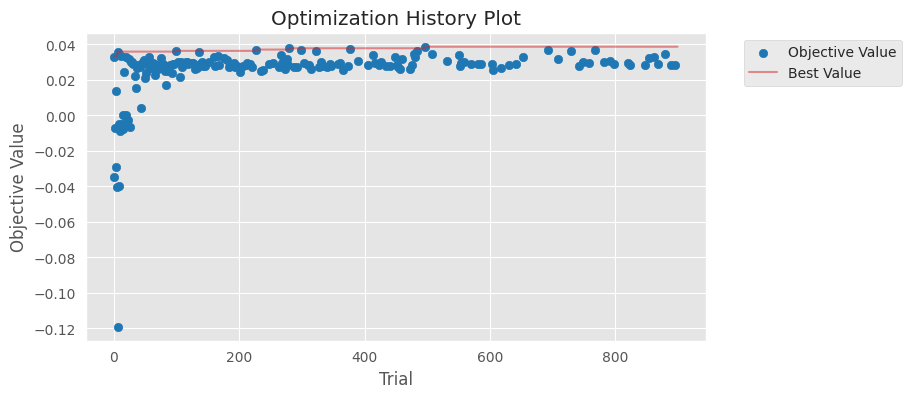

Best Parameters       : {'sign_smoothwin': 1, 'sellmin_idx': None, 'sess_start': '13:30:00', 'buy_thresh': 0.14920275364627128, 'trailstop_pct': 3.4844726319927823}
Best Average Daily P&L: 0.03871335227272727

Hyperparameter importances (higher ⇒ more impact):
  trailstop_pct       : 0.905
  buy_thresh          : 0.095
  sign_smoothwin      : 0.000
  sess_start          : 0.000
  sellmin_idx         : 0.000

Optuna results (and importances) saved to: optuna_results/AAPL_0.0387_predicted.json


In [6]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df_trainval.index.normalize().min().strftime("%Y%m%d")
last_day  = df_trainval.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")